In [1]:
import os
import pickle
import re
import pprint
import numpy as np
import sympy as sp
import openturns as ot
# Display the final graph
import openturns.viewer as viewer
import matplotlib.pyplot as plt
import trimesh as tr
from importlib import reload
from functools import partial

from math import pi
from joblib import Parallel, delayed
from importlib import reload
from IPython.display import display, clear_output
from time import time
from sympy.printing import latex
from trimesh import viewer as trview
import sklearn

from scipy.optimize import OptimizeResult, minimize, basinhopping, \
                           differential_evolution, brute, shgo, check_grad, \
                           approx_fprime, fsolve, NonlinearConstraint, Bounds, approx_fprime

import tqdm
import otaf

from gldpy import GLD

ot.Log.Show(ot.Log.NONE)
np.set_printoptions(suppress=True)
ar = np.array

# Notebook for the analysis of a system comprised of N + 2 parts, 2 plates with N = N1 x N2 holes, and N pins. 

### Defintion on global descriptive parameters

In [2]:
NX = 2 ## Number of holes on x axis
NY = 2 ## Number of holes on y axis
Dext = 20 ## Diameter of holes in mm
Dint = 19.8 ## Diameter of pins in mm
EH = 50 ## Distance between the hole axises
LB = 25 # Distance between border holes axis and edge.
hPlate = 30 #Height of the plates in mm
hPin = 60 #Height of the pins in mm

CIRCLE_RESOLUTION = 16 # NUmber of points to model the contour of the outer holes

### Defining and constructing the system data dictionary

The plates have NX * NY + 1 surfaces. The lower left point has coordinate 0,0,0

We only model the surfaces that are touching. 

In [3]:
N_PARTS = NX * NY * 2
LX = (NX - 1) * EH + 2*LB
LY = (NY - 1) * EH + 2*LB

contour_points = ar([[0,0,0],[LX,0,0],[LX,LY,0],[0,LY,0]])

R0 = ar([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
x_, y_, z_ = R0[0], R0[1], R0[2]

Frame1 = ar([z_,y_,-x_])
Frame2 = ar([-z_,y_,x_])

First we define the base part dictionaries for the upper and lower plate, without holes

In [4]:
system_data = {
    "PARTS" : {
        '0' : {
            "a" : {
                "FRAME": Frame1,
                "POINTS": {'A0' : ar([0,0,0]),
                           'A1' : ar([LX,0,0]),
                           'A2' : ar([LX,LY,0]),
                           'A3' : ar([0,LY,0]),
                        },
                "TYPE": "plane",
                "INTERACTIONS": ['P1a'],
                "CONSTRAINTS_D": ["PERFECT"],
                "CONSTRAINTS_G": ["SLIDING"],            
            }
        },
        '1' : {
            "a" : {
                "FRAME": Frame2,
                "POINTS": {'A0' : ar([0,0,0]),
                           'A1' : ar([LX,0,0]),
                           'A2' : ar([LX,LY,0]),
                           'A3' : ar([0,LY,0]),
                        },
                "TYPE": "plane",
                "INTERACTIONS": ['P0a'],
                "CONSTRAINTS_D": ["PERFECT"],
                "CONSTRAINTS_G": ["SLIDING"],            
            }
        }  
    },
    "LOOPS": {
        "COMPATIBILITY": {
        },
    },
    "GLOBAL_CONSTRAINTS": "3D",
}

Then we iterate over the pin dimensions NX and NY, and create the corresponding holes and pins. At the same time there is 1 loop per pin

In [5]:
alpha_gen = otaf.common.alphabet_generator()
next(alpha_gen) # skipping 'a' as it has already been used above
part_id = 2 # Start part index for pins
for i in range(NX):
    for j in range(NY):
        pcor = ar([LB+i*EH, LB+j*EH, 0]) # Point coordinate for hole / pins
        slab = next(alpha_gen) # Surface label, same for each mating pin so its easeir to track
        # Creating pin
        system_data["PARTS"][str(part_id)] = {}
        system_data["PARTS"][str(part_id)][slab] = {
            "FRAME": Frame1, # Frame doesn't really matter, as long as x is aligned on the axis
            "ORIGIN": pcor, 
            "TYPE": "cylinder",
            "RADIUS": Dint / 2,
            "EXTENT_LOCAL": {"x_max": hPin/2, "x_min": -hPin/2},
            "INTERACTIONS": [f"P0{slab}", f"P1{slab}"], 
            "SURFACE_DIRECTION": "centrifugal",
            "CONSTRAINTS_D": ["PERFECT"], # No defects on the pins
            "BLOCK_ROTATIONS_G": 'x', # The pins do not rotate around their axis
            "BLOCK_TRANSLATIONS_G": 'x', # The pins do not slide along their axis
        }
        # Adding hole to part 0
        system_data["PARTS"]["0"][slab] = {
            "FRAME": Frame1,
            "ORIGIN": pcor, 
            "TYPE": "cylinder",
            "RADIUS": Dext / 2,
            "EXTENT_LOCAL": {"x_max": hPin/2, "x_min": -hPin/2},
            "INTERACTIONS": [f"P{part_id}{slab}"], 
            "SURFACE_DIRECTION": "centripetal",
        }
        # Adding hole to part 1
        system_data["PARTS"]["1"][slab] = {
            "FRAME": Frame2,
            "ORIGIN": pcor, 
            "TYPE": "cylinder",
            "RADIUS": Dext / 2,
            "EXTENT_LOCAL": {"x_max": hPin/2, "x_min": -hPin/2},
            "INTERACTIONS": [f"P{part_id}{slab}"],
            "SURFACE_DIRECTION": "centripetal",
        }
        # Construct Compatibility loop
        loop_id = f"L{part_id-1}"
        formater = lambda i,l : f"P{i}{l}{l.upper()}0" 
        system_data["LOOPS"]["COMPATIBILITY"][loop_id] = f"P0aA0 -> {formater(0,slab)} -> {formater(part_id,slab)} -> {formater(1,slab)} -> P1aA0"
        part_id += 1  

In [6]:
SDA = otaf.AssemblyDataProcessor(system_data)
SDA.generate_expanded_loops()

In [7]:
CLH = otaf.CompatibilityLoopHandling(SDA)
compatibility_expressions = CLH.get_compatibility_expression_from_FO_matrices()

In [8]:
ILH = otaf.InterfaceLoopHandling(SDA, CLH, circle_resolution=CIRCLE_RESOLUTION)
interface_constraints = ILH.get_interface_loop_expressions()

Processing part 0, surface b for cylinder-to-cylinder interactions.
usedGMatDat [['0', 'b', 'B0', '2', 'b', 'B0']]
Found 1 used gap matrices.
unusedGMatDat [['0', 'b', 'B2', '2', 'b', 'B2'], ['0', 'b', 'B1', '2', 'b', 'B1']]
Found 2 unused gap matrices.
Matching used and unused gap matrices: GP0bB0P2bB0 with GP0bB2P2bB2
Matching used and unused gap matrices: GP0bB0P2bB0 with GP0bB1P2bB1
Generated 32 interaction equations for current matching.
Total interaction equations generated: 32
Processing part 0, surface c for cylinder-to-cylinder interactions.
usedGMatDat [['0', 'c', 'C0', '3', 'c', 'C0']]
Found 1 used gap matrices.
unusedGMatDat [['0', 'c', 'C1', '3', 'c', 'C1'], ['0', 'c', 'C2', '3', 'c', 'C2']]
Found 2 unused gap matrices.
Matching used and unused gap matrices: GP0cC0P3cC0 with GP0cC1P3cC1
Matching used and unused gap matrices: GP0cC0P3cC0 with GP0cC2P3cC2
Generated 32 interaction equations for current matching.
Total interaction equations generated: 32
Processing part 0, sur

In [9]:
SOCAM = otaf.SystemOfConstraintsAssemblyModel(
    compatibility_expressions, interface_constraints
)

SOCAM.embedOptimizationVariable()

print(len(SOCAM.deviation_symbols), SOCAM.deviation_symbols)

32 [v_d_0, w_d_0, beta_d_0, gamma_d_0, v_d_2, w_d_2, beta_d_2, gamma_d_2, v_d_5, w_d_5, beta_d_5, gamma_d_5, v_d_7, w_d_7, beta_d_7, gamma_d_7, v_d_8, w_d_8, beta_d_8, gamma_d_8, v_d_10, w_d_10, beta_d_10, gamma_d_10, v_d_11, w_d_11, beta_d_11, gamma_d_11, v_d_13, w_d_13, beta_d_13, gamma_d_13]


## Construction of the stochastic model of the defects.

These are the max variances. 

In [10]:
tol = 0.1 * np.sqrt(2)
Cm = 1  # Process capability

# Defining the uncertainties on the position and orientation uncertainties.
sigma_e_pos = tol / (6 * Cm)
theta_max = tol / hPlate
sigma_e_theta = (2 * theta_max) / (6 * Cm)

In [11]:
RandDeviationVect = otaf.distribution.get_composed_normal_defect_distribution(
    defect_names=SOCAM.deviation_symbols,
    sigma_dict = {"alpha":sigma_e_theta, 
                  "beta":sigma_e_theta,
                  "gamma":sigma_e_theta, 
                  "u":sigma_e_pos, 
                  "v":sigma_e_pos, 
                  "w":sigma_e_pos})
dim_devs = int(RandDeviationVect.getDimension())

In [12]:
STOP

NameError: name 'STOP' is not defined

## Estimating the bounds on the probability of failure of the model.

- First by exploring the whle parameter space, by generating a LHS in the (normalized) parameter space and doing a double loop montecarlo
- By using the parameter constraint function to guide an optimization algorithm to find the bounds on the probability of failure

## Now lets first to a double loop monte-carlo to explore the full space of the parameters (using the intermediate lambda space) and the stochastic space, to be able to draw the full P-Box of the slack

### Explicit constraint function on the 4 degrees of freedom of the cylindrical tolerance zone :

$$λu2​+λv2​+λα2​+λβ2​+2(λu​λα​+λv​λβ​)−1=0$$

This the constraint on the multipliers of the max standard deviation for each component of the DOFs. The defects are normal, centered and independent

In [ ]:
lambda_limit_sample = otaf.sampling.generate_imprecise_probabilistic_samples([4]*8, -1, discretization=1)
lambda_limit_sample_sub_choice = [next(lambda_limit_sample) for _ in range(60000)]
lambda_limit_sample_sub_choice = np.stack(lambda_limit_sample_sub_choice)
print(lambda_limit_sample_sub_choice.shape)

In [ ]:
def solve_for_lambda_beta(lambda_u, lambda_v, lambda_alpha):
    """
    Solve the equation for lambda_beta given lambda_u, lambda_v, and lambda_alpha.
    """
    def equation(lambda_beta):
        return (lambda_u**2 + lambda_v**2 + lambda_alpha**2 + lambda_beta**2 +
                2 * (lambda_u * lambda_alpha + lambda_v * lambda_beta) - 1)
    
    # Use a root-finding method to solve for lambda_beta
    lambda_beta_initial_guess = 0.5
    lambda_beta_solution = fsolve(equation, lambda_beta_initial_guess)[0]
    
    return lambda_beta_solution

def generate_points_on_surface(num_points=1000):
    """
    Generate points on the surface by solving for lambda_beta
    given random values for lambda_u, lambda_v, and lambda_alpha.
    
    Returns:
    - A numpy array of shape (num_valid_points, 4) where each row is 
      (lambda_u, lambda_v, lambda_alpha, lambda_beta).
    """
    # Generate random values for lambda_u, lambda_v, lambda_alpha in [0, 1]
    lambda_u = np.random.rand(num_points)
    lambda_v = np.random.rand(num_points)
    lambda_alpha = np.random.rand(num_points)
    
    # Assume lambda_beta = 0 and check if the inequality is satisfied
    inequality_values = lambda_u**2 + lambda_v**2 + lambda_alpha**2 + 2 * (lambda_u * lambda_alpha)

    # Filter valid points where inequality holds
    valid_mask = inequality_values <= 1
    lambda_u_valid = lambda_u[valid_mask]
    lambda_v_valid = lambda_v[valid_mask]
    lambda_alpha_valid = lambda_alpha[valid_mask]
    
    # Solve for lambda_beta for valid points
    lambda_beta_valid = np.array([solve_for_lambda_beta(u, v, a) 
                                  for u, v, a in zip(lambda_u_valid, lambda_v_valid, lambda_alpha_valid)])

    # Only keep points where the solved lambda_beta is between 0 and 1
    final_mask = (lambda_beta_valid >= 0) & (lambda_beta_valid <= 1)
    final_points = np.vstack((lambda_u_valid[final_mask],
                              lambda_v_valid[final_mask],
                              lambda_alpha_valid[final_mask],
                              lambda_beta_valid[final_mask])).T
    
    return final_points

# Generate the points on the surface
points = generate_points_on_surface(num_points=20000)

# Call the pair_plot function (assuming it's already defined)
labels = ['lambda_u', 'lambda_v', 'lambda_alpha', 'lambda_beta']
#otaf.plotting.pair_plot(points, labels)

In [ ]:
random_lambda_sample = [points[np.random.choice(points.shape[0], 200, replace=False)] for _ in range(8)]
random_lambda_sample = np.hstack(random_lambda_sample)

In [ ]:
N_lambda = random_lambda_sample.shape[0]
bounds = None
SEED_MC_PF = 6436431
SIZE_MC_PF = 10000 #int(1e6) #1e4
s_values = np.zeros((N_lambda, SIZE_MC_PF)) # For each MC point we have a s value
GLD_parameters = [] # We need the parameters of the generalized lambda distribution.
failure_probabilities = []
# Generalized lambda distribution object for fitting
gld = GLD('VSL')

start_time = time()  # Record the start time
for i in range(N_lambda):
    print(f"Doing iteration {i} of {N_lambda}")
    if i>0:
        fp = failure_probabilities
        print(f"Failure probability i-1 : {fp[i-1]}, Min: {min(fp)}, / Max: {max(fp)}")
        print("s_mean: ", s_values.mean().round(3), "s_min: ", np.nanmin(s_values).round(3), "s_max: ", np.nanmax(s_values).round(3))

    ot.RandomGenerator.SetSeed(SEED_MC_PF)
    deviation_samples = np.array(RandDeviationVect.getSample(SIZE_MC_PF)) * random_lambda_sample[i]
    optimizations = otaf.uncertainty.compute_gap_optimizations_on_sample(
            SOCAM,
            deviation_samples,
            bounds=bounds,
            n_cpu=-1,
            progress_bar=True,
        )
    
    slack = np.array([opt.fun for opt in optimizations], dtype=float)*-1 #Normally there aren"t any nans.
    s_values[i,:] = slack
    GLD_parameters.append(gld.fit_LMM(slack, disp_fit=False, disp_optimizer=False))
    failure_probabilities.append(gld.CDF_num(0, GLD_parameters[i]))


print(f"Done {N_lambda} experiments.")
print(f"Elapsed time: {time() - start_time:.3f} seconds.")

In [ ]:
X = otaf.sampling.find_best_worst_quantile(np.array(random_lambda_sample), np.array(failure_probabilities), 0.1)
(best_5p_lambda, best_5p_res), (worst_5p_lambda, worst_5p_res) = X

In [ ]:
distributions = [ot.UserDefined(ot.Sample(s[:,np.newaxis])) for s in s_values]
x_min, x_max = -0.03, 0.11
sup_data, inf_data = otaf.distribution.compute_sup_inf_distributions(distributions, x_min, x_max)

In [ ]:
%matplotlib inline

In [ ]:
# Initialize colors and legends for each lambda sample
colors = [["grey"]] * N_lambda
legends = [""] * N_lambda

# Plot the combined CDF with additional curves for the envelopes
graph_full = otaf.plotting.plot_combined_CDF(distributions, x_min, x_max, colors, legends)
graph_full = otaf.plotting.set_graph_legends(
    graph_full,
    x_title="slack",
    y_title="$P_{slack}$",
    title="Slack P-BOX 32 dimensions",
    legends=legends
)

# Add the upper and lower envelopes to the graph
graph_full.add(ot.Curve(inf_data, "blue", "solid", 1.5, "lower envelope"))
graph_full.add(ot.Curve(sup_data, "red", "solid", 1.5, "upper envelope"))
view = viewer.View(graph_full, pixelsize=(1100, 750))

In [ ]:
#%matplotlib inline
fig = plt.figure(dpi=150)

ax = fig.add_subplot(1, 1, 1)
ax.plot(sup_data[:, 0], sup_data[:, 1], color="tab:orange", label="upper envelope")
ax.plot(inf_data[:, 0], inf_data[:, 1], color="tab:blue", label="lower envelope")
ax.grid(True)
ax.fill_between(
    inf_data[:, 0], inf_data[:, 1], sup_data[:, 1], color="gray", alpha=0.3
)
ax.set_xlabel("slack")
ax.set_ylabel("$P_{slack}$")
ax.legend()
ax.set_title("Slack P-Box 3D Assembly 32D")

In [ ]:
print(f"Minimum failure probability: {np.min(failure_probabilities):.5e}, Maximum failure probability: {np.max(failure_probabilities):.5e}")

In [ ]:
STOP

## Global optimization basinhopping with GLD

### First we define the optimization functions $P_f(\Theta)$

In [13]:
SIZE_MC_PF = 10000 #int(1e6) #1e4
sample_gld = otaf.sampling.generate_and_transform_sequence(RandDeviationVect.getDimension(), SIZE_MC_PF, RandDeviationVect) 
# np.array(RandDeviationVect.getSample(SIZE_MC_PF))
scale_factor = 1.0
GLD_parameters = [] # We need the parameters of the generalized lambda distribution.

result_list = [] # Will be list of lists, where each sub list is a list of the input vector x and one for the gld paramters

# Generalized lambda distribution object for fitting
gld = GLD('VSL')

def model_base(x, sample=sample_gld):
    # Model without surrogate, to get slack
    x = sample * np.sqrt(x[np.newaxis, :])
    optimization_variables = otaf.uncertainty.compute_gap_optimizations_on_sample_batch(
        constraint_matrix_generator=SOCAM,
        deviation_array=x,
        batch_size=500,
        n_cpu=-1,
        progress_bar=True,
        verbose=0,
        dtype="float32",
    )
    slack_values = optimization_variables[:,-1]
    return slack_values

@otaf.optimization.scaling(scale_factor)
def optimization_function_mini(x, model=model_base):
    # Here we search the minimal probability of failure
    slack = model(x)
    gld_params = gld.fit_LMM(slack, disp_fit=False, disp_optimizer=False)
    if np.any(np.isnan(gld_params)):
        failure_probability = np.where(slack<0,1,0).mean()
    else :
        print("gld_params:", gld_params)
        failure_probability = gld.CDF_num(0, gld_params)
    return failure_probability

@otaf.optimization.scaling(scale_factor)
def optimization_function_maxi(x, model=model_base):
    # Here we search the maximal probability of failure so negative output
    slack = model(x)
    gld_params = gld.fit_LMM(slack, disp_fit=False, disp_optimizer=False)
    if np.any(np.isnan(gld_params)):
        failure_probability = np.where(slack<0,1,0).mean()
    else :
        print("gld_params:", gld_params)
        failure_probability = gld.CDF_num(0, gld_params)
    return failure_probability*-1

### Variance (std) based parameter constraint function

In [14]:
midof_funcs = otaf.tolerances.MiSdofToleranceZones()

feature_constraint_list = []

# We know that all features are cylindrical, with same values/dimensions
for i in range(8):
    fconst = otaf.tolerances.FeatureLevelStatisticalConstraint(
        midof_funcs.cylindrical_zone,
        mif_args = (tol, hPlate),
        n_dof = 4,
        n_sample = 30000,
        target = "std", #"prob",
        target_val = sigma_e_pos*np.sqrt(1-(2/np.pi)), #0.002699, #
        isNormal = True,
        normalizeOutput = True,
    )
    feature_constraint_list.append(fconst)

# The input of this object would be a list of parameters (their real value)
composed_assembly_constraint = otaf.tolerances.ComposedAssemblyLevelStatisticalConstraint(feature_constraint_list)

In [15]:
param_bounds_one_feature = [[0.0,0.0], [1e-8, sigma_e_pos], #u, mean std
                            [0.0,0.0], [1e-8, sigma_e_pos], #v, mean std
                            [0.0,0.0], [1e-8, sigma_e_theta], #alpha, mean std
                            [0.0,0.0], [1e-8, sigma_e_theta] # beta, mean std
                           ]
param_bounds = [param_bounds_one_feature] * 8 #We have 8 identical features

# The input of this object is a list of normalized parameters (between 0 and 1)
normalized_assembly_constraint = otaf.tolerances.NormalizedAssemblyLevelConstraint(
    composed_assembly_constraint,
    param_val_bounds=param_bounds)

#### The assembly constraint takes as an input the list of list of paramters for all the features. But as the distriutions (normals) are suppposed to be centered, we only need to have the standard deviations as inputs so we construct a little intermediary class that takes as an input only the standard deviations and not the means, and completes the means with 0 to pass it to the assembly constraint. 

In [16]:
def assembly_constraint_no_mean(param_list, scale_out=True):
    """ The functions takes directly the concatenated list of all normalized parameters, and reconstructs the right object.
    There should be 32 variables for the standard deviations, we just add the mean values in the vector so the input is correct 
    for the constraint object
    """
    assert len(param_list)==32, "problem with input."
    zer = np.zeros(4) # These are the mean values (all 0)
    pl = np.array(param_list)
    params_for_assembly = []
    for i in range(8):
        params = param_list[i*4:i*4+4]
        pa = [item for pair in zip(zer, params) for item in pair]
        params_for_assembly.append(pa)
    res =  normalized_assembly_constraint(params_for_assembly)
    if scale_out :
        return res * 10
    else :
        return res

In [17]:
jac_assembly_constraint_no_mean = lambda x : approx_fprime(x, 
              assembly_constraint_no_mean,
              0.001, 
              True,)

#### Now we create the assembly constraint for the optimization (so a non linear constraint)

In [18]:
# Define the nonlinear constraint with the updated vector-valued function and Jacobian
nonLinearConstraint = NonlinearConstraint(
    fun=assembly_constraint_no_mean,
    lb = -0.001 * np.ones((8,)), # Maybe could be directly 0
    ub = 0.001 * np.ones((8,)),
    #jac = jac_assembly_constraint_no_mean, #jac doesn't work for COBYQA
    keep_feasible=False,
)

#### Optimization to find the maximal probability of failure

In [19]:
# Initial guess
x0_maxi = [0.5] * RandDeviationVect.getDimension()  # Initial guess

# Perform the local optimization using COBYQA directly
res_maxi = minimize(
    optimization_function_maxi, 
    x0_maxi, 
    method="COBYQA", 
    jac=None, 
    bounds=Bounds(0.0, 1.0, keep_feasible=True),
    constraints = nonLinearConstraint,
    options={
        "f_target": -0.1, 
        "maxiter": 1000,
        "maxfev": 4000,
        "feasibility_tol": 1e-9,
        "initial_tr_radius": np.sqrt(2*32),
        "final_tr_radius": 1e-6,
        "disp": True,
        "scale": False #True
    }
)

print("Maximization Result with COBYQA:")
print(res_maxi)

Starting the optimization procedure.
Initial trust-region radius: 8.0.
Final trust-region radius: 0.0001.
Maximum number of function evaluations: 4000.
Maximum number of iterations: 1000.



  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05431317 0.01555498 0.36360562 0.12422729]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -9.881047135480592e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05396769 0.01552844 0.36718603 0.12450761]
wrapper([ 1.000e+00  5.000e-01 ...  5.000e-01  5.000e-01]) = -9.520831025319645e-05
assembly_constraint_no_mean([ 1.000e+00  5.000e-01 ...  5.000e-01  5.000e-01]) = [ 5.856e-01 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05397891 0.01549472 0.36667786 0.12284383]
wrapper([ 5.000e-01  1.000e+00 ...  5.000e-01  5.000e-01]) = -0.00010362997544048794
assembly_constraint_no_mean([ 5.000e-01  1.000e+00 ...  5.000e-01  5.000e-01]) = [ 5.893e-01 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05348964 0.01605819 0.35070008 0.10891362]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -0.0005460626341353839
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [ 5.869e-01 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05351268 0.01605045 0.3504794  0.10898383]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -0.0005406279390429969
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [ 5.899e-01 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05401219 0.01554959 0.36579527 0.12568091]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -9.262884049902561e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00  5.856e-01 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05397442 0.01552338 0.36686899 0.12433345]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -9.692831984882363e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00  5.893e-01 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05351353 0.01601651 0.35005873 0.106925  ]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -0.000573699738651373
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00  5.869e-01 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05354238 0.01602072 0.34847014 0.10893578]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -0.0005463059783187762
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00  5.899e-01 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05399196 0.01551649 0.36614886 0.12438949]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -9.715784861336135e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05397606 0.01550722 0.3667415  0.12403132]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -9.731200691971677e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05354946 0.01601898 0.34751717 0.10901006]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -0.000553067692051939
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05360037 0.01609447 0.34698752 0.1112718 ]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -0.0005341242508996261
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05401284 0.01551329 0.36537827 0.12404793]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -0.00010251591721051291
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05399118 0.01552538 0.36622686 0.12497179]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -9.397279029993255e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05350371 0.01608154 0.3498131  0.10999996]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -0.0005394502997526446
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05350809 0.01610698 0.34906749 0.11155387]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -0.0005236039233289998
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05403013 0.01556646 0.36498413 0.12656257]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -9.048773961867717e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05398752 0.01554078 0.36638593 0.12472181]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -9.719475797302514e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05355815 0.01614803 0.34837203 0.11358062]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -0.0005010862362380569
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05354272 0.01600734 0.34877503 0.10708645]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -0.0005762894342018199
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05401627 0.01553205 0.36553352 0.12477575]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -9.72642579408675e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05400876 0.01550136 0.36545087 0.12410927]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -9.839722075063033e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05350088 0.01603766 0.35003625 0.10904935]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -0.0005399052138664023
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05357688 0.01627859 0.34810954 0.11880248]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -0.0004497705137308731
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05400452 0.01553722 0.36551846 0.12513196]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -9.544935383589011e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ...  5.856e-01 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05400291 0.01547822 0.36592514 0.1229371 ]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -0.00010362997544048794
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ...  5.893e-01 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05359166 0.01605783 0.34701769 0.10967721]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -0.0005547160849635957
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ...  5.869e-01 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05363816 0.01621837 0.34575947 0.11683964]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -0.0004772848358882542
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ...  5.899e-01 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05400661 0.01556204 0.36632321 0.1259392 ]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -9.112751980436104e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00  5.856e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05399333 0.01552827 0.36614143 0.12443559]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -9.798178864122365e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00  5.893e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05343505 0.01593769 0.35158276 0.10544782]
wrapper([ 5.000e-01  5.000e-01 ...  1.000e+00  5.000e-01]) = -0.0005693058519600218
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  1.000e+00  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00  5.869e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05353956 0.01610927 0.34883887 0.1124101 ]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  1.000e+00]) = -0.0005080570025247677
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  1.000e+00]) = [-2.326e+00 -2.326e+00 ... -2.326e+00  5.899e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05466075 0.01562912 0.35971019 0.1248984 ]
wrapper([ 0.000e+00  5.000e-01 ...  5.000e-01  5.000e-01]) = -0.00010362997544048794
assembly_constraint_no_mean([ 0.000e+00  5.000e-01 ...  5.000e-01  5.000e-01]) = [-3.183e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05463662 0.01568357 0.36118167 0.12775089]
wrapper([ 5.000e-01  0.000e+00 ...  5.000e-01  5.000e-01]) = -8.645903671724377e-05
assembly_constraint_no_mean([ 5.000e-01  0.000e+00 ...  5.000e-01  5.000e-01]) = [-3.183e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05578648 0.01539072 0.35177262 0.12493659]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -6.610696135189609e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-3.183e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05569254 0.01527228 0.35382763 0.11903668]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -8.660063208078084e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-3.183e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05458679 0.01559372 0.36217869 0.12324518]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -0.00010696331036034356
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -3.183e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05466189 0.01570294 0.36063443 0.12757267]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -9.071565898275294e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -3.183e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05566444 0.0152597  0.35524509 0.12030608]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -7.483400122127556e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -3.183e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05566049 0.01524417 0.35520272 0.11783258]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -8.649600411942413e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -3.183e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05464152 0.01567822 0.36120019 0.12628289]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -9.513119427740877e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05456499 0.01561599 0.36336053 0.12345634]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -0.00010362997544048794
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05567828 0.01531006 0.35682169 0.11914426]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -8.330948908841061e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05573216 0.01522508 0.35292955 0.11838611]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -8.680688873715461e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05461108 0.01562034 0.36217515 0.12417937]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -0.00010304903348212175
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05457574 0.0156335  0.3630071  0.12399692]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -0.00010362997544048794
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05574805 0.01532251 0.35352636 0.12021107]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -8.501410589630055e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05579669 0.01540685 0.35353053 0.12445204]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -6.944029566575411e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05458677 0.01556831 0.36262201 0.12183311]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -0.00011210111754366526
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05458737 0.01552521 0.36242604 0.12036612]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -0.00011654273789279756
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05554684 0.01526217 0.35966498 0.11954111]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -7.356740209052043e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05576116 0.01537444 0.35353508 0.12323322]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -7.256373821593009e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05462285 0.01561028 0.36130124 0.12394612]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -0.00010362997544048794
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05451221 0.01560411 0.3654229  0.12195743]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -0.00011029664528019918
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05557638 0.01530841 0.35881996 0.12184543]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -6.610696135189609e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05571307 0.015396   0.35578683 0.12224424]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -7.512112265962631e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05462048 0.01566293 0.36212017 0.12518555]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -9.883381970468033e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -3.183e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05459219 0.01566152 0.36243929 0.12561637]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -9.568881578793422e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -3.183e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05565207 0.01522587 0.35743448 0.11820761]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -8.166098795819532e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -3.183e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05575237 0.0152934  0.35251605 0.12107724]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -7.730247398936547e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -3.183e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05462602 0.01559668 0.36054627 0.12375613]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -0.00010696331036034356
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -3.183e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05462287 0.01568963 0.36167616 0.12716537]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = -9.032255688578299e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -3.183e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05568656 0.01540855 0.35702488 0.12467484]
wrapper([ 5.000e-01  5.000e-01 ...  0.000e+00  5.000e-01]) = -6.277362703803806e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  0.000e+00  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -3.183e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05575661 0.0154287  0.35316983 0.12612898]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  0.000e+00]) = -6.277362703803806e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  0.000e+00]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -3.183e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04826893 0.01810461 0.35476508 0.11731774]
wrapper([ 5.740e-01  5.772e-01 ...  6.627e-01  6.518e-01]) = -0.0034963642067657188
assembly_constraint_no_mean([ 5.740e-01  5.772e-01 ...  6.627e-01  6.518e-01]) = [-5.204e-01  3.865e-01 ... -5.635e-01 -5.249e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04467696 0.02040128 0.34903666 0.12131167]
wrapper([ 4.694e-01  4.808e-01 ...  8.384e-01  7.895e-01]) = -0.01310426888112536
assembly_constraint_no_mean([ 4.694e-01  4.808e-01 ...  8.384e-01  7.895e-01]) = [ 2.135e-01  4.489e-02 ...  1.898e-01  2.219e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04247907 0.02288819 0.34901883 0.13112452]
wrapper([ 2.622e-01  2.841e-01 ...  9.820e-01  8.832e-01]) = -0.027485304991546968
assembly_constraint_no_mean([ 2.622e-01  2.841e-01 ...  9.820e-01  8.832e-01]) = [ 3.925e-01  2.271e-01 ...  4.735e-01  4.941e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0423344  0.02089931 0.35085646 0.12011967]
wrapper([ 5.997e-01  6.096e-01 ...  1.000e+00  8.476e-01]) = -0.01968960201900106
assembly_constraint_no_mean([ 5.997e-01  6.096e-01 ...  1.000e+00  8.476e-01]) = [ 1.393e+00  7.693e-02 ...  1.278e+00  1.921e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04387132 0.02132421 0.34724032 0.12501297]
wrapper([ 4.301e-01  4.447e-01 ...  9.637e-01  7.692e-01]) = -0.017904682398086826
assembly_constraint_no_mean([ 4.301e-01  4.447e-01 ...  9.637e-01  7.692e-01]) = [ 1.707e-01  3.484e-01 ...  1.815e-01  4.029e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04508676 0.02014782 0.34769834 0.12303909]
wrapper([ 5.099e-01  5.208e-01 ...  5.054e-01  6.237e-01]) = -0.011476812905798564
assembly_constraint_no_mean([ 5.099e-01  5.208e-01 ...  5.054e-01  6.237e-01]) = [ 4.671e-01 -2.668e-01 ...  1.622e+00 -2.045e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04395188 0.02145138 0.34782912 0.126417  ]
wrapper([ 3.563e-01  3.730e-01 ...  8.577e-01  8.341e-01]) = -0.01796052108518045
assembly_constraint_no_mean([ 3.563e-01  3.730e-01 ...  8.577e-01  8.341e-01]) = [ 8.814e-02 -3.959e-02 ...  1.494e-01  5.155e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04294015 0.02305581 0.35059982 0.13389864]
wrapper([ 2.043e-01  2.272e-01 ...  9.629e-01  8.979e-01]) = -0.026202429010588262
assembly_constraint_no_mean([ 2.043e-01  2.272e-01 ...  9.629e-01  8.979e-01]) = [ 1.517e-01  3.591e-01 ...  1.444e-01  2.821e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04397942 0.02139071 0.34430448 0.12410464]
wrapper([ 3.267e-01  3.416e-01 ...  6.359e-01  9.723e-01]) = -0.018542111038855117
assembly_constraint_no_mean([ 3.267e-01  3.416e-01 ...  6.359e-01  9.723e-01]) = [ 7.913e-02  1.759e+00 ... -3.610e-01  2.977e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04333022 0.02246551 0.3483765  0.13132723]
wrapper([ 2.664e-01  2.872e-01 ...  9.023e-01  8.384e-01]) = -0.023091538559483864
assembly_constraint_no_mean([ 2.664e-01  2.872e-01 ...  9.023e-01  8.384e-01]) = [ 6.959e-02  6.516e-01 ... -5.530e-03  3.625e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04441928 0.02139739 0.3417115  0.1237709 ]
wrapper([ 3.613e-01  3.792e-01 ...  7.432e-01  7.205e-01]) = -0.018071889362798577
assembly_constraint_no_mean([ 3.613e-01  3.792e-01 ...  7.432e-01  7.205e-01]) = [ 8.489e-01  1.601e+00 ...  8.309e-01 -6.270e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04334822 0.02244251 0.347578   0.13112239]
wrapper([ 2.422e-01  2.621e-01 ...  8.974e-01  8.365e-01]) = -0.02310863527066377
assembly_constraint_no_mean([ 2.422e-01  2.621e-01 ...  8.974e-01  8.365e-01]) = [ 3.153e-01  5.814e-01 ...  1.102e-01  4.031e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04458878 0.02117183 0.34405985 0.12495626]
wrapper([ 3.108e-01  3.253e-01 ...  7.008e-01  7.808e-01]) = -0.016271223065374946
assembly_constraint_no_mean([ 3.108e-01  3.253e-01 ...  7.008e-01  7.808e-01]) = [-2.104e+00  1.335e+00 ...  1.626e-01 -4.516e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04341384 0.02251156 0.34782059 0.13155619]
wrapper([ 2.839e-01  3.050e-01 ...  9.247e-01  8.079e-01]) = -0.023156052412276685
assembly_constraint_no_mean([ 2.839e-01  3.050e-01 ...  9.247e-01  8.079e-01]) = [ 1.598e-03  2.292e-01 ...  1.807e-01  8.113e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04448688 0.02131924 0.34499785 0.12486965]
wrapper([ 3.708e-01  3.871e-01 ...  6.571e-01  8.172e-01]) = -0.016965628591699033
assembly_constraint_no_mean([ 3.708e-01  3.871e-01 ...  6.571e-01  8.172e-01]) = [ 2.523e-01  1.374e+00 ... -3.209e-01 -2.893e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04334401 0.02248897 0.34815056 0.13033604]
wrapper([ 2.504e-01  2.740e-01 ...  9.300e-01  8.264e-01]) = -0.023400203342429968
assembly_constraint_no_mean([ 2.504e-01  2.740e-01 ...  9.300e-01  8.264e-01]) = [ 8.552e-02  2.550e-01 ...  1.283e-01  1.316e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04415304 0.02148486 0.34495113 0.12546086]
wrapper([ 3.305e-01  3.506e-01 ...  6.782e-01  8.244e-01]) = -0.018257100586738777
assembly_constraint_no_mean([ 3.305e-01  3.506e-01 ...  6.782e-01  8.244e-01]) = [ 4.127e-01  1.369e+00 ... -5.047e-02 -2.718e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04333789 0.02245544 0.34867862 0.1296862 ]
wrapper([ 2.783e-01  2.989e-01 ...  9.265e-01  8.561e-01]) = -0.023284777103868882
assembly_constraint_no_mean([ 2.783e-01  2.989e-01 ...  9.265e-01  8.561e-01]) = [ 9.237e-02  2.683e-01 ...  9.196e-02  1.260e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04358739 0.02144389 0.3459496  0.12165315]
wrapper([ 3.863e-01  4.053e-01 ...  8.149e-01  7.808e-01]) = -0.01982280867999463
assembly_constraint_no_mean([ 3.863e-01  4.053e-01 ...  8.149e-01  7.808e-01]) = [ 5.410e-01 -3.030e-01 ...  3.462e-01  4.074e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04330293 0.02241082 0.34925867 0.12951418]
wrapper([ 2.396e-01  2.616e-01 ...  9.246e-01  8.609e-01]) = -0.023088467825301284
assembly_constraint_no_mean([ 2.396e-01  2.616e-01 ...  9.246e-01  8.609e-01]) = [ 1.474e-01  4.744e-01 ...  4.263e-02  1.265e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04340778 0.02162297 0.34795393 0.12542804]
wrapper([ 3.275e-01  3.454e-01 ...  9.235e-01  8.816e-01]) = -0.02007118014298336
assembly_constraint_no_mean([ 3.275e-01  3.454e-01 ...  9.235e-01  8.816e-01]) = [-1.467e-01  6.833e-01 ...  2.029e-01  9.442e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04335773 0.02249139 0.3488105  0.1308407 ]
wrapper([ 2.413e-01  2.644e-01 ...  9.424e-01  8.274e-01]) = -0.02316720974124035
assembly_constraint_no_mean([ 2.413e-01  2.644e-01 ...  9.424e-01  8.274e-01]) = [ 8.614e-02  2.520e-01 ...  8.245e-02  1.238e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04339163 0.02165262 0.34821563 0.12598785]
wrapper([ 3.337e-01  3.504e-01 ...  9.111e-01  8.961e-01]) = -0.020103781978901756
assembly_constraint_no_mean([ 3.337e-01  3.504e-01 ...  9.111e-01  8.961e-01]) = [-9.127e-02  6.816e-01 ...  2.087e-01  9.201e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04328964 0.02254099 0.34921096 0.13269967]
wrapper([ 2.337e-01  2.515e-01 ...  8.564e-01  9.134e-01]) = -0.023159120169586652
assembly_constraint_no_mean([ 2.337e-01  2.515e-01 ...  8.564e-01  9.134e-01]) = [ 9.402e-02  3.046e-01 ...  6.995e-02  1.484e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04374058 0.02153349 0.34697731 0.12454102]
wrapper([ 7.674e-01  2.996e-01 ...  7.983e-01  8.664e-01]) = -0.019226042692690824
assembly_constraint_no_mean([ 7.674e-01  2.996e-01 ...  7.983e-01  8.664e-01]) = [ 1.342e+00  4.153e-01 ... -3.931e-02  1.758e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04333526 0.02251535 0.34884495 0.13175143]
wrapper([ 3.157e-01  2.075e-01 ...  9.017e-01  8.668e-01]) = -0.023161610726275084
assembly_constraint_no_mean([ 3.157e-01  2.075e-01 ...  9.017e-01  8.668e-01]) = [ 1.462e-01  2.785e-01 ...  6.959e-02  7.479e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04371138 0.02155183 0.34695325 0.12519852]
wrapper([ 2.793e-01  3.106e-01 ...  8.108e-01  8.652e-01]) = -0.019260708574489405
assembly_constraint_no_mean([ 2.793e-01  3.106e-01 ...  8.108e-01  8.652e-01]) = [ 6.188e-02  3.863e-01 ... -4.293e-02  2.316e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04329722 0.02253783 0.34935489 0.13213702]
wrapper([ 2.714e-01  2.904e-01 ...  8.710e-01  8.914e-01]) = -0.02320738806249311
assembly_constraint_no_mean([ 2.714e-01  2.904e-01 ...  8.710e-01  8.914e-01]) = [ 1.171e-01  2.690e-01 ...  4.065e-02  4.772e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04372664 0.0215053  0.34718538 0.12372761]
wrapper([ 2.684e-01  2.935e-01 ...  8.202e-01  8.521e-01]) = -0.019242203986252544
assembly_constraint_no_mean([ 2.684e-01  2.935e-01 ...  8.202e-01  8.521e-01]) = [ 1.329e-01  3.843e-01 ... -7.715e-02  2.120e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04333219 0.02254619 0.34921901 0.13206955]
wrapper([ 2.325e-01  2.502e-01 ...  8.809e-01  8.736e-01]) = -0.023195441442997528
assembly_constraint_no_mean([ 2.325e-01  2.502e-01 ...  8.809e-01  8.736e-01]) = [ 1.119e-01  2.502e-01 ...  5.584e-02  2.003e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04366972 0.02154396 0.34726695 0.12406816]
wrapper([ 2.881e-01  8.011e-01 ...  8.122e-01  8.492e-01]) = -0.019469113030039
assembly_constraint_no_mean([ 2.881e-01  8.011e-01 ...  8.122e-01  8.492e-01]) = [ 1.689e+00  5.530e-01 ... -3.382e-01  1.033e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.043316   0.02253636 0.34922143 0.13171407]
wrapper([ 2.305e-01  3.017e-01 ...  8.542e-01  8.874e-01]) = -0.023256264840062227
assembly_constraint_no_mean([ 2.305e-01  3.017e-01 ...  8.542e-01  8.874e-01]) = [ 1.443e-01  2.816e-01 ...  8.244e-02  8.800e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04346226 0.02162895 0.34734451 0.12594879]
wrapper([ 3.337e-01  3.491e-01 ...  9.498e-01  8.504e-01]) = -0.019974893232069788
assembly_constraint_no_mean([ 3.337e-01  3.491e-01 ...  9.498e-01  8.504e-01]) = [ 1.765e-01  7.697e-01 ... -1.466e-01  7.674e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04329531 0.02256087 0.34899135 0.1326492 ]
wrapper([ 2.374e-01  2.823e-01 ...  9.250e-01  8.603e-01]) = -0.023289795280909943
assembly_constraint_no_mean([ 2.374e-01  2.823e-01 ...  9.250e-01  8.603e-01]) = [ 1.030e-01  2.914e-01 ...  7.854e-02  1.006e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04382309 0.02160415 0.34768129 0.1286665 ]
wrapper([ 3.757e-01  3.742e-01 ...  8.362e-01  8.195e-01]) = -0.018534374045478544
assembly_constraint_no_mean([ 3.757e-01  3.742e-01 ...  8.362e-01  8.195e-01]) = [ 2.207e-01  4.201e-01 ...  1.493e-01  5.028e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04331501 0.02255456 0.3490372  0.1325419 ]
wrapper([ 2.389e-01  2.660e-01 ...  9.211e-01  8.606e-01]) = -0.02322103716562782
assembly_constraint_no_mean([ 2.389e-01  2.660e-01 ...  9.211e-01  8.606e-01]) = [ 8.090e-02  2.580e-01 ...  6.987e-02  1.039e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04424246 0.02147497 0.34625701 0.1264065 ]
wrapper([ 3.679e-01  3.330e-01 ...  8.735e-01  7.790e-01]) = -0.017681125421715176
assembly_constraint_no_mean([ 3.679e-01  3.330e-01 ...  8.735e-01  7.790e-01]) = [ 2.450e-01  3.635e-01 ...  9.595e-01  2.613e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04331582 0.02255272 0.3489773  0.13269054]
wrapper([ 2.378e-01  2.606e-01 ...  9.366e-01  8.459e-01]) = -0.023191795522063928
assembly_constraint_no_mean([ 2.378e-01  2.606e-01 ...  9.366e-01  8.459e-01]) = [ 6.414e-02  1.746e-01 ...  1.540e-01  1.333e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04432306 0.02142267 0.348201   0.12831012]
wrapper([ 3.996e-01  3.678e-01 ...  7.540e-01  7.624e-01]) = -0.016711341558561837
assembly_constraint_no_mean([ 3.996e-01  3.678e-01 ...  7.540e-01  7.624e-01]) = [ 1.131e-01  1.252e-01 ...  4.309e-01 -9.252e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04330081 0.02256311 0.34910973 0.1325227 ]
wrapper([ 2.474e-01  2.773e-01 ...  9.119e-01  8.688e-01]) = -0.023290569142962153
assembly_constraint_no_mean([ 2.474e-01  2.773e-01 ...  9.119e-01  8.688e-01]) = [ 9.723e-02  2.577e-01 ...  7.496e-02  7.415e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04429973 0.021426   0.34562251 0.12435531]
wrapper([ 3.619e-01  0.000e+00 ...  8.781e-01  7.218e-01]) = -0.017790921947256528
assembly_constraint_no_mean([ 3.619e-01  0.000e+00 ...  8.781e-01  7.218e-01]) = [ 3.416e-01  1.510e-01 ... -1.251e+00 -2.296e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04325987 0.0225421  0.34896429 0.13201071]
wrapper([ 2.421e-01  2.746e-01 ...  9.260e-01  8.410e-01]) = -0.023415633369923812
assembly_constraint_no_mean([ 2.421e-01  2.746e-01 ...  9.260e-01  8.410e-01]) = [ 1.725e-01  2.600e-01 ...  6.366e-02  5.643e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04413666 0.02144927 0.34742221 0.12671688]
wrapper([ 3.720e-01  3.911e-01 ...  8.410e-01  8.720e-01]) = -0.01757700932443777
assembly_constraint_no_mean([ 3.720e-01  3.911e-01 ...  8.410e-01  8.720e-01]) = [-2.259e-01  1.046e-01 ...  6.948e-01  1.287e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04329294 0.02257315 0.34900668 0.1326527 ]
wrapper([ 2.415e-01  2.669e-01 ...  9.248e-01  8.597e-01]) = -0.023352945376039942
assembly_constraint_no_mean([ 2.415e-01  2.669e-01 ...  9.248e-01  8.597e-01]) = [ 8.232e-02  2.390e-01 ...  9.902e-02  9.380e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04341928 0.02170915 0.34677686 0.12657042]
wrapper([ 4.078e-01  4.121e-01 ...  8.343e-01  7.791e-01]) = -0.020419500204002246
assembly_constraint_no_mean([ 4.078e-01  4.121e-01 ...  8.343e-01  7.791e-01]) = [ 5.364e-01  1.045e+00 ...  1.093e-01 -9.807e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04328733 0.02257038 0.34891556 0.13251099]
wrapper([ 2.439e-01  2.619e-01 ...  9.243e-01  8.616e-01]) = -0.023396641508682144
assembly_constraint_no_mean([ 2.439e-01  2.619e-01 ...  9.243e-01  8.616e-01]) = [ 8.591e-02  2.825e-01 ...  7.942e-02  9.527e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04402695 0.02150759 0.34631472 0.12512702]
wrapper([ 3.891e-01  3.556e-01 ...  8.142e-01  7.444e-01]) = -0.018484089829751537
assembly_constraint_no_mean([ 3.891e-01  3.556e-01 ...  8.142e-01  7.444e-01]) = [ 1.080e+00  1.909e-01 ... -5.393e-01 -5.556e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04327553 0.02256265 0.34889391 0.13230158]
wrapper([ 2.461e-01  2.615e-01 ...  9.347e-01  8.503e-01]) = -0.023432894577856193
assembly_constraint_no_mean([ 2.461e-01  2.615e-01 ...  9.347e-01  8.503e-01]) = [ 9.742e-02  2.696e-01 ...  7.912e-02  1.052e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0442486  0.02135385 0.34726557 0.12477408]
wrapper([ 3.724e-01  3.620e-01 ...  8.042e-01  6.961e-01]) = -0.01729333773699408
assembly_constraint_no_mean([ 3.724e-01  3.620e-01 ...  8.042e-01  6.961e-01]) = [-1.145e+00  5.362e-02 ...  7.007e-01 -9.064e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04327054 0.02256644 0.34922533 0.13234078]
wrapper([ 2.518e-01  2.705e-01 ...  9.365e-01  8.496e-01]) = -0.023399581277031532
assembly_constraint_no_mean([ 2.518e-01  2.705e-01 ...  9.365e-01  8.496e-01]) = [ 8.218e-02  2.399e-01 ...  8.750e-02  1.068e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04406672 0.02139454 0.34631068 0.12365321]
wrapper([ 3.316e-01  3.668e-01 ...  8.612e-01  6.498e-01]) = -0.01816235619013951
assembly_constraint_no_mean([ 3.316e-01  3.668e-01 ...  8.612e-01  6.498e-01]) = [ 2.159e-02 -5.131e-02 ...  1.224e+00 -6.466e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04326579 0.02256615 0.34913208 0.13221377]
wrapper([ 2.524e-01  2.633e-01 ...  9.368e-01  8.441e-01]) = -0.023450883054153326
assembly_constraint_no_mean([ 2.524e-01  2.633e-01 ...  9.368e-01  8.441e-01]) = [ 9.098e-02  2.472e-01 ...  8.493e-02  9.998e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04425801 0.02134164 0.3490482  0.12625182]
wrapper([ 4.152e-01  4.401e-01 ...  8.232e-01  8.074e-01]) = -0.01673120662381059
assembly_constraint_no_mean([ 4.152e-01  4.401e-01 ...  8.232e-01  8.074e-01]) = [ 1.108e+00 -2.084e-01 ... -2.428e-01 -1.214e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04328791 0.02255622 0.34896181 0.13222606]
wrapper([ 2.470e-01  2.608e-01 ...  9.397e-01  8.461e-01]) = -0.023372247989017395
assembly_constraint_no_mean([ 2.470e-01  2.608e-01 ...  9.397e-01  8.461e-01]) = [ 8.843e-02  2.848e-01 ...  7.716e-02  1.105e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04393081 0.0211902  0.34853711 0.12234284]
wrapper([ 3.332e-01  3.791e-01 ...  8.603e-01  7.797e-01]) = -0.017480027966138113
assembly_constraint_no_mean([ 3.332e-01  3.791e-01 ...  8.603e-01  7.797e-01]) = [ 1.027e-01  4.824e-02 ...  6.035e-01  8.826e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04326736 0.02256901 0.34916612 0.13223137]
wrapper([ 2.568e-01  2.571e-01 ...  9.336e-01  8.491e-01]) = -0.023451669881787287
assembly_constraint_no_mean([ 2.568e-01  2.571e-01 ...  9.336e-01  8.491e-01]) = [ 9.434e-02  2.274e-01 ...  9.070e-02  9.596e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04393103 0.02119857 0.34835284 0.12522669]
wrapper([ 3.736e-01  4.026e-01 ...  8.044e-01  8.568e-01]) = -0.017059079528364003
assembly_constraint_no_mean([ 3.736e-01  4.026e-01 ...  8.044e-01  8.568e-01]) = [ 2.830e-01  1.280e-01 ...  5.990e-01  4.064e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04329243 0.02255776 0.34899452 0.13226786]
wrapper([ 2.482e-01  2.627e-01 ...  9.402e-01  8.498e-01]) = -0.02335456388306411
assembly_constraint_no_mean([ 2.482e-01  2.627e-01 ...  9.402e-01  8.498e-01]) = [ 8.389e-02  2.725e-01 ...  7.239e-02  1.157e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04422272 0.02131038 0.34551182 0.12765174]
wrapper([ 3.958e-01  3.951e-01 ...  8.374e-01  6.817e-01]) = -0.01692527552905633
assembly_constraint_no_mean([ 3.958e-01  3.951e-01 ...  8.374e-01  6.817e-01]) = [ 1.431e-01 -4.286e-01 ...  2.056e-01 -6.706e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04329945 0.02255627 0.34883885 0.13236199]
wrapper([ 2.475e-01  2.620e-01 ...  9.429e-01  8.434e-01]) = -0.02333799165218158
assembly_constraint_no_mean([ 2.475e-01  2.620e-01 ...  9.429e-01  8.434e-01]) = [ 8.786e-02  2.738e-01 ...  7.651e-02  1.162e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04411005 0.02155136 0.34591927 0.13052848]
wrapper([ 3.187e-01  2.761e-01 ...  8.068e-01  9.145e-01]) = -0.017633323402297875
assembly_constraint_no_mean([ 3.187e-01  2.761e-01 ...  8.068e-01  9.145e-01]) = [-6.619e-01  6.738e-01 ... -6.325e-02  3.121e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0432909  0.02255827 0.34894493 0.13243244]
wrapper([ 2.505e-01  2.631e-01 ...  9.392e-01  8.493e-01]) = -0.023337916025009522
assembly_constraint_no_mean([ 2.505e-01  2.631e-01 ...  9.392e-01  8.493e-01]) = [ 8.148e-02  2.626e-01 ...  5.966e-02  1.165e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04519853 0.02099813 0.34673064 0.12319982]
wrapper([ 3.411e-01  4.308e-01 ...  8.104e-01  8.832e-01]) = -0.014407057778001945
assembly_constraint_no_mean([ 3.411e-01  4.308e-01 ...  8.104e-01  8.832e-01]) = [-5.266e-01 -3.747e-01 ... -1.247e+00 -1.145e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04328225 0.02256407 0.34898635 0.13244572]
wrapper([ 2.509e-01  2.619e-01 ...  9.377e-01  8.490e-01]) = -0.023378964573418315
assembly_constraint_no_mean([ 2.509e-01  2.619e-01 ...  9.377e-01  8.490e-01]) = [ 8.323e-02  2.542e-01 ...  6.737e-02  1.114e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04566328 0.0207261  0.34792456 0.12387118]
wrapper([ 3.785e-01  3.897e-01 ...  8.463e-01  9.183e-01]) = -0.012419889627427402
assembly_constraint_no_mean([ 3.785e-01  3.897e-01 ...  8.463e-01  9.183e-01]) = [-4.580e-01 -2.286e-01 ... -6.494e-01  3.693e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04328659 0.02256332 0.34899542 0.132431  ]
wrapper([ 2.500e-01  2.619e-01 ...  9.382e-01  8.499e-01]) = -0.02336539861273194
assembly_constraint_no_mean([ 2.500e-01  2.619e-01 ...  9.382e-01  8.499e-01]) = [ 8.177e-02  2.541e-01 ...  6.779e-02  1.113e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04448325 0.02146194 0.34392801 0.13013438]
wrapper([ 4.124e-01  3.034e-01 ...  5.598e-01  1.000e+00]) = -0.016837204759838267
assembly_constraint_no_mean([ 4.124e-01  3.034e-01 ...  5.598e-01  1.000e+00]) = [-6.501e-02 -1.180e+00 ...  1.543e+00  1.111e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04329696 0.02255666 0.3489158  0.13227815]
wrapper([ 2.458e-01  2.659e-01 ...  9.438e-01  8.395e-01]) = -0.023349132846091226
assembly_constraint_no_mean([ 2.458e-01  2.659e-01 ...  9.438e-01  8.395e-01]) = [ 8.197e-02  2.677e-01 ...  7.053e-02  1.142e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04501357 0.0212876  0.34594803 0.12980108]
wrapper([ 3.978e-01  4.068e-01 ...  8.363e-01  8.056e-01]) = -0.014911896241527764
assembly_constraint_no_mean([ 3.978e-01  4.068e-01 ...  8.363e-01  8.056e-01]) = [ 1.700e+00 -9.927e-01 ... -1.447e-01 -2.048e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04328916 0.02256422 0.34897312 0.13246459]
wrapper([ 2.495e-01  2.633e-01 ...  9.377e-01  8.489e-01]) = -0.023360613899525453
assembly_constraint_no_mean([ 2.495e-01  2.633e-01 ...  9.377e-01  8.489e-01]) = [ 9.694e-02  2.636e-01 ...  7.145e-02  1.099e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04502645 0.02105203 0.3459588  0.12480572]
wrapper([ 3.747e-01  4.274e-01 ...  8.126e-01  7.781e-01]) = -0.014763385907453441
assembly_constraint_no_mean([ 3.747e-01  4.274e-01 ...  8.126e-01  7.781e-01]) = [ 3.268e-01 -3.698e-01 ... -3.052e-01 -5.319e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04328778 0.02257173 0.34907976 0.13244694]
wrapper([ 2.525e-01  2.613e-01 ...  9.364e-01  8.476e-01]) = -0.023386121340131263
assembly_constraint_no_mean([ 2.525e-01  2.613e-01 ...  9.364e-01  8.476e-01]) = [ 9.740e-02  2.162e-01 ...  8.068e-02  1.098e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04468838 0.02123478 0.34397112 0.12358637]
wrapper([ 2.616e-01  3.148e-01 ...  8.602e-01  8.699e-01]) = -0.016569639917422677
assembly_constraint_no_mean([ 2.616e-01  3.148e-01 ...  8.602e-01  8.699e-01]) = [-2.207e-01 -2.000e-02 ... -1.505e-01  8.627e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0433118  0.02255481 0.34901563 0.13243276]
wrapper([ 2.522e-01  2.658e-01 ...  9.351e-01  8.484e-01]) = -0.023255145067038907
assembly_constraint_no_mean([ 2.522e-01  2.658e-01 ...  9.351e-01  8.484e-01]) = [ 7.954e-02  2.608e-01 ...  6.634e-02  9.737e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04520068 0.02124606 0.34469895 0.13015942]
wrapper([ 3.294e-01  3.550e-01 ...  8.913e-01  6.703e-01]) = -0.014516167510664008
assembly_constraint_no_mean([ 3.294e-01  3.550e-01 ...  8.913e-01  6.703e-01]) = [-2.762e-01 -2.975e-01 ...  3.683e-01 -5.939e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0433207  0.02255359 0.34900074 0.13247349]
wrapper([ 2.504e-01  2.642e-01 ...  9.313e-01  8.488e-01]) = -0.023221187890687372
assembly_constraint_no_mean([ 2.504e-01  2.642e-01 ...  9.313e-01  8.488e-01]) = [ 7.325e-02  2.544e-01 ...  7.358e-02  8.518e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04508382 0.02118193 0.34253996 0.12440395]
wrapper([ 2.453e-01  3.075e-01 ...  8.442e-01  8.261e-01]) = -0.015659532080741202
assembly_constraint_no_mean([ 2.453e-01  3.075e-01 ...  8.442e-01  8.261e-01]) = [-3.699e-01  4.228e-01 ...  2.852e-01 -1.019e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04332749 0.02255178 0.34896896 0.13251382]
wrapper([ 2.468e-01  2.629e-01 ...  9.321e-01  8.513e-01]) = -0.023192696507406692
assembly_constraint_no_mean([ 2.468e-01  2.629e-01 ...  9.321e-01  8.513e-01]) = [ 6.079e-02  2.564e-01 ...  7.158e-02  9.096e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04596121 0.02056999 0.34669587 0.12182222]
wrapper([ 3.695e-01  3.921e-01 ...  7.689e-01  7.676e-01]) = -0.011855710074167978
assembly_constraint_no_mean([ 3.695e-01  3.921e-01 ...  7.689e-01  7.676e-01]) = [ 7.645e-01 -1.250e+00 ... -1.263e+00 -9.199e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04332874 0.02255057 0.34899193 0.13246882]
wrapper([ 2.476e-01  2.645e-01 ...  9.326e-01  8.505e-01]) = -0.02318821598891391
assembly_constraint_no_mean([ 2.476e-01  2.645e-01 ...  9.326e-01  8.505e-01]) = [ 6.368e-02  2.517e-01 ...  7.378e-02  9.048e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04566149 0.02079673 0.34505441 0.1245441 ]
wrapper([ 3.547e-01  4.184e-01 ...  7.675e-01  8.677e-01]) = -0.012891111697334687
assembly_constraint_no_mean([ 3.547e-01  4.184e-01 ...  7.675e-01  8.677e-01]) = [-9.088e-01 -1.455e-01 ... -2.033e+00 -7.626e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04333235 0.02254897 0.34894406 0.13251229]
wrapper([ 2.468e-01  2.741e-01 ...  9.322e-01  8.566e-01]) = -0.02317105046905935
assembly_constraint_no_mean([ 2.468e-01  2.741e-01 ...  9.322e-01  8.566e-01]) = [ 5.386e-02  2.558e-01 ...  6.373e-02  9.878e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04497537 0.02119837 0.34403768 0.13014017]
wrapper([ 2.812e-01  3.551e-01 ...  6.846e-01  6.475e-01]) = -0.014824641119826452
assembly_constraint_no_mean([ 2.812e-01  3.551e-01 ...  6.846e-01  6.475e-01]) = [-3.265e-01 -1.961e-01 ...  2.734e-01 -1.620e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04333384 0.0225556  0.34891564 0.13265963]
wrapper([ 2.453e-01  2.738e-01 ...  9.289e-01  8.599e-01]) = -0.023176433918467777
assembly_constraint_no_mean([ 2.453e-01  2.738e-01 ...  9.289e-01  8.599e-01]) = [ 6.078e-02  2.610e-01 ...  6.657e-02  9.383e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04655163 0.02037246 0.34272459 0.12134568]
wrapper([ 3.724e-01  3.213e-01 ...  9.393e-01  8.132e-01]) = -0.010832053258515684
assembly_constraint_no_mean([ 3.724e-01  3.213e-01 ...  9.393e-01  8.132e-01]) = [-9.298e-01 -5.911e-01 ...  6.784e-02  4.807e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04332645 0.02256401 0.34896765 0.13256495]
wrapper([ 2.466e-01  2.675e-01 ...  9.291e-01  8.550e-01]) = -0.02324576557265163
assembly_constraint_no_mean([ 2.466e-01  2.675e-01 ...  9.291e-01  8.550e-01]) = [ 6.724e-02  2.206e-01 ...  8.642e-02  8.642e-02]

New trust-region radius: 0.05.
Number of function evaluations: 151.
Number of iterations: 46.
Least value of wrapper: -0.02324576557265163.
Maximum constraint violation: 0.21957785936898344.
Corresponding point: [ 2.466e-01  2.675e-01 ...  9.291e-01  8.550e-01].



  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04332355 0.02298706 0.35090171 0.13603888]
wrapper([ 1.809e-01  2.191e-01 ...  9.514e-01  8.600e-01]) = -0.024332607168319285
assembly_constraint_no_mean([ 1.809e-01  2.191e-01 ...  9.514e-01  8.600e-01]) = [ 3.856e-02  4.695e-02 ...  3.879e-02  4.844e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04300722 0.02362864 0.35582714 0.13972319]
wrapper([ 7.868e-02  1.243e-01 ...  9.670e-01  8.802e-01]) = -0.026810939831376637
assembly_constraint_no_mean([ 7.868e-02  1.243e-01 ...  9.670e-01  8.802e-01]) = [ 1.012e-01  6.586e-03 ...  6.575e-02  9.099e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04288475 0.02316395 0.35157985 0.13503692]
wrapper([ 1.928e-01  2.167e-01 ...  1.000e+00  9.388e-01]) = -0.026505537729927375
assembly_constraint_no_mean([ 1.928e-01  2.167e-01 ...  1.000e+00  9.388e-01]) = [ 1.298e-01  8.548e-01 ... -3.827e-01  7.865e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04326915 0.02329744 0.35309026 0.13820294]
wrapper([ 1.324e-01  1.715e-01 ...  9.553e-01  8.713e-01]) = -0.025210527263089696
assembly_constraint_no_mean([ 1.324e-01  1.715e-01 ...  9.553e-01  8.713e-01]) = [ 1.640e-02  3.231e-03 ...  1.666e-02  3.040e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04314643 0.02368096 0.35711865 0.14035135]
wrapper([ 5.888e-02  1.212e-01 ...  9.436e-01  9.033e-01]) = -0.026309564135505923
assembly_constraint_no_mean([ 5.888e-02  1.212e-01 ...  9.436e-01  9.033e-01]) = [ 1.366e-02  1.594e-02 ...  3.582e-02  6.794e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04347753 0.02321787 0.35320593 0.13771315]
wrapper([ 1.216e-01  1.703e-01 ...  9.817e-01  8.558e-01]) = -0.024330224786623868
assembly_constraint_no_mean([ 1.216e-01  1.703e-01 ...  9.817e-01  8.558e-01]) = [-3.008e-01  1.809e-04 ...  2.082e-01  1.435e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04324435 0.02347164 0.35495118 0.139373  ]
wrapper([ 9.599e-02  1.398e-01 ...  9.653e-01  8.681e-01]) = -0.025579916785270506
assembly_constraint_no_mean([ 9.599e-02  1.398e-01 ...  9.653e-01  8.681e-01]) = [-5.312e-03  3.404e-03 ...  1.825e-02  4.174e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04315129 0.02370838 0.35766058 0.14046069]
wrapper([ 4.277e-02  7.566e-02 ...  9.599e-01  8.806e-01]) = -0.0263102468786615
assembly_constraint_no_mean([ 4.277e-02  7.566e-02 ...  9.599e-01  8.806e-01]) = [ 4.225e-02  2.459e-02 ...  2.111e-02  2.692e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04340515 0.02341908 0.35489294 0.13994453]
wrapper([ 1.267e-01  1.387e-01 ...  9.466e-01  8.898e-01]) = -0.024775782289681345
assembly_constraint_no_mean([ 1.267e-01  1.387e-01 ...  9.466e-01  8.898e-01]) = [-2.263e-03  5.985e-02 ... -9.237e-02  1.573e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04321491 0.02359487 0.35618702 0.14008701]
wrapper([ 8.178e-02  1.212e-01 ...  9.625e-01  8.683e-01]) = -0.02591077716484062
assembly_constraint_no_mean([ 8.178e-02  1.212e-01 ...  9.625e-01  8.683e-01]) = [ 1.489e-02  8.875e-03 ...  1.836e-02  2.202e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04318689 0.02374704 0.35829248 0.14082511]
wrapper([ 5.706e-02  9.805e-02 ...  9.618e-01  8.749e-01]) = -0.02621407707458766
assembly_constraint_no_mean([ 5.706e-02  9.805e-02 ...  9.618e-01  8.749e-01]) = [ 1.127e-03  1.232e-03 ...  5.079e-03  8.957e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04313742 0.02388254 0.3609749  0.14119215]
wrapper([ 3.316e-02  7.221e-02 ...  9.429e-01  8.969e-01]) = -0.026453770544855662
assembly_constraint_no_mean([ 3.316e-02  7.221e-02 ...  9.429e-01  8.969e-01]) = [ 1.090e-02 -2.329e-03 ...  1.770e-02 -6.762e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04331979 0.02368287 0.35852455 0.14010259]
wrapper([ 4.838e-02  1.087e-01 ...  9.593e-01  8.503e-01]) = -0.02562195773395036
assembly_constraint_no_mean([ 4.838e-02  1.087e-01 ...  9.593e-01  8.503e-01]) = [-1.124e-01  5.681e-02 ...  6.562e-02 -1.234e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04315446 0.02382924 0.36000922 0.14084741]
wrapper([ 4.128e-02  8.789e-02 ...  9.635e-01  8.742e-01]) = -0.026391204827298217
assembly_constraint_no_mean([ 4.128e-02  8.789e-02 ...  9.635e-01  8.742e-01]) = [ 1.852e-02  7.676e-03 ...  4.711e-03  1.144e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04312068 0.02378278 0.3585107  0.14094751]
wrapper([ 6.225e-02  8.961e-02 ...  9.611e-01  8.693e-01]) = -0.026515934989739098
assembly_constraint_no_mean([ 6.225e-02  8.961e-02 ...  9.611e-01  8.693e-01]) = [ 2.405e-02  9.347e-02 ...  1.851e-02 -2.207e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04318106 0.02377798 0.35901324 0.14074528]
wrapper([ 4.608e-02  9.945e-02 ...  9.583e-01  8.789e-01]) = -0.026265564798248403
assembly_constraint_no_mean([ 4.608e-02  9.945e-02 ...  9.583e-01  8.789e-01]) = [ 1.438e-02  2.910e-03 ...  3.596e-03  2.983e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04314904 0.02383932 0.36034798 0.14089758]
wrapper([ 2.986e-02  8.884e-02 ...  9.595e-01  8.783e-01]) = -0.026382511645546537
assembly_constraint_no_mean([ 2.986e-02  8.884e-02 ...  9.595e-01  8.783e-01]) = [ 2.699e-02  7.133e-03 ... -1.690e-03  6.222e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04316717 0.02379942 0.358796   0.14112724]
wrapper([ 4.250e-02  9.213e-02 ...  9.702e-01  8.765e-01]) = -0.026380121887112338
assembly_constraint_no_mean([ 4.250e-02  9.213e-02 ...  9.702e-01  8.765e-01]) = [ 4.898e-02 -2.777e-02 ...  7.224e-02  6.469e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04315762 0.02381084 0.35975621 0.14071305]
wrapper([ 3.843e-02  9.311e-02 ...  9.544e-01  8.821e-01]) = -0.02636483766797988
assembly_constraint_no_mean([ 3.843e-02  9.311e-02 ...  9.544e-01  8.821e-01]) = [ 4.691e-03  1.756e-03 ...  8.620e-03 -3.949e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04312333 0.02379991 0.35921782 0.14058949]
wrapper([ 4.231e-02  8.523e-02 ...  9.684e-01  8.683e-01]) = -0.02653246304728203
assembly_constraint_no_mean([ 4.231e-02  8.523e-02 ...  9.684e-01  8.683e-01]) = [ 2.630e-02 -1.448e-03 ... -8.544e-02  1.789e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04316256 0.02380518 0.35978738 0.14048576]
wrapper([ 3.382e-02  8.635e-02 ...  9.616e-01  8.741e-01]) = -0.026362249644593213
assembly_constraint_no_mean([ 3.382e-02  8.635e-02 ...  9.616e-01  8.741e-01]) = [ 1.526e-02 -2.162e-03 ...  1.401e-03  6.533e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04313531 0.02384372 0.36094127 0.14008846]
wrapper([ 1.847e-02  6.632e-02 ...  9.689e-01  8.652e-01]) = -0.026492153319244642
assembly_constraint_no_mean([ 1.847e-02  6.632e-02 ...  9.689e-01  8.652e-01]) = [-8.840e-04  1.821e-02 ...  3.515e-03  3.845e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04299886 0.02385468 0.35980344 0.14002487]
wrapper([ 2.769e-02  9.302e-02 ...  9.740e-01  8.894e-01]) = -0.027170571553917007
assembly_constraint_no_mean([ 2.769e-02  9.302e-02 ...  9.740e-01  8.894e-01]) = [-9.407e-02  1.023e-01 ...  9.274e-02  1.471e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04313909 0.0238283  0.36071122 0.14010632]
wrapper([ 2.911e-02  8.411e-02 ...  9.659e-01  8.682e-01]) = -0.026444235998806697
assembly_constraint_no_mean([ 2.911e-02  8.411e-02 ...  9.659e-01  8.682e-01]) = [ 7.298e-03  1.087e-02 ...  4.864e-03 -9.945e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04311747 0.02381274 0.35989961 0.14026013]
wrapper([ 3.908e-02  6.598e-02 ...  9.613e-01  8.874e-01]) = -0.026549852837327755
assembly_constraint_no_mean([ 3.908e-02  6.598e-02 ...  9.613e-01  8.874e-01]) = [-7.365e-02 -2.895e-02 ... -2.342e-02  6.128e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04313341 0.02383556 0.36069473 0.1402846 ]
wrapper([ 1.399e-02  7.694e-02 ...  9.566e-01  8.821e-01]) = -0.026463985564124486
assembly_constraint_no_mean([ 1.399e-02  7.694e-02 ...  9.566e-01  8.821e-01]) = [ 1.386e-03  1.038e-02 ... -1.319e-03  7.780e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04314083 0.02382747 0.3595109  0.14058045]
wrapper([ 2.434e-02  9.166e-02 ...  9.686e-01  8.660e-01]) = -0.02656883046680908
assembly_constraint_no_mean([ 2.434e-02  9.166e-02 ...  9.686e-01  8.660e-01]) = [ 2.835e-02  3.931e-02 ...  2.937e-02  6.367e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04314511 0.0238327  0.360662   0.1402459 ]
wrapper([ 1.335e-02  8.061e-02 ...  9.662e-01  8.678e-01]) = -0.026431020668053504
assembly_constraint_no_mean([ 1.335e-02  8.061e-02 ...  9.662e-01  8.678e-01]) = [ 7.475e-03 -1.005e-03 ...  3.244e-03 -1.164e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04311894 0.02386865 0.36139648 0.14033067]
wrapper([ 5.493e-03  5.192e-02 ...  9.569e-01  8.797e-01]) = -0.02652786128964986
assembly_constraint_no_mean([ 5.493e-03  5.192e-02 ...  9.569e-01  8.797e-01]) = [ 1.299e-02  5.563e-03 ...  5.763e-04  1.245e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307877 0.02384811 0.36085076 0.13981258]
wrapper([ 2.362e-02  8.336e-02 ...  9.857e-01  8.884e-01]) = -0.026748481634196825
assembly_constraint_no_mean([ 2.362e-02  8.336e-02 ...  9.857e-01  8.884e-01]) = [ 1.482e-01 -1.495e-01 ...  5.478e-02  2.140e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04312392 0.02385663 0.36128896 0.14015679]
wrapper([ 1.757e-02  6.704e-02 ...  9.558e-01  8.826e-01]) = -0.026509698963828193
assembly_constraint_no_mean([ 1.757e-02  6.704e-02 ...  9.558e-01  8.826e-01]) = [-2.793e-03 -3.287e-04 ...  2.625e-03  4.595e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04309888 0.0238877  0.36232707 0.13990222]
wrapper([ 2.760e-02  3.760e-02 ...  9.478e-01  8.920e-01]) = -0.026587820824350763
assembly_constraint_no_mean([ 2.760e-02  3.760e-02 ...  9.478e-01  8.920e-01]) = [ 4.009e-03  1.182e-02 ...  2.659e-03  2.507e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04309271 0.02385363 0.36124122 0.13995397]
wrapper([ 1.832e-02  6.397e-02 ...  9.651e-01  8.763e-01]) = -0.026634078063608773
assembly_constraint_no_mean([ 1.832e-02  6.397e-02 ...  9.651e-01  8.763e-01]) = [ 1.582e-02 -1.740e-02 ... -7.283e-02  3.092e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04310369 0.02388021 0.36170767 0.14012099]
wrapper([ 1.255e-02  6.092e-02 ...  9.477e-01  8.932e-01]) = -0.026614670443820213
assembly_constraint_no_mean([ 1.255e-02  6.092e-02 ...  9.477e-01  8.932e-01]) = [ 1.280e-02  1.781e-02 ...  4.371e-03  8.607e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04325449 0.02379728 0.36128371 0.13978191]
wrapper([ 2.022e-02  5.811e-02 ...  9.625e-01  8.842e-01]) = -0.02592031769031492
assembly_constraint_no_mean([ 2.022e-02  5.811e-02 ...  9.625e-01  8.842e-01]) = [-2.067e-01 -5.269e-02 ... -3.207e-02  5.457e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0430828  0.0238845  0.36162574 0.14027676]
wrapper([ 9.171e-03  7.158e-02 ...  9.501e-01  8.925e-01]) = -0.026679091954018172
assembly_constraint_no_mean([ 9.171e-03  7.158e-02 ...  9.501e-01  8.925e-01]) = [ 2.345e-03  2.702e-02 ...  2.420e-02  1.838e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04313649 0.02385777 0.36118573 0.14025047]
wrapper([ 2.424e-02  6.748e-02 ...  9.558e-01  8.867e-01]) = -0.026480501616136028
assembly_constraint_no_mean([ 2.424e-02  6.748e-02 ...  9.558e-01  8.867e-01]) = [ 6.306e-02  1.163e-01 ... -1.162e-01  2.453e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04310841 0.02387723 0.36176051 0.14003263]
wrapper([ 2.697e-02  5.207e-02 ...  9.432e-01  8.979e-01]) = -0.02659073380423948
assembly_constraint_no_mean([ 2.697e-02  5.207e-02 ...  9.432e-01  8.979e-01]) = [ 1.401e-03  1.301e-03 ...  3.323e-03  5.063e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04324233 0.02381427 0.36114942 0.14016104]
wrapper([ 1.878e-02  7.358e-02 ...  9.448e-01  8.734e-01]) = -0.025988945373255308
assembly_constraint_no_mean([ 1.878e-02  7.358e-02 ...  9.448e-01  8.734e-01]) = [-6.060e-02 -1.956e-01 ... -1.429e-02 -1.064e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04310348 0.02387555 0.3616758  0.139894  ]
wrapper([ 2.668e-02  5.335e-02 ...  9.456e-01  8.973e-01]) = -0.026643482365870403
assembly_constraint_no_mean([ 2.668e-02  5.335e-02 ...  9.456e-01  8.973e-01]) = [-6.610e-04  8.233e-03 ...  6.939e-03  1.724e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04292334 0.02394049 0.36143802 0.13995359]
wrapper([ 1.517e-02  6.407e-02 ...  9.604e-01  8.874e-01]) = -0.02752614467904621
assembly_constraint_no_mean([ 1.517e-02  6.407e-02 ...  9.604e-01  8.874e-01]) = [ 7.588e-02  5.953e-02 ... -6.925e-02  5.589e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04311249 0.02388036 0.3617633  0.14003313]
wrapper([ 2.610e-02  5.390e-02 ...  9.433e-01  8.975e-01]) = -0.02659447398137483
assembly_constraint_no_mean([ 2.610e-02  5.390e-02 ...  9.433e-01  8.975e-01]) = [ 2.344e-03  7.062e-03 ...  9.552e-04  3.898e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04309925 0.02390702 0.36264669 0.13971773]
wrapper([ 2.813e-02  3.596e-02 ...  9.233e-01  9.203e-01]) = -0.026663297264347137
assembly_constraint_no_mean([ 2.813e-02  3.596e-02 ...  9.233e-01  9.203e-01]) = [ 3.678e-03 -2.809e-03 ...  3.028e-03  1.165e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04314476 0.02388848 0.3616898  0.14035674]
wrapper([ 3.053e-02  5.258e-02 ...  9.377e-01  8.897e-01]) = -0.02649442925692424
assembly_constraint_no_mean([ 3.053e-02  5.258e-02 ...  9.377e-01  8.897e-01]) = [ 6.889e-02  9.055e-02 ...  4.670e-02 -6.893e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04310563 0.02389855 0.36229444 0.13988424]
wrapper([ 3.218e-02  4.138e-02 ...  9.326e-01  9.092e-01]) = -0.02663684489331396
assembly_constraint_no_mean([ 3.218e-02  4.138e-02 ...  9.326e-01  9.092e-01]) = [ 2.407e-03  2.204e-03 ... -2.941e-04  3.107e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0430969  0.02392316 0.36313177 0.13973657]
wrapper([ 3.593e-02  2.039e-02 ...  9.075e-01  9.358e-01]) = -0.02665429316261406
assembly_constraint_no_mean([ 3.593e-02  2.039e-02 ...  9.075e-01  9.358e-01]) = [ 5.205e-03  3.947e-04 ...  5.933e-03  1.400e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04312109 0.02387636 0.36304988 0.13927624]
wrapper([ 2.451e-02  4.509e-02 ...  9.540e-01  9.085e-01]) = -0.026456349799170293
assembly_constraint_no_mean([ 2.451e-02  4.509e-02 ...  9.540e-01  9.085e-01]) = [-5.335e-02  4.928e-02 ... -1.143e-01  1.213e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04310201 0.02391619 0.36291712 0.1396861 ]
wrapper([ 2.708e-02  3.554e-02 ...  9.226e-01  9.194e-01]) = -0.02665621720442756
assembly_constraint_no_mean([ 2.708e-02  3.554e-02 ...  9.226e-01  9.194e-01]) = [ 9.947e-04  1.372e-03 ...  7.372e-03  2.026e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04298974 0.02397168 0.36231553 0.14021519]
wrapper([ 2.835e-02  4.130e-02 ...  9.457e-01  9.090e-01]) = -0.0272717707147849
assembly_constraint_no_mean([ 2.835e-02  4.130e-02 ...  9.457e-01  9.090e-01]) = [-1.382e-02  8.446e-02 ...  2.115e-01  7.983e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04310315 0.02391612 0.36288686 0.1397031 ]
wrapper([ 2.438e-02  3.567e-02 ...  9.262e-01  9.156e-01]) = -0.026655092668905794
assembly_constraint_no_mean([ 2.438e-02  3.567e-02 ...  9.262e-01  9.156e-01]) = [ 8.734e-04  1.557e-03 ...  4.392e-03  1.400e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04309997 0.02394013 0.36322812 0.1398799 ]
wrapper([ 0.000e+00  0.000e+00 ...  9.228e-01  9.193e-01]) = -0.026683828964264873
assembly_constraint_no_mean([ 0.000e+00  0.000e+00 ...  9.228e-01  9.193e-01]) = [ 1.211e-02 -2.689e-04 ... -1.489e-03  3.866e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308696 0.02392815 0.36313411 0.13976926]
wrapper([ 2.174e-02  4.068e-02 ...  9.347e-01  9.212e-01]) = -0.026700212562055854
assembly_constraint_no_mean([ 2.174e-02  4.068e-02 ...  9.347e-01  9.212e-01]) = [-4.186e-02 -3.234e-03 ...  3.749e-02  7.698e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0430949  0.0239415  0.36333423 0.13991367]
wrapper([ 3.614e-03  1.270e-02 ...  9.216e-01  9.204e-01]) = -0.026677741945050203
assembly_constraint_no_mean([ 3.614e-03  1.270e-02 ...  9.216e-01  9.204e-01]) = [ 5.885e-03  1.816e-03 ...  5.827e-04  1.938e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04315712 0.02390196 0.36323921 0.13965063]
wrapper([ 1.316e-02  3.636e-02 ...  9.348e-01  9.186e-01]) = -0.02637355026615943
assembly_constraint_no_mean([ 1.316e-02  3.636e-02 ...  9.348e-01  9.186e-01]) = [ 1.188e-01 -2.824e-02 ... -4.053e-02  6.423e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04309039 0.0239445  0.36350512 0.13986087]
wrapper([ 0.000e+00  2.050e-02 ...  9.248e-01  9.169e-01]) = -0.02668322626776703
assembly_constraint_no_mean([ 0.000e+00  2.050e-02 ...  9.248e-01  9.169e-01]) = [ 7.550e-03  2.240e-03 ...  2.503e-03  6.691e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04299957 0.02397257 0.36289444 0.13998583]
wrapper([ 1.465e-02  3.414e-02 ...  9.292e-01  9.071e-01]) = -0.027178467820408968
assembly_constraint_no_mean([ 1.465e-02  3.414e-02 ...  9.292e-01  9.071e-01]) = [ 6.809e-02 -6.443e-02 ...  7.916e-02 -2.781e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04309043 0.02394395 0.36350707 0.13986245]
wrapper([ 0.000e+00  9.976e-03 ...  9.261e-01  9.160e-01]) = -0.026679620244751713
assembly_constraint_no_mean([ 0.000e+00  9.976e-03 ...  9.261e-01  9.160e-01]) = [ 7.507e-03  1.532e-03 ...  1.617e-03  1.933e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04304523 0.02395399 0.36313645 0.13992039]
wrapper([ 2.399e-02  4.291e-02 ...  9.236e-01  9.284e-01]) = -0.026918738009685562
assembly_constraint_no_mean([ 2.399e-02  4.291e-02 ...  9.236e-01  9.284e-01]) = [ 1.180e-01 -8.276e-02 ... -1.051e-02  5.674e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04309004 0.02395715 0.36343178 0.14019501]
wrapper([ 0.000e+00  3.758e-02 ...  9.164e-01  9.259e-01]) = -0.026694785115022577
assembly_constraint_no_mean([ 0.000e+00  3.758e-02 ...  9.164e-01  9.259e-01]) = [ 8.814e-03  1.975e-03 ...  1.778e-03  3.856e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04309587 0.02390526 0.36296462 0.13945328]
wrapper([ 2.523e-02  4.432e-02 ...  9.276e-01  9.281e-01]) = -0.026656028443496835
assembly_constraint_no_mean([ 2.523e-02  4.432e-02 ...  9.276e-01  9.281e-01]) = [-4.979e-02  4.098e-02 ...  7.354e-03  7.614e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04309025 0.02395695 0.36348553 0.14015237]
wrapper([ 0.000e+00  1.972e-02 ...  9.197e-01  9.225e-01]) = -0.026691462317043984
assembly_constraint_no_mean([ 0.000e+00  1.972e-02 ...  9.197e-01  9.225e-01]) = [ 8.098e-03  1.754e-03 ...  2.226e-03  2.508e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04303205 0.02392709 0.36275625 0.13929426]
wrapper([ 1.815e-02  3.911e-02 ...  9.341e-01  9.241e-01]) = -0.027020571132325963
assembly_constraint_no_mean([ 1.815e-02  3.911e-02 ...  9.341e-01  9.241e-01]) = [-1.381e-01  9.712e-02 ... -7.114e-03  8.998e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308669 0.02395547 0.36357119 0.1400596 ]
wrapper([ 5.118e-03  1.834e-02 ...  9.238e-01  9.178e-01]) = -0.02669611997509064
assembly_constraint_no_mean([ 5.118e-03  1.834e-02 ...  9.238e-01  9.178e-01]) = [ 5.813e-03  4.091e-04 ...  1.500e-03 -1.643e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308964 0.02392106 0.36337081 0.13950884]
wrapper([ 3.730e-02  3.231e-02 ...  9.277e-01  9.207e-01]) = -0.02666391213845219
assembly_constraint_no_mean([ 3.730e-02  3.231e-02 ...  9.277e-01  9.207e-01]) = [-4.775e-02 -2.352e-02 ...  8.573e-03  3.600e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308403 0.02395705 0.36358136 0.14007386]
wrapper([ 1.408e-02  1.951e-02 ...  9.226e-01  9.193e-01]) = -0.026706712652650802
assembly_constraint_no_mean([ 1.408e-02  1.951e-02 ...  9.226e-01  9.193e-01]) = [ 4.535e-03  1.364e-03 ...  3.101e-03  1.301e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04301029 0.0239453  0.3626672  0.13969587]
wrapper([ 1.289e-02  3.164e-02 ...  9.200e-01  9.297e-01]) = -0.027111571191351335
assembly_constraint_no_mean([ 1.289e-02  3.164e-02 ...  9.200e-01  9.297e-01]) = [ 1.006e-02  1.376e-02 ...  3.807e-02  4.457e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308385 0.02395483 0.36358921 0.14001447]
wrapper([ 1.296e-02  1.893e-02 ...  9.251e-01  9.167e-01]) = -0.02670647596449082
assembly_constraint_no_mean([ 1.296e-02  1.893e-02 ...  9.251e-01  9.167e-01]) = [ 6.566e-03  1.647e-03 ...  2.565e-03  1.037e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04301081 0.023949   0.36329405 0.13952552]
wrapper([ 3.490e-02  3.334e-02 ...  9.352e-01  9.259e-01]) = -0.02704109918814672
assembly_constraint_no_mean([ 3.490e-02  3.334e-02 ...  9.352e-01  9.259e-01]) = [ 1.067e-01  1.094e-02 ... -1.420e-01  1.062e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308654 0.02394975 0.36352306 0.13991692]
wrapper([ 1.599e-02  2.055e-02 ...  9.266e-01  9.153e-01]) = -0.026705712197227612
assembly_constraint_no_mean([ 1.599e-02  2.055e-02 ...  9.266e-01  9.153e-01]) = [ 9.148e-03  1.915e-03 ...  2.164e-03  1.153e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04295337 0.02397773 0.3628664  0.13954517]
wrapper([ 2.945e-02  3.921e-02 ...  9.357e-01  9.213e-01]) = -0.02743710665640087
assembly_constraint_no_mean([ 2.945e-02  3.921e-02 ...  9.357e-01  9.213e-01]) = [ 1.106e-01  2.267e-01 ...  2.244e-02  8.423e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308629 0.02394873 0.36351409 0.13990271]
wrapper([ 1.996e-02  2.014e-02 ...  9.285e-01  9.131e-01]) = -0.026705889505031135
assembly_constraint_no_mean([ 1.996e-02  2.014e-02 ...  9.285e-01  9.131e-01]) = [ 7.019e-03  1.278e-03 ...  2.675e-03  6.072e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04282588 0.02402887 0.36320933 0.13946496]
wrapper([ 1.833e-02  3.239e-02 ...  9.376e-01  9.101e-01]) = -0.028019911193212666
assembly_constraint_no_mean([ 1.833e-02  3.239e-02 ...  9.376e-01  9.101e-01]) = [ 1.140e-01  1.393e-01 ...  2.793e-02  3.668e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308444 0.02394954 0.36358158 0.13987764]
wrapper([ 1.894e-02  2.043e-02 ...  9.284e-01  9.134e-01]) = -0.026707173563227174
assembly_constraint_no_mean([ 1.894e-02  2.043e-02 ...  9.284e-01  9.134e-01]) = [ 7.024e-03  1.195e-03 ...  2.423e-03  1.011e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04309023 0.02392119 0.36338386 0.1394718 ]
wrapper([ 1.528e-02  2.800e-02 ...  9.442e-01  9.299e-01]) = -0.026667836759833818
assembly_constraint_no_mean([ 1.528e-02  2.800e-02 ...  9.442e-01  9.299e-01]) = [-1.191e-01 -2.001e-02 ...  3.149e-02  1.767e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308566 0.02394844 0.36351649 0.13987807]
wrapper([ 1.915e-02  2.010e-02 ...  9.286e-01  9.131e-01]) = -0.02671066838920057
assembly_constraint_no_mean([ 1.915e-02  2.010e-02 ...  9.286e-01  9.131e-01]) = [ 6.013e-03  8.577e-04 ...  2.650e-03  1.060e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04313364 0.02389564 0.36306714 0.1393808 ]
wrapper([ 6.261e-03  4.302e-02 ...  9.352e-01  9.173e-01]) = -0.026494004843175586
assembly_constraint_no_mean([ 6.261e-03  4.302e-02 ...  9.352e-01  9.173e-01]) = [-7.228e-02 -6.407e-02 ... -1.328e-02  6.352e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308456 0.02394886 0.36353625 0.13988043]
wrapper([ 1.908e-02  2.088e-02 ...  9.285e-01  9.132e-01]) = -0.026711593993544634
assembly_constraint_no_mean([ 1.908e-02  2.088e-02 ...  9.285e-01  9.132e-01]) = [ 5.891e-03  1.013e-03 ...  2.889e-03  1.134e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04312719 0.02388846 0.36167893 0.14011998]
wrapper([ 2.988e-02  4.930e-02 ...  9.289e-01  9.137e-01]) = -0.02659296159542207
assembly_constraint_no_mean([ 2.988e-02  4.930e-02 ...  9.289e-01  9.137e-01]) = [-2.520e-03 -1.028e-02 ...  7.789e-03  7.735e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308473 0.02394942 0.36355218 0.13987989]
wrapper([ 1.935e-02  2.043e-02 ...  9.287e-01  9.130e-01]) = -0.026710971119003453
assembly_constraint_no_mean([ 1.935e-02  2.043e-02 ...  9.287e-01  9.130e-01]) = [ 6.185e-03  1.008e-03 ...  2.699e-03  1.064e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04302456 0.02395753 0.36260095 0.13977834]
wrapper([ 2.270e-02  2.561e-02 ...  9.412e-01  9.140e-01]) = -0.027129692313263714
assembly_constraint_no_mean([ 2.270e-02  2.561e-02 ...  9.412e-01  9.140e-01]) = [ 8.105e-02  2.106e-02 ...  2.142e-01  7.682e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308592 0.02394906 0.36351855 0.13989018]
wrapper([ 1.916e-02  1.980e-02 ...  9.280e-01  9.138e-01]) = -0.02671021140778728
assembly_constraint_no_mean([ 1.916e-02  1.980e-02 ...  9.280e-01  9.138e-01]) = [ 6.547e-03  9.972e-04 ...  2.818e-03  1.135e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04301757 0.02395051 0.36256769 0.14010957]
wrapper([ 2.816e-02  5.071e-02 ...  9.309e-01  9.190e-01]) = -0.027052382817857896
assembly_constraint_no_mean([ 2.816e-02  5.071e-02 ...  9.309e-01  9.190e-01]) = [ 2.758e-02 -2.321e-03 ...  9.531e-02  4.711e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308382 0.02394899 0.36358215 0.1398528 ]
wrapper([ 1.738e-02  2.065e-02 ...  9.309e-01  9.107e-01]) = -0.026711024840228786
assembly_constraint_no_mean([ 1.738e-02  2.065e-02 ...  9.309e-01  9.107e-01]) = [ 5.982e-03  5.867e-04 ...  3.057e-03  1.169e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0430434  0.02392544 0.36259543 0.13937801]
wrapper([ 2.256e-02  4.268e-02 ...  9.338e-01  9.288e-01]) = -0.026994094348235822
assembly_constraint_no_mean([ 2.256e-02  4.268e-02 ...  9.338e-01  9.288e-01]) = [ 4.235e-02  3.311e-02 ... -2.380e-02  1.141e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308555 0.02394751 0.36346779 0.13989153]
wrapper([ 1.900e-02  2.024e-02 ...  9.302e-01  9.114e-01]) = -0.026712958360506085
assembly_constraint_no_mean([ 1.900e-02  2.024e-02 ...  9.302e-01  9.114e-01]) = [ 5.545e-03  1.241e-03 ...  2.851e-03  1.166e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04313073 0.0238971  0.36295978 0.13937308]
wrapper([ 1.461e-02  3.327e-02 ...  9.331e-01  8.933e-01]) = -0.02653151170276864
assembly_constraint_no_mean([ 1.461e-02  3.327e-02 ...  9.331e-01  8.933e-01]) = [ 4.785e-02 -3.450e-02 ...  3.575e-02 -7.604e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308536 0.02394791 0.36348887 0.13988167]
wrapper([ 1.959e-02  1.966e-02 ...  9.296e-01  9.121e-01]) = -0.026713428733663665
assembly_constraint_no_mean([ 1.959e-02  1.966e-02 ...  9.296e-01  9.121e-01]) = [ 6.312e-03  1.344e-03 ...  3.345e-03  1.091e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04325645 0.02384538 0.36289365 0.1397086 ]
wrapper([ 2.024e-02  3.726e-02 ...  9.248e-01  9.089e-01]) = -0.025864594827865274
assembly_constraint_no_mean([ 2.024e-02  3.726e-02 ...  9.248e-01  9.089e-01]) = [-2.524e-02  9.290e-02 ... -1.712e-01 -4.178e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308517 0.02394796 0.36346898 0.13990436]
wrapper([ 1.885e-02  1.946e-02 ...  9.294e-01  9.122e-01]) = -0.026713462569295746
assembly_constraint_no_mean([ 1.885e-02  1.946e-02 ...  9.294e-01  9.122e-01]) = [ 6.353e-03  1.536e-03 ...  3.725e-03  9.471e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308884 0.02393344 0.36266536 0.13989403]
wrapper([ 2.940e-03  4.304e-02 ...  9.203e-01  9.075e-01]) = -0.026786994856364422
assembly_constraint_no_mean([ 2.940e-03  4.304e-02 ...  9.203e-01  9.075e-01]) = [-6.369e-03  1.970e-01 ... -4.213e-02 -7.426e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308566 0.02394645 0.36345742 0.13987154]
wrapper([ 2.037e-02  1.931e-02 ...  9.296e-01  9.121e-01]) = -0.026713318797990535
assembly_constraint_no_mean([ 2.037e-02  1.931e-02 ...  9.296e-01  9.121e-01]) = [ 8.439e-03  1.300e-03 ...  3.130e-03  1.256e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04312202 0.02389314 0.36276798 0.13950618]
wrapper([ 2.489e-02  3.875e-02 ...  9.326e-01  9.303e-01]) = -0.026545795342244587
assembly_constraint_no_mean([ 2.489e-02  3.875e-02 ...  9.326e-01  9.303e-01]) = [ 3.346e-03 -1.642e-02 ...  4.748e-02  1.148e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.043085   0.02394772 0.36347511 0.13988961]
wrapper([ 1.921e-02  1.983e-02 ...  9.286e-01  9.131e-01]) = -0.026714533920512474
assembly_constraint_no_mean([ 1.921e-02  1.983e-02 ...  9.286e-01  9.131e-01]) = [ 7.050e-03  1.338e-03 ...  3.320e-03  1.152e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0430363  0.02395104 0.36266429 0.14004041]
wrapper([ 2.978e-02  6.177e-02 ...  9.238e-01  9.082e-01]) = -0.0269968378194662
assembly_constraint_no_mean([ 2.978e-02  6.177e-02 ...  9.238e-01  9.082e-01]) = [ 7.474e-02 -4.647e-02 ...  1.330e-01 -5.174e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308595 0.02394728 0.36345254 0.1398899 ]
wrapper([ 1.948e-02  1.788e-02 ...  9.272e-01  9.145e-01]) = -0.026713915430200963
assembly_constraint_no_mean([ 1.948e-02  1.788e-02 ...  9.272e-01  9.145e-01]) = [ 7.262e-03  1.207e-03 ...  3.163e-03  1.034e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04309444 0.02392384 0.36274327 0.13968435]
wrapper([ 2.015e-02  2.026e-02 ...  9.200e-01  9.189e-01]) = -0.026749728744883353
assembly_constraint_no_mean([ 2.015e-02  2.026e-02 ...  9.200e-01  9.189e-01]) = [-8.786e-02  1.248e-01 ...  7.957e-02 -1.448e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308602 0.0239468  0.3634334  0.13989306]
wrapper([ 1.941e-02  1.890e-02 ...  9.271e-01  9.147e-01]) = -0.026714347087317743
assembly_constraint_no_mean([ 1.941e-02  1.890e-02 ...  9.271e-01  9.147e-01]) = [ 7.787e-03  1.169e-03 ...  3.424e-03  1.112e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306447 0.0239152  0.36271895 0.13930536]
wrapper([ 2.984e-02  4.745e-02 ...  9.301e-01  9.189e-01]) = -0.02687242569812056
assembly_constraint_no_mean([ 2.984e-02  4.745e-02 ...  9.301e-01  9.189e-01]) = [-2.597e-02 -2.597e-02 ...  1.253e-03  4.217e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308593 0.02394735 0.36345341 0.13989107]
wrapper([ 1.934e-02  1.833e-02 ...  9.270e-01  9.147e-01]) = -0.026713928294125257
assembly_constraint_no_mean([ 1.934e-02  1.833e-02 ...  9.270e-01  9.147e-01]) = [ 7.750e-03  1.147e-03 ...  3.153e-03  1.084e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04314794 0.02387231 0.36287788 0.1392281 ]
wrapper([ 1.382e-02  3.152e-02 ...  9.377e-01  9.297e-01]) = -0.026403975494365323
assembly_constraint_no_mean([ 1.382e-02  3.152e-02 ...  9.377e-01  9.297e-01]) = [ 5.744e-02 -7.434e-02 ... -8.463e-02  1.401e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308493 0.02394814 0.36346839 0.13990534]
wrapper([ 1.864e-02  1.949e-02 ...  9.281e-01  9.136e-01]) = -0.026714951897882203
assembly_constraint_no_mean([ 1.864e-02  1.949e-02 ...  9.281e-01  9.136e-01]) = [ 7.101e-03  1.262e-03 ...  3.551e-03  1.162e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04310671 0.02392496 0.36284224 0.14002567]
wrapper([ 7.315e-03  3.825e-02 ...  9.212e-01  9.184e-01]) = -0.026633344557737516
assembly_constraint_no_mean([ 7.315e-03  3.825e-02 ...  9.212e-01  9.184e-01]) = [ 2.531e-02 -1.869e-01 ...  9.745e-02 -1.120e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308504 0.02394819 0.36346436 0.13990918]
wrapper([ 1.723e-02  1.934e-02 ...  9.279e-01  9.138e-01]) = -0.026714901243078015
assembly_constraint_no_mean([ 1.723e-02  1.934e-02 ...  9.279e-01  9.138e-01]) = [ 7.240e-03  1.307e-03 ...  3.507e-03  1.148e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0430957  0.02391118 0.36274832 0.13953417]
wrapper([ 3.356e-02  1.593e-02 ...  9.288e-01  9.136e-01]) = -0.026711624088516846
assembly_constraint_no_mean([ 3.356e-02  1.593e-02 ...  9.288e-01  9.136e-01]) = [-5.014e-02 -4.130e-02 ... -3.195e-02  5.561e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308558 0.02394767 0.36343758 0.13991454]
wrapper([ 1.816e-02  1.749e-02 ...  9.282e-01  9.135e-01]) = -0.026714880210813485
assembly_constraint_no_mean([ 1.816e-02  1.749e-02 ...  9.282e-01  9.135e-01]) = [ 6.951e-03  1.303e-03 ...  3.733e-03  1.164e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04321094 0.02386482 0.36261616 0.13961291]
wrapper([ 4.178e-02  2.948e-02 ...  9.292e-01  9.131e-01]) = -0.026161601559810007
assembly_constraint_no_mean([ 4.178e-02  2.948e-02 ...  9.292e-01  9.131e-01]) = [-5.967e-02  8.954e-03 ... -2.289e-02  5.078e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0430857  0.02394728 0.36345228 0.13989342]
wrapper([ 1.775e-02  1.821e-02 ...  9.274e-01  9.143e-01]) = -0.026713958309474536
assembly_constraint_no_mean([ 1.775e-02  1.821e-02 ...  9.274e-01  9.143e-01]) = [ 7.662e-03  1.184e-03 ...  3.374e-03  1.160e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0432046  0.0238528  0.36276949 0.13927175]
wrapper([ 1.558e-02  3.827e-02 ...  9.281e-01  9.073e-01]) = -0.026158100460047413
assembly_constraint_no_mean([ 1.558e-02  3.827e-02 ...  9.281e-01  9.073e-01]) = [-2.408e-01 -4.868e-02 ... -2.386e-02 -3.226e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308681 0.02394609 0.36340204 0.13989363]
wrapper([ 1.795e-02  1.853e-02 ...  9.271e-01  9.147e-01]) = -0.026714475752384288
assembly_constraint_no_mean([ 1.795e-02  1.853e-02 ...  9.271e-01  9.147e-01]) = [ 8.215e-03  1.192e-03 ...  3.231e-03  1.146e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04297514 0.02396407 0.36294775 0.13970065]
wrapper([ 3.218e-02  2.816e-02 ...  9.309e-01  9.230e-01]) = -0.027255544214412442
assembly_constraint_no_mean([ 3.218e-02  2.816e-02 ...  9.309e-01  9.230e-01]) = [ 5.690e-02 -2.554e-02 ... -1.014e-01  6.880e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308564 0.02394729 0.36344411 0.13990007]
wrapper([ 1.924e-02  1.842e-02 ...  9.276e-01  9.141e-01]) = -0.026714429290988693
assembly_constraint_no_mean([ 1.924e-02  1.842e-02 ...  9.276e-01  9.141e-01]) = [ 8.301e-03  1.127e-03 ...  3.606e-03  1.066e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04314655 0.02388922 0.36269663 0.1397833 ]
wrapper([ 3.587e-02  4.582e-02 ...  9.251e-01  9.142e-01]) = -0.02641596683623124
assembly_constraint_no_mean([ 3.587e-02  4.582e-02 ...  9.251e-01  9.142e-01]) = [-5.921e-02  5.974e-02 ... -5.265e-03 -1.308e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308553 0.02394728 0.36343949 0.13990597]
wrapper([ 1.961e-02  1.860e-02 ...  9.277e-01  9.140e-01]) = -0.02671437306840073
assembly_constraint_no_mean([ 1.961e-02  1.860e-02 ...  9.277e-01  9.140e-01]) = [ 8.028e-03  1.101e-03 ...  3.686e-03  1.092e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308043 0.02391828 0.36272969 0.13967882]
wrapper([ 1.912e-02  4.284e-02 ...  9.394e-01  8.975e-01]) = -0.026764714252622036
assembly_constraint_no_mean([ 1.912e-02  4.284e-02 ...  9.394e-01  8.975e-01]) = [ 3.741e-02 -6.451e-02 ... -1.401e-02 -1.827e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308592 0.02394703 0.3634327  0.13990039]
wrapper([ 1.969e-02  1.861e-02 ...  9.271e-01  9.146e-01]) = -0.026714436226420262
assembly_constraint_no_mean([ 1.969e-02  1.861e-02 ...  9.271e-01  9.146e-01]) = [ 8.415e-03  1.082e-03 ...  3.549e-03  1.124e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04324419 0.02386342 0.36277783 0.13983436]
wrapper([ 1.892e-02  4.154e-02 ...  9.119e-01  9.114e-01]) = -0.025986335687096445
assembly_constraint_no_mean([ 1.892e-02  4.154e-02 ...  9.119e-01  9.114e-01]) = [-1.905e-02 -1.542e-01 ... -8.804e-02 -9.867e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308561 0.02394734 0.36344025 0.13990269]
wrapper([ 1.918e-02  1.908e-02 ...  9.274e-01  9.144e-01]) = -0.026714981079414564
assembly_constraint_no_mean([ 1.918e-02  1.908e-02 ...  9.274e-01  9.144e-01]) = [ 8.246e-03  1.118e-03 ...  3.664e-03  1.141e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0432142  0.0238696  0.36276031 0.13975938]
wrapper([ 2.620e-02  3.048e-02 ...  9.331e-01  9.130e-01]) = -0.026119416665973675
assembly_constraint_no_mean([ 2.620e-02  3.048e-02 ...  9.331e-01  9.130e-01]) = [-8.660e-02 -9.973e-02 ...  3.177e-02  2.691e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308522 0.02394776 0.3634493  0.13990774]
wrapper([ 1.868e-02  1.957e-02 ...  9.274e-01  9.144e-01]) = -0.026715397168007835
assembly_constraint_no_mean([ 1.868e-02  1.957e-02 ...  9.274e-01  9.144e-01]) = [ 8.074e-03  1.163e-03 ...  3.722e-03  1.148e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308417 0.02390307 0.36288931 0.13938869]
wrapper([ 1.772e-02  4.834e-02 ...  9.487e-01  9.198e-01]) = -0.02670516959994169
assembly_constraint_no_mean([ 1.772e-02  4.834e-02 ...  9.487e-01  9.198e-01]) = [ 1.219e-03  6.279e-03 ... -5.301e-02  1.510e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308546 0.02394741 0.36344502 0.13990259]
wrapper([ 1.898e-02  1.931e-02 ...  9.272e-01  9.145e-01]) = -0.026714830743495333
assembly_constraint_no_mean([ 1.898e-02  1.931e-02 ...  9.272e-01  9.145e-01]) = [ 8.465e-03  1.082e-03 ...  3.594e-03  9.646e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04303079 0.0239422  0.3627801  0.13958862]
wrapper([ 4.429e-02  3.771e-02 ...  9.345e-01  9.108e-01]) = -0.02703689557935523
assembly_constraint_no_mean([ 4.429e-02  3.771e-02 ...  9.345e-01  9.108e-01]) = [ 6.274e-02  5.195e-02 ...  1.523e-02  2.157e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308566 0.02394719 0.36343885 0.13990137]
wrapper([ 1.960e-02  1.929e-02 ...  9.273e-01  9.144e-01]) = -0.026714628186424356
assembly_constraint_no_mean([ 1.960e-02  1.929e-02 ...  9.273e-01  9.144e-01]) = [ 8.706e-03  1.075e-03 ...  3.498e-03  9.601e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04313107 0.02390529 0.36276651 0.13965363]
wrapper([ 1.155e-02  4.614e-02 ...  9.318e-01  8.887e-01]) = -0.02655236897220722
assembly_constraint_no_mean([ 1.155e-02  4.614e-02 ...  9.318e-01  8.887e-01]) = [-8.715e-02  1.112e-01 ... -4.955e-02 -1.070e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308611 0.0239469  0.3634267  0.13990102]
wrapper([ 2.008e-02  1.871e-02 ...  9.271e-01  9.146e-01]) = -0.02671432855981518
assembly_constraint_no_mean([ 2.008e-02  1.871e-02 ...  9.271e-01  9.146e-01]) = [ 8.695e-03  1.015e-03 ...  3.467e-03  9.425e-04]

New trust-region radius: 0.005000000000000001.
Number of function evaluations: 276.
Number of iterations: 115.
Least value of wrapper: -0.026712958360506085.
Maximum constraint violation: 0.004545048412792538.
Corresponding point: [ 1.900e-02  2.024e-02 ...  9.302e-01  9.114e-01].



  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308233 0.02395823 0.36374127 0.13993805]
wrapper([ 2.035e-02  9.696e-03 ...  9.295e-01  9.122e-01]) = -0.026714002924358052
assembly_constraint_no_mean([ 2.035e-02  9.696e-03 ...  9.295e-01  9.122e-01]) = [ 1.924e-03  1.131e-03 ...  1.931e-03  1.227e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307618 0.02397272 0.36399042 0.14011977]
wrapper([ 2.616e-02  3.540e-03 ...  9.286e-01  9.131e-01]) = -0.02671963243571347
assembly_constraint_no_mean([ 2.616e-02  3.540e-03 ...  9.286e-01  9.131e-01]) = [ 1.511e-03  1.137e-03 ...  3.958e-03  1.106e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306136 0.02397161 0.36375332 0.14004428]
wrapper([ 2.344e-02  8.876e-03 ...  9.219e-01  9.120e-01]) = -0.026817174303594645
assembly_constraint_no_mean([ 2.344e-02  8.876e-03 ...  9.219e-01  9.120e-01]) = [ 3.531e-02 -2.705e-02 ... -1.321e-03 -4.208e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308342 0.02396315 0.36386759 0.13993375]
wrapper([ 2.192e-02  2.378e-03 ...  9.303e-01  9.113e-01]) = -0.02671226235397545
assembly_constraint_no_mean([ 2.192e-02  2.378e-03 ...  9.303e-01  9.113e-01]) = [ 1.427e-03  1.111e-03 ...  1.689e-03  9.217e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307917 0.02395989 0.36407032 0.13973531]
wrapper([ 2.326e-02  4.391e-03 ...  9.365e-01  9.051e-01]) = -0.02670860915951542
assembly_constraint_no_mean([ 2.326e-02  4.391e-03 ...  9.365e-01  9.051e-01]) = [ 8.785e-04  1.639e-03 ...  1.180e-03  3.091e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307606 0.02396831 0.36389116 0.13993962]
wrapper([ 1.958e-02  3.161e-03 ...  9.310e-01  9.098e-01]) = -0.02675312315020914
assembly_constraint_no_mean([ 1.958e-02  3.161e-03 ...  9.310e-01  9.098e-01]) = [ 3.932e-02 -2.113e-02 ... -8.046e-03 -2.432e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308382 0.02396676 0.3638397  0.14005698]
wrapper([ 1.953e-02  1.489e-03 ...  9.259e-01  9.158e-01]) = -0.02670987987666085
assembly_constraint_no_mean([ 1.953e-02  1.489e-03 ...  9.259e-01  9.158e-01]) = [ 8.523e-04  1.209e-03 ...  1.630e-03  1.215e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308145 0.02396429 0.36384886 0.13994281]
wrapper([ 2.188e-02  2.559e-03 ...  9.305e-01  9.107e-01]) = -0.026725255907763902
assembly_constraint_no_mean([ 2.188e-02  2.559e-03 ...  9.305e-01  9.107e-01]) = [-1.368e-03  7.328e-03 ...  1.024e-03 -5.967e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308373 0.02396344 0.36388159 0.13993305]
wrapper([ 2.241e-02  2.856e-04 ...  9.303e-01  9.112e-01]) = -0.026710301743514547
assembly_constraint_no_mean([ 2.241e-02  2.856e-04 ...  9.303e-01  9.112e-01]) = [ 1.026e-03  1.087e-03 ...  9.708e-04  1.049e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308188 0.02396553 0.36392522 0.13996394]
wrapper([ 2.115e-02  2.711e-19 ...  9.304e-01  9.111e-01]) = -0.026711354416342863
assembly_constraint_no_mean([ 2.115e-02  2.711e-19 ...  9.304e-01  9.111e-01]) = [ 1.206e-03  1.142e-03 ...  9.739e-04  1.011e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307795 0.02396722 0.36393751 0.13998325]
wrapper([ 2.188e-02  0.000e+00 ...  9.309e-01  9.117e-01]) = -0.026724614164247096
assembly_constraint_no_mean([ 2.188e-02  0.000e+00 ...  9.309e-01  9.117e-01]) = [ 7.743e-03 -4.593e-03 ...  1.045e-03  6.642e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308191 0.02396529 0.36392216 0.13996047]
wrapper([ 2.289e-02  6.763e-20 ...  9.303e-01  9.113e-01]) = -0.02671134784192839
assembly_constraint_no_mean([ 2.289e-02  6.763e-20 ...  9.303e-01  9.113e-01]) = [ 1.002e-03  1.109e-03 ...  1.070e-03  1.012e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308128 0.02396548 0.3639342  0.13996276]
wrapper([ 2.587e-02  7.756e-19 ...  9.305e-01  9.110e-01]) = -0.026711326808307265
assembly_constraint_no_mean([ 2.587e-02  7.756e-19 ...  9.305e-01  9.110e-01]) = [ 1.034e-03  1.007e-03 ...  1.072e-03  9.924e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308309 0.02396842 0.36388954 0.14005287]
wrapper([ 2.545e-02  2.542e-19 ...  9.269e-01  9.149e-01]) = -0.02671148518224681
assembly_constraint_no_mean([ 2.545e-02  2.542e-19 ...  9.269e-01  9.149e-01]) = [ 1.126e-03  1.120e-03 ...  8.780e-04  1.059e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307143 0.02397017 0.36389634 0.14000956]
wrapper([ 2.680e-02  0.000e+00 ...  9.313e-01  9.109e-01]) = -0.026760402796683368
assembly_constraint_no_mean([ 2.680e-02  0.000e+00 ...  9.313e-01  9.109e-01]) = [ 5.877e-03 -2.262e-03 ...  1.358e-02  4.835e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308052 0.02396515 0.36397067 0.13992221]
wrapper([ 2.506e-02  1.818e-20 ...  9.299e-01  9.117e-01]) = -0.026712921194940217
assembly_constraint_no_mean([ 2.506e-02  1.818e-20 ...  9.299e-01  9.117e-01]) = [ 1.082e-03  1.032e-03 ...  9.277e-04  9.602e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307951 0.02396477 0.36402768 0.13986071]
wrapper([ 2.345e-02  1.550e-19 ...  9.291e-01  9.125e-01]) = -0.026715255263265326
assembly_constraint_no_mean([ 2.345e-02  1.550e-19 ...  9.291e-01  9.125e-01]) = [ 1.045e-03  9.866e-04 ...  1.018e-03  1.031e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307678 0.02396406 0.36414546 0.13975691]
wrapper([ 2.055e-02  2.734e-19 ...  9.291e-01  9.125e-01]) = -0.026717474118552062
assembly_constraint_no_mean([ 2.055e-02  2.734e-19 ...  9.291e-01  9.125e-01]) = [ 1.051e-03  9.898e-04 ...  1.092e-03  1.013e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307527 0.02396661 0.36423796 0.13974712]
wrapper([ 1.943e-02  1.586e-20 ...  9.287e-01  9.129e-01]) = -0.026718738912543897
assembly_constraint_no_mean([ 1.943e-02  1.586e-20 ...  9.287e-01  9.129e-01]) = [ 1.152e-03  1.751e-03 ...  1.331e-03  1.080e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306477 0.02396759 0.36415459 0.13974361]
wrapper([ 1.956e-02  0.000e+00 ...  9.320e-01  9.145e-01]) = -0.026769952910871843
assembly_constraint_no_mean([ 1.956e-02  0.000e+00 ...  9.320e-01  9.145e-01]) = [ 1.317e-02 -1.619e-02 ... -5.647e-03  2.774e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0430772  0.02396531 0.36417976 0.13974591]
wrapper([ 1.934e-02  0.000e+00 ...  9.280e-01  9.137e-01]) = -0.02671825833990299
assembly_constraint_no_mean([ 1.934e-02  0.000e+00 ...  9.280e-01  9.137e-01]) = [ 9.924e-04  1.161e-03 ...  1.141e-03  9.452e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307712 0.02396521 0.36419788 0.13972432]
wrapper([ 1.773e-02  0.000e+00 ...  9.264e-01  9.153e-01]) = -0.026718789954482028
assembly_constraint_no_mean([ 1.773e-02  0.000e+00 ...  9.264e-01  9.153e-01]) = [ 1.027e-03  1.121e-03 ...  1.053e-03  1.029e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04309856 0.02395675 0.36417829 0.13976375]
wrapper([ 1.944e-02  0.000e+00 ...  9.264e-01  9.129e-01]) = -0.026612152093463317
assembly_constraint_no_mean([ 1.944e-02  0.000e+00 ...  9.264e-01  9.129e-01]) = [ 6.114e-03 -1.173e-02 ... -1.448e-03 -1.203e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307627 0.02396615 0.36419767 0.13975913]
wrapper([ 1.837e-02  4.509e-20 ...  9.286e-01  9.131e-01]) = -0.026718959737427456
assembly_constraint_no_mean([ 1.837e-02  4.509e-20 ...  9.286e-01  9.131e-01]) = [ 1.031e-03  1.072e-03 ...  1.102e-03  1.009e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307408 0.02396567 0.36422781 0.139719  ]
wrapper([ 1.998e-02  0.000e+00 ...  9.279e-01  9.157e-01]) = -0.026724937813315582
assembly_constraint_no_mean([ 1.998e-02  0.000e+00 ...  9.279e-01  9.157e-01]) = [ 9.195e-03 -1.520e-03 ... -1.308e-02  1.072e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307691 0.02396503 0.36420158 0.1397208 ]
wrapper([ 1.970e-02  8.176e-20 ...  9.268e-01  9.150e-01]) = -0.026718508118919685
assembly_constraint_no_mean([ 1.970e-02  8.176e-20 ...  9.268e-01  9.150e-01]) = [ 1.019e-03  1.014e-03 ...  1.070e-03  1.045e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0430761  0.02396404 0.36422978 0.13967851]
wrapper([ 2.080e-02  0.000e+00 ...  9.273e-01  9.145e-01]) = -0.02671881443083975
assembly_constraint_no_mean([ 2.080e-02  0.000e+00 ...  9.273e-01  9.145e-01]) = [ 9.897e-04  1.058e-03 ...  9.850e-04  1.103e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0430766  0.02396392 0.36420883 0.13968794]
wrapper([ 1.887e-02  3.794e-21 ...  9.278e-01  9.139e-01]) = -0.026718947356594143
assembly_constraint_no_mean([ 1.887e-02  3.794e-21 ...  9.278e-01  9.139e-01]) = [ 1.134e-03  1.059e-03 ...  1.041e-03  1.025e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307649 0.02396432 0.36421825 0.13969261]
wrapper([ 1.982e-02  1.024e-19 ...  9.275e-01  9.142e-01]) = -0.026718528759702508
assembly_constraint_no_mean([ 1.982e-02  1.024e-19 ...  9.275e-01  9.142e-01]) = [ 1.046e-03  1.023e-03 ...  9.725e-04  1.010e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307686 0.02396459 0.36421719 0.13969668]
wrapper([ 2.023e-02  2.530e-19 ...  9.257e-01  9.161e-01]) = -0.026718234690307676
assembly_constraint_no_mean([ 2.023e-02  2.530e-19 ...  9.257e-01  9.161e-01]) = [ 9.919e-04  1.023e-03 ...  1.196e-03  1.130e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307603 0.02396643 0.3641294  0.13976496]
wrapper([ 1.957e-02  0.000e+00 ...  9.269e-01  9.136e-01]) = -0.02673298001226597
assembly_constraint_no_mean([ 1.957e-02  0.000e+00 ...  9.269e-01  9.136e-01]) = [-3.719e-03  5.699e-03 ...  2.476e-04 -5.576e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307619 0.02396581 0.36422477 0.13972183]
wrapper([ 1.849e-02  6.156e-21 ...  9.267e-01  9.150e-01]) = -0.026719757785458913
assembly_constraint_no_mean([ 1.849e-02  6.156e-21 ...  9.267e-01  9.150e-01]) = [ 1.022e-03  1.012e-03 ...  1.145e-03  1.033e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307594 0.02396821 0.36424921 0.13976117]
wrapper([ 1.703e-02  7.126e-20 ...  9.257e-01  9.161e-01]) = -0.026719915461751495
assembly_constraint_no_mean([ 1.703e-02  7.126e-20 ...  9.257e-01  9.161e-01]) = [ 1.010e-03  1.040e-03 ...  1.135e-03  1.050e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0430755  0.02396752 0.36423515 0.13976578]
wrapper([ 1.683e-02  2.267e-20 ...  9.253e-01  9.165e-01]) = -0.026719429982338526
assembly_constraint_no_mean([ 1.683e-02  2.267e-20 ...  9.253e-01  9.165e-01]) = [ 9.511e-04  1.005e-03 ...  9.953e-04  1.026e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307035 0.02397143 0.36421457 0.13979023]
wrapper([ 1.765e-02  0.000e+00 ...  9.238e-01  9.144e-01]) = -0.026752599304715192
assembly_constraint_no_mean([ 1.765e-02  0.000e+00 ...  9.238e-01  9.144e-01]) = [ 4.651e-03 -7.499e-03 ...  7.192e-04 -1.847e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307509 0.02396802 0.36426925 0.13975057]
wrapper([ 1.530e-02  6.280e-21 ...  9.253e-01  9.165e-01]) = -0.026719634919617152
assembly_constraint_no_mean([ 1.530e-02  6.280e-21 ...  9.253e-01  9.165e-01]) = [ 1.079e-03  1.049e-03 ...  9.974e-04  9.748e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307172 0.02397231 0.3642478  0.1398075 ]
wrapper([ 1.499e-02  0.000e+00 ...  9.256e-01  9.163e-01]) = -0.026743321845338612
assembly_constraint_no_mean([ 1.499e-02  0.000e+00 ...  9.256e-01  9.163e-01]) = [ 1.092e-03 -6.452e-03 ...  2.729e-02  1.686e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307482 0.02396827 0.36426362 0.13976238]
wrapper([ 1.548e-02  5.923e-20 ...  9.252e-01  9.166e-01]) = -0.026720332144496046
assembly_constraint_no_mean([ 1.548e-02  5.923e-20 ...  9.252e-01  9.166e-01]) = [ 1.001e-03  1.051e-03 ...  1.011e-03  1.026e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307405 0.02396859 0.3642687  0.13977677]
wrapper([ 1.522e-02  5.448e-19 ...  9.242e-01  9.177e-01]) = -0.0267202069940715
assembly_constraint_no_mean([ 1.522e-02  5.448e-19 ...  9.242e-01  9.177e-01]) = [ 1.018e-03  1.034e-03 ...  9.437e-04  1.056e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04305795 0.02397454 0.3642933  0.13973064]
wrapper([ 1.614e-02  0.000e+00 ...  9.255e-01  9.169e-01]) = -0.02680029557547004
assembly_constraint_no_mean([ 1.614e-02  0.000e+00 ...  9.255e-01  9.169e-01]) = [ 5.761e-04  8.394e-03 ...  1.294e-03  3.916e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307415 0.02396745 0.36426852 0.13974823]
wrapper([ 1.539e-02  9.318e-19 ...  9.250e-01  9.168e-01]) = -0.026719971689362115
assembly_constraint_no_mean([ 1.539e-02  9.318e-19 ...  9.250e-01  9.168e-01]) = [ 9.895e-04  1.009e-03 ...  1.011e-03  1.009e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307536 0.02396921 0.36426814 0.13978389]
wrapper([ 1.503e-02  0.000e+00 ...  9.253e-01  9.170e-01]) = -0.026718343704538756
assembly_constraint_no_mean([ 1.503e-02  0.000e+00 ...  9.253e-01  9.170e-01]) = [-9.080e-03  3.449e-03 ...  9.019e-03  3.595e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307398 0.02397053 0.36431107 0.13978205]
wrapper([ 1.401e-02  0.000e+00 ...  9.253e-01  9.164e-01]) = -0.026720990639154625
assembly_constraint_no_mean([ 1.401e-02  0.000e+00 ...  9.253e-01  9.164e-01]) = [ 1.032e-03  9.881e-04 ...  9.902e-04  9.699e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307309 0.02397295 0.36436194 0.13980466]
wrapper([ 1.262e-02  1.490e-19 ...  9.251e-01  9.167e-01]) = -0.026721283920280572
assembly_constraint_no_mean([ 1.262e-02  1.490e-19 ...  9.251e-01  9.167e-01]) = [ 1.029e-03  1.040e-03 ...  1.055e-03  9.967e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307329 0.02397274 0.36435317 0.13980883]
wrapper([ 1.133e-02  3.214e-20 ...  9.267e-01  9.150e-01]) = -0.026720536997151594
assembly_constraint_no_mean([ 1.133e-02  3.214e-20 ...  9.267e-01  9.150e-01]) = [ 1.006e-03  1.034e-03 ...  9.930e-04  1.102e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308485 0.02396618 0.36437305 0.13977825]
wrapper([ 1.301e-02  0.000e+00 ...  9.256e-01  9.169e-01]) = -0.026657471797866053
assembly_constraint_no_mean([ 1.301e-02  0.000e+00 ...  9.256e-01  9.169e-01]) = [-2.268e-02 -1.034e-02 ... -1.154e-02  4.697e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307183 0.02397396 0.36441351 0.13979888]
wrapper([ 1.324e-02  8.611e-04 ...  9.243e-01  9.176e-01]) = -0.026721106966428904
assembly_constraint_no_mean([ 1.324e-02  8.611e-04 ...  9.243e-01  9.176e-01]) = [ 9.985e-04  1.042e-03 ...  1.003e-03  1.019e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308582 0.02396828 0.36438576 0.1398106 ]
wrapper([ 1.267e-02  0.000e+00 ...  9.245e-01  9.157e-01]) = -0.026656388237642725
assembly_constraint_no_mean([ 1.267e-02  0.000e+00 ...  9.245e-01  9.157e-01]) = [-4.661e-03  5.071e-03 ... -1.131e-02 -7.964e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307296 0.02397292 0.36438047 0.13978748]
wrapper([ 1.147e-02  7.013e-21 ...  9.244e-01  9.175e-01]) = -0.026721382001006957
assembly_constraint_no_mean([ 1.147e-02  7.013e-21 ...  9.244e-01  9.175e-01]) = [ 9.687e-04  9.800e-04 ...  1.018e-03  1.043e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307298 0.02397384 0.3643857  0.13980449]
wrapper([ 8.926e-03  1.446e-19 ...  9.237e-01  9.182e-01]) = -0.026721504750194806
assembly_constraint_no_mean([ 8.926e-03  1.446e-19 ...  9.237e-01  9.182e-01]) = [ 1.101e-03  1.071e-03 ...  1.088e-03  1.007e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04305966 0.02398029 0.3643794  0.13983385]
wrapper([ 1.115e-02  0.000e+00 ...  9.244e-01  9.167e-01]) = -0.02678694931737531
assembly_constraint_no_mean([ 1.115e-02  0.000e+00 ...  9.244e-01  9.167e-01]) = [ 1.907e-02  1.318e-02 ...  2.492e-03 -3.217e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307143 0.02397271 0.36444967 0.1397356 ]
wrapper([ 1.042e-02  1.540e-19 ...  9.245e-01  9.175e-01]) = -0.026721720289622337
assembly_constraint_no_mean([ 1.042e-02  1.540e-19 ...  9.245e-01  9.175e-01]) = [ 1.093e-03  1.040e-03 ...  1.035e-03  1.041e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306635 0.02397583 0.36442489 0.1397916 ]
wrapper([ 1.166e-02  0.000e+00 ...  9.241e-01  9.177e-01]) = -0.026745165236063094
assembly_constraint_no_mean([ 1.166e-02  0.000e+00 ...  9.241e-01  9.177e-01]) = [-1.127e-03  3.046e-03 ...  4.869e-03  3.464e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307266 0.02397241 0.36441902 0.13974055]
wrapper([ 1.134e-02  3.272e-19 ...  9.241e-01  9.178e-01]) = -0.026721647052613432
assembly_constraint_no_mean([ 1.134e-02  3.272e-19 ...  9.241e-01  9.178e-01]) = [ 9.960e-04  1.033e-03 ...  1.023e-03  1.024e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0430715  0.02397143 0.36438213 0.13974315]
wrapper([ 1.151e-02  0.000e+00 ...  9.261e-01  9.164e-01]) = -0.026726565584724797
assembly_constraint_no_mean([ 1.151e-02  0.000e+00 ...  9.261e-01  9.164e-01]) = [ 7.071e-03 -2.085e-04 ...  1.003e-03  4.744e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307258 0.02397306 0.36439557 0.13978059]
wrapper([ 1.095e-02  0.000e+00 ...  9.244e-01  9.175e-01]) = -0.026721628773061962
assembly_constraint_no_mean([ 1.095e-02  0.000e+00 ...  9.244e-01  9.175e-01]) = [ 1.054e-03  9.995e-04 ...  1.013e-03  9.851e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307223 0.02397399 0.3644217  0.1397833 ]
wrapper([ 9.996e-03  1.441e-20 ...  9.236e-01  9.183e-01]) = -0.026721699927754198
assembly_constraint_no_mean([ 9.996e-03  1.441e-20 ...  9.236e-01  9.183e-01]) = [ 1.005e-03  1.030e-03 ...  1.007e-03  1.033e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308018 0.02396857 0.36433823 0.1397845 ]
wrapper([ 1.131e-02  1.878e-03 ...  9.238e-01  9.173e-01]) = -0.026687992483678976
assembly_constraint_no_mean([ 1.131e-02  1.878e-03 ...  9.238e-01  9.173e-01]) = [-1.466e-04 -6.034e-03 ... -3.451e-03 -3.563e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307096 0.02397233 0.36445224 0.13972907]
wrapper([ 9.758e-03  8.618e-21 ...  9.255e-01  9.164e-01]) = -0.026721945615537437
assembly_constraint_no_mean([ 9.758e-03  8.618e-21 ...  9.255e-01  9.164e-01]) = [ 1.023e-03  9.968e-04 ...  1.034e-03  9.766e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307206 0.02397251 0.3644501  0.1397207 ]
wrapper([ 7.889e-03  2.755e-20 ...  9.224e-01  9.196e-01]) = -0.026721868525159606
assembly_constraint_no_mean([ 7.889e-03  2.755e-20 ...  9.224e-01  9.196e-01]) = [ 1.007e-03  1.132e-03 ...  9.687e-04  1.229e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308051 0.0239701  0.36443328 0.13976827]
wrapper([ 1.021e-02  0.000e+00 ...  9.249e-01  9.160e-01]) = -0.026679756858065288
assembly_constraint_no_mean([ 1.021e-02  0.000e+00 ...  9.249e-01  9.160e-01]) = [-1.183e-02 -7.984e-04 ...  6.301e-03 -4.478e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307023 0.02397124 0.36449048 0.13967801]
wrapper([ 9.586e-03  8.992e-20 ...  9.271e-01  9.147e-01]) = -0.02672140571560801
assembly_constraint_no_mean([ 9.586e-03  8.992e-20 ...  9.271e-01  9.147e-01]) = [ 1.001e-03  1.085e-03 ...  9.939e-04  1.059e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307005 0.02397398 0.36443287 0.13975337]
wrapper([ 1.013e-02  0.000e+00 ...  9.256e-01  9.159e-01]) = -0.026731648076251908
assembly_constraint_no_mean([ 1.013e-02  0.000e+00 ...  9.256e-01  9.159e-01]) = [ 8.841e-03 -1.911e-03 ... -3.640e-03 -6.278e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307064 0.02397334 0.36446056 0.13975101]
wrapper([ 1.005e-02  5.803e-19 ...  9.235e-01  9.184e-01]) = -0.02672188988412164
assembly_constraint_no_mean([ 1.005e-02  5.803e-19 ...  9.235e-01  9.184e-01]) = [ 1.005e-03  1.058e-03 ...  9.989e-04  1.083e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308293 0.02396833 0.36441921 0.13976066]
wrapper([ 1.016e-02  0.000e+00 ...  9.248e-01  9.151e-01]) = -0.02666834152366899
assembly_constraint_no_mean([ 1.016e-02  0.000e+00 ...  9.248e-01  9.151e-01]) = [ 2.184e-03  6.480e-03 ... -1.741e-02 -9.431e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307101 0.02397234 0.36446099 0.13971974]
wrapper([ 9.634e-03  3.119e-20 ...  9.253e-01  9.165e-01]) = -0.026722050710653047
assembly_constraint_no_mean([ 9.634e-03  3.119e-20 ...  9.253e-01  9.165e-01]) = [ 1.004e-03  1.051e-03 ...  1.029e-03  1.051e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0430744  0.02397093 0.36444209 0.13973306]
wrapper([ 1.042e-02  0.000e+00 ...  9.245e-01  9.164e-01]) = -0.02670639655138703
assembly_constraint_no_mean([ 1.042e-02  0.000e+00 ...  9.245e-01  9.164e-01]) = [-7.174e-03 -9.729e-03 ... -1.106e-02 -4.714e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307074 0.02397279 0.36445243 0.1397437 ]
wrapper([ 9.038e-03  1.122e-20 ...  9.251e-01  9.168e-01]) = -0.026721912512141954
assembly_constraint_no_mean([ 9.038e-03  1.122e-20 ...  9.251e-01  9.168e-01]) = [ 1.017e-03  1.006e-03 ...  1.020e-03  1.045e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306958 0.023972   0.36449709 0.13969766]
wrapper([ 9.605e-03  6.447e-20 ...  9.250e-01  9.169e-01]) = -0.026721835764943205
assembly_constraint_no_mean([ 9.605e-03  6.447e-20 ...  9.250e-01  9.169e-01]) = [ 1.004e-03  1.006e-03 ...  1.006e-03  1.048e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307469 0.02397341 0.36440507 0.13981494]
wrapper([ 8.461e-03  0.000e+00 ...  9.254e-01  9.163e-01]) = -0.026708740121800766
assembly_constraint_no_mean([ 8.461e-03  0.000e+00 ...  9.254e-01  9.163e-01]) = [ 3.590e-03 -8.824e-03 ...  8.755e-03  3.222e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306987 0.02397355 0.3644918  0.13973753]
wrapper([ 1.005e-02  0.000e+00 ...  9.249e-01  9.170e-01]) = -0.02672182640839449
assembly_constraint_no_mean([ 1.005e-02  0.000e+00 ...  9.249e-01  9.170e-01]) = [ 1.013e-03  9.765e-04 ...  1.030e-03  1.055e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307495 0.02397222 0.36450642 0.13977591]
wrapper([ 9.532e-03  0.000e+00 ...  9.258e-01  9.176e-01]) = -0.02669033505692018
assembly_constraint_no_mean([ 9.532e-03  0.000e+00 ...  9.258e-01  9.176e-01]) = [ 1.133e-02 -1.968e-02 ... -3.774e-03  9.258e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307124 0.02397167 0.36443961 0.13972047]
wrapper([ 9.243e-03  0.000e+00 ...  9.254e-01  9.165e-01]) = -0.026721965882213726
assembly_constraint_no_mean([ 9.243e-03  0.000e+00 ...  9.254e-01  9.165e-01]) = [ 1.002e-03  9.889e-04 ...  1.000e-03  1.013e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0430702  0.02397247 0.364423   0.13974978]
wrapper([ 1.062e-02  0.000e+00 ...  9.253e-01  9.173e-01]) = -0.026726237444021726
assembly_constraint_no_mean([ 1.062e-02  0.000e+00 ...  9.253e-01  9.173e-01]) = [-4.599e-03  1.029e-03 ...  2.550e-03  4.896e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307119 0.02397151 0.36443913 0.13971779]
wrapper([ 9.156e-03  1.443e-19 ...  9.252e-01  9.167e-01]) = -0.02672195899766212
assembly_constraint_no_mean([ 9.156e-03  1.443e-19 ...  9.252e-01  9.167e-01]) = [ 1.003e-03  9.975e-04 ...  9.994e-04  1.011e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307615 0.02397078 0.36438804 0.13976378]
wrapper([ 1.016e-02  0.000e+00 ...  9.248e-01  9.177e-01]) = -0.02670495680613078
assembly_constraint_no_mean([ 1.016e-02  0.000e+00 ...  9.248e-01  9.177e-01]) = [ 1.231e-02 -1.216e-02 ...  4.874e-03  4.165e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307133 0.02397147 0.36443293 0.13972066]
wrapper([ 9.397e-03  0.000e+00 ...  9.252e-01  9.167e-01]) = -0.026721949750329127
assembly_constraint_no_mean([ 9.397e-03  0.000e+00 ...  9.252e-01  9.167e-01]) = [ 1.003e-03  9.985e-04 ...  1.003e-03  1.011e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04304984 0.02398246 0.36441437 0.13976529]
wrapper([ 9.830e-03  0.000e+00 ...  9.270e-01  9.182e-01]) = -0.026833039869611837
assembly_constraint_no_mean([ 9.830e-03  0.000e+00 ...  9.270e-01  9.182e-01]) = [-2.732e-03  1.157e-02 ...  1.641e-02  1.965e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307042 0.02397253 0.36446811 0.13972669]
wrapper([ 9.949e-03  5.310e-04 ...  9.250e-01  9.168e-01]) = -0.026721872081622286
assembly_constraint_no_mean([ 9.949e-03  5.310e-04 ...  9.250e-01  9.168e-01]) = [ 1.017e-03  1.001e-03 ...  1.011e-03  9.925e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307831 0.0239716  0.36440984 0.13979963]
wrapper([ 8.989e-03  0.000e+00 ...  9.245e-01  9.156e-01]) = -0.026691655234580013
assembly_constraint_no_mean([ 8.989e-03  0.000e+00 ...  9.245e-01  9.156e-01]) = [-1.139e-03 -5.777e-03 ...  8.758e-03 -8.590e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307036 0.02397201 0.36446517 0.13971666]
wrapper([ 8.008e-03  4.048e-19 ...  9.251e-01  9.167e-01]) = -0.02672202704642787
assembly_constraint_no_mean([ 8.008e-03  4.048e-19 ...  9.251e-01  9.167e-01]) = [ 1.006e-03  1.009e-03 ...  1.002e-03  1.010e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307074 0.02397325 0.36446382 0.13975691]
wrapper([ 8.585e-03  0.000e+00 ...  9.263e-01  9.176e-01]) = -0.026719365928537752
assembly_constraint_no_mean([ 8.585e-03  0.000e+00 ...  9.263e-01  9.176e-01]) = [-4.899e-04 -3.353e-03 ... -2.496e-03  1.224e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307069 0.02397191 0.36445346 0.13972095]
wrapper([ 8.717e-03  9.957e-19 ...  9.250e-01  9.168e-01]) = -0.02672196715085048
assembly_constraint_no_mean([ 8.717e-03  9.957e-19 ...  9.250e-01  9.168e-01]) = [ 1.008e-03  1.005e-03 ...  9.997e-04  1.002e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307925 0.02396921 0.36444004 0.13974716]
wrapper([ 8.982e-03  0.000e+00 ...  9.255e-01  9.173e-01]) = -0.02668175883804666
assembly_constraint_no_mean([ 8.982e-03  0.000e+00 ...  9.255e-01  9.173e-01]) = [ 1.028e-03  1.134e-02 ... -7.894e-03  6.150e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307039 0.02397185 0.36446589 0.13971221]
wrapper([ 8.287e-03  6.077e-21 ...  9.253e-01  9.166e-01]) = -0.0267218545192206
assembly_constraint_no_mean([ 8.287e-03  6.077e-21 ...  9.253e-01  9.166e-01]) = [ 1.005e-03  1.005e-03 ...  1.004e-03  1.006e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306427 0.02397746 0.36446758 0.13976704]
wrapper([ 8.800e-03  0.000e+00 ...  9.241e-01  9.165e-01]) = -0.02675593215326584
assembly_constraint_no_mean([ 8.800e-03  0.000e+00 ...  9.241e-01  9.165e-01]) = [ 1.639e-02  2.892e-03 ...  7.193e-03 -6.004e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306954 0.02397322 0.36449075 0.13973288]
wrapper([ 8.462e-03  0.000e+00 ...  9.247e-01  9.172e-01]) = -0.026722195825396863
assembly_constraint_no_mean([ 8.462e-03  0.000e+00 ...  9.247e-01  9.172e-01]) = [ 1.019e-03  9.992e-04 ...  1.034e-03  1.018e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306794 0.02397277 0.36454227 0.13969501]
wrapper([ 5.847e-03  1.736e-18 ...  9.243e-01  9.176e-01]) = -0.026722112126793866
assembly_constraint_no_mean([ 5.847e-03  1.736e-18 ...  9.243e-01  9.176e-01]) = [ 1.023e-03  1.043e-03 ...  9.985e-04  1.025e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04308031 0.02397017 0.36450625 0.1397549 ]
wrapper([ 7.662e-03  0.000e+00 ...  9.241e-01  9.167e-01]) = -0.026669280330751402
assembly_constraint_no_mean([ 7.662e-03  0.000e+00 ...  9.241e-01  9.167e-01]) = [-1.056e-02  2.218e-03 ...  4.262e-03 -5.033e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306923 0.0239725  0.36448925 0.13972063]
wrapper([ 7.760e-03  7.350e-20 ...  9.247e-01  9.172e-01]) = -0.026722190661157875
assembly_constraint_no_mean([ 7.760e-03  7.350e-20 ...  9.247e-01  9.172e-01]) = [ 1.016e-03  1.030e-03 ...  1.008e-03  1.007e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307591 0.02397126 0.36444839 0.13977164]
wrapper([ 6.892e-03  0.000e+00 ...  9.241e-01  9.176e-01]) = -0.026694883295320642
assembly_constraint_no_mean([ 6.892e-03  0.000e+00 ...  9.241e-01  9.176e-01]) = [-8.288e-03 -1.161e-02 ...  3.578e-03  1.782e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306876 0.02397468 0.36452761 0.13974497]
wrapper([ 8.120e-03  0.000e+00 ...  9.245e-01  9.174e-01]) = -0.02672216276016759
assembly_constraint_no_mean([ 8.120e-03  0.000e+00 ...  9.245e-01  9.174e-01]) = [ 1.007e-03  9.933e-04 ...  1.002e-03  1.009e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306688 0.02397447 0.36449879 0.13973925]
wrapper([ 7.403e-03  0.000e+00 ...  9.270e-01  9.153e-01]) = -0.026733117233211957
assembly_constraint_no_mean([ 7.403e-03  0.000e+00 ...  9.270e-01  9.153e-01]) = [ 8.299e-03  1.168e-02 ... -1.755e-04  3.194e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306938 0.02397362 0.36452318 0.13971383]
wrapper([ 8.125e-03  0.000e+00 ...  9.243e-01  9.176e-01]) = -0.02672225491443435
assembly_constraint_no_mean([ 8.125e-03  0.000e+00 ...  9.243e-01  9.176e-01]) = [ 1.015e-03  1.134e-03 ...  1.011e-03  1.015e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307061 0.02397412 0.36445062 0.13977169]
wrapper([ 7.676e-03  0.000e+00 ...  9.239e-01  9.173e-01]) = -0.026723671713397595
assembly_constraint_no_mean([ 7.676e-03  0.000e+00 ...  9.239e-01  9.173e-01]) = [ 4.623e-03  1.742e-03 ...  3.086e-03 -2.837e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306965 0.02397323 0.36451209 0.13971138]
wrapper([ 8.344e-03  0.000e+00 ...  9.243e-01  9.176e-01]) = -0.026722186467989288
assembly_constraint_no_mean([ 8.344e-03  0.000e+00 ...  9.243e-01  9.176e-01]) = [ 1.015e-03  1.121e-03 ...  1.002e-03  1.009e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04305786 0.02397982 0.3644388  0.13978007]
wrapper([ 8.218e-03  0.000e+00 ...  9.245e-01  9.181e-01]) = -0.026789040576715224
assembly_constraint_no_mean([ 8.218e-03  0.000e+00 ...  9.245e-01  9.181e-01]) = [-4.412e-03  1.349e-02 ...  8.194e-03  5.255e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306844 0.02397287 0.36453868 0.13969396]
wrapper([ 8.619e-03  9.218e-21 ...  9.236e-01  9.183e-01]) = -0.026722127636684013
assembly_constraint_no_mean([ 8.619e-03  9.218e-21 ...  9.236e-01  9.183e-01]) = [ 1.018e-03  1.004e-03 ...  9.977e-04  1.051e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04309062 0.02396634 0.36445639 0.13978716]
wrapper([ 8.923e-03  0.000e+00 ...  9.233e-01  9.161e-01]) = -0.02662433651835548
assembly_constraint_no_mean([ 8.923e-03  0.000e+00 ...  9.233e-01  9.161e-01]) = [-2.743e-03 -4.656e-03 ...  9.537e-03 -1.253e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306867 0.02397399 0.36452603 0.13973078]
wrapper([ 9.124e-03  0.000e+00 ...  9.240e-01  9.179e-01]) = -0.02672212119714732
assembly_constraint_no_mean([ 9.124e-03  0.000e+00 ...  9.240e-01  9.179e-01]) = [ 1.003e-03  1.023e-03 ...  1.038e-03  1.023e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307069 0.02397001 0.36448178 0.1396808 ]
wrapper([ 9.428e-03  0.000e+00 ...  9.254e-01  9.166e-01]) = -0.026715035215430602
assembly_constraint_no_mean([ 9.428e-03  0.000e+00 ...  9.254e-01  9.166e-01]) = [-1.519e-02  2.174e-04 ... -2.785e-03  1.846e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306945 0.02397301 0.36450975 0.13971097]
wrapper([ 7.944e-03  3.261e-19 ...  9.242e-01  9.177e-01]) = -0.026722166250987455
assembly_constraint_no_mean([ 7.944e-03  3.261e-19 ...  9.242e-01  9.177e-01]) = [ 9.988e-04  1.139e-03 ...  1.024e-03  1.009e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307352 0.0239695  0.36442554 0.13971538]
wrapper([ 1.057e-02  0.000e+00 ...  9.258e-01  9.165e-01]) = -0.0267084046836776
assembly_constraint_no_mean([ 1.057e-02  0.000e+00 ...  9.258e-01  9.165e-01]) = [-1.036e-02 -7.130e-03 ...  2.343e-03  3.290e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306925 0.02397432 0.36453268 0.13972443]
wrapper([ 8.060e-03  0.000e+00 ...  9.244e-01  9.175e-01]) = -0.026722161397949612
assembly_constraint_no_mean([ 8.060e-03  0.000e+00 ...  9.244e-01  9.175e-01]) = [ 1.006e-03  1.060e-03 ...  1.005e-03  1.010e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04305839 0.02397811 0.36445906 0.13977074]
wrapper([ 9.602e-03  0.000e+00 ...  9.248e-01  9.172e-01]) = -0.026776753476414183
assembly_constraint_no_mean([ 9.602e-03  0.000e+00 ...  9.248e-01  9.172e-01]) = [ 7.569e-03  3.774e-03 ... -1.217e-03  1.350e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306933 0.02397377 0.36453138 0.13971084]
wrapper([ 8.102e-03  3.967e-20 ...  9.245e-01  9.173e-01]) = -0.026722191071413274
assembly_constraint_no_mean([ 8.102e-03  3.967e-20 ...  9.245e-01  9.173e-01]) = [ 1.017e-03  1.116e-03 ...  9.998e-04  1.007e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307334 0.02397276 0.36450653 0.13974394]
wrapper([ 8.971e-03  0.000e+00 ...  9.230e-01  9.166e-01]) = -0.026703976993790245
assembly_constraint_no_mean([ 8.971e-03  0.000e+00 ...  9.230e-01  9.166e-01]) = [ 9.498e-03 -9.754e-04 ... -1.318e-02 -1.164e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306929 0.02397354 0.36452905 0.13970783]
wrapper([ 7.746e-03  0.000e+00 ...  9.244e-01  9.175e-01]) = -0.02672217695636365
assembly_constraint_no_mean([ 7.746e-03  0.000e+00 ...  9.244e-01  9.175e-01]) = [ 1.009e-03  1.105e-03 ...  1.003e-03  1.009e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307184 0.02397342 0.36443707 0.13978464]
wrapper([ 1.029e-02  0.000e+00 ...  9.249e-01  9.175e-01]) = -0.02671672369322988
assembly_constraint_no_mean([ 1.029e-02  0.000e+00 ...  9.249e-01  9.175e-01]) = [-1.675e-04  4.118e-03 ...  6.951e-03  4.051e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306948 0.02397451 0.36452349 0.13973466]
wrapper([ 1.004e-02  9.248e-20 ...  9.242e-01  9.177e-01]) = -0.026722225828247757
assembly_constraint_no_mean([ 1.004e-02  9.248e-20 ...  9.242e-01  9.177e-01]) = [ 1.047e-03  1.038e-03 ...  1.015e-03  1.010e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306845 0.02397253 0.36452347 0.13970791]
wrapper([ 9.148e-03  0.000e+00 ...  9.250e-01  9.179e-01]) = -0.02672050529977659
assembly_constraint_no_mean([ 9.148e-03  0.000e+00 ...  9.250e-01  9.179e-01]) = [ 5.324e-03 -5.138e-04 ... -9.896e-03  6.289e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306949 0.02397411 0.36452137 0.13972661]
wrapper([ 8.442e-03  7.864e-20 ...  9.245e-01  9.174e-01]) = -0.02672219370065867
assembly_constraint_no_mean([ 8.442e-03  7.864e-20 ...  9.245e-01  9.174e-01]) = [ 1.018e-03  1.105e-03 ...  1.004e-03  1.011e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306258 0.02397681 0.36443571 0.13976382]
wrapper([ 1.008e-02  0.000e+00 ...  9.234e-01  9.157e-01]) = -0.026764202044810767
assembly_constraint_no_mean([ 1.008e-02  0.000e+00 ...  9.234e-01  9.157e-01]) = [ 7.033e-03  8.184e-03 ...  8.105e-03 -1.394e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306989 0.02397395 0.36450973 0.13972842]
wrapper([ 8.553e-03  0.000e+00 ...  9.246e-01  9.173e-01]) = -0.02672215013532493
assembly_constraint_no_mean([ 8.553e-03  0.000e+00 ...  9.246e-01  9.173e-01]) = [ 1.011e-03  1.119e-03 ...  1.001e-03  1.005e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307349 0.02397243 0.36451545 0.13975308]
wrapper([ 7.828e-03  0.000e+00 ...  9.240e-01  9.184e-01]) = -0.02669833348667037
assembly_constraint_no_mean([ 7.828e-03  0.000e+00 ...  9.240e-01  9.184e-01]) = [-6.761e-03  7.724e-03 ... -3.917e-03  3.466e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306892 0.02397436 0.36451893 0.13974286]
wrapper([ 8.599e-03  0.000e+00 ...  9.233e-01  9.186e-01]) = -0.026722218428897198
assembly_constraint_no_mean([ 8.599e-03  0.000e+00 ...  9.233e-01  9.186e-01]) = [ 1.002e-03  1.045e-03 ...  1.011e-03  1.034e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306835 0.02397523 0.36442545 0.13977548]
wrapper([ 9.274e-03  0.000e+00 ...  9.243e-01  9.177e-01]) = -0.02673967795793042
assembly_constraint_no_mean([ 9.274e-03  0.000e+00 ...  9.243e-01  9.177e-01]) = [ 7.587e-03  9.397e-03 ...  3.881e-03  1.846e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0430698  0.02397344 0.36450942 0.13971673]
wrapper([ 8.279e-03  8.901e-20 ...  9.247e-01  9.172e-01]) = -0.026722234833568222
assembly_constraint_no_mean([ 8.279e-03  8.901e-20 ...  9.247e-01  9.172e-01]) = [ 1.028e-03  1.114e-03 ...  1.004e-03  1.009e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0430725  0.02397273 0.36445807 0.13975811]
wrapper([ 8.029e-03  0.000e+00 ...  9.240e-01  9.173e-01]) = -0.026712680390141196
assembly_constraint_no_mean([ 8.029e-03  0.000e+00 ...  9.240e-01  9.173e-01]) = [ 5.231e-03  2.067e-03 ... -6.192e-03 -1.707e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306994 0.02397365 0.36450644 0.13972288]
wrapper([ 8.291e-03  1.049e-18 ...  9.247e-01  9.172e-01]) = -0.02672223405814931
assembly_constraint_no_mean([ 8.291e-03  1.049e-18 ...  9.247e-01  9.172e-01]) = [ 1.021e-03  1.113e-03 ...  1.007e-03  1.010e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306748 0.02397559 0.36449469 0.13977593]
wrapper([ 8.285e-03  0.000e+00 ...  9.248e-01  9.183e-01]) = -0.026730477119255466
assembly_constraint_no_mean([ 8.285e-03  0.000e+00 ...  9.248e-01  9.183e-01]) = [ 1.106e-02  6.526e-03 ... -1.171e-03  7.280e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306979 0.02397387 0.36451041 0.13972659]
wrapper([ 8.198e-03  2.495e-20 ...  9.244e-01  9.175e-01]) = -0.026722251258935938
assembly_constraint_no_mean([ 8.198e-03  2.495e-20 ...  9.244e-01  9.175e-01]) = [ 1.022e-03  1.106e-03 ...  1.010e-03  1.011e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306961 0.02397354 0.36448333 0.13976554]
wrapper([ 8.458e-03  0.000e+00 ...  9.239e-01  9.172e-01]) = -0.026718494971681446
assembly_constraint_no_mean([ 8.458e-03  0.000e+00 ...  9.239e-01  9.172e-01]) = [-2.548e-04 -3.932e-03 ... -3.493e-03 -3.145e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306957 0.02397385 0.36451266 0.1397269 ]
wrapper([ 8.330e-03  6.134e-19 ...  9.245e-01  9.174e-01]) = -0.02672224725142391
assembly_constraint_no_mean([ 8.330e-03  6.134e-19 ...  9.245e-01  9.174e-01]) = [ 1.026e-03  1.100e-03 ...  1.015e-03  1.011e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307445 0.02397098 0.36442212 0.1397564 ]
wrapper([ 9.829e-03  9.007e-04 ...  9.243e-01  9.172e-01]) = -0.02670569988839758
assembly_constraint_no_mean([ 9.829e-03  9.007e-04 ...  9.243e-01  9.172e-01]) = [ 4.508e-04 -2.383e-03 ... -1.137e-03 -1.187e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306978 0.02397392 0.36451427 0.13972446]
wrapper([ 8.411e-03  0.000e+00 ...  9.246e-01  9.173e-01]) = -0.026722232517378656
assembly_constraint_no_mean([ 8.411e-03  0.000e+00 ...  9.246e-01  9.173e-01]) = [ 1.013e-03  1.106e-03 ...  1.013e-03  1.010e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307288 0.02397222 0.36443796 0.13976336]
wrapper([ 8.678e-03  0.000e+00 ...  9.249e-01  9.184e-01]) = -0.026711860723188298
assembly_constraint_no_mean([ 8.678e-03  0.000e+00 ...  9.249e-01  9.184e-01]) = [ 3.520e-03 -8.158e-04 ... -4.670e-03  8.773e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306971 0.02397379 0.36451579 0.13972065]
wrapper([ 8.419e-03  0.000e+00 ...  9.247e-01  9.172e-01]) = -0.026722237055173962
assembly_constraint_no_mean([ 8.419e-03  0.000e+00 ...  9.247e-01  9.172e-01]) = [ 1.015e-03  1.115e-03 ...  1.009e-03  1.009e-03]

New trust-region radius: 0.0007071067811865476.
Number of function evaluations: 404.
Number of iterations: 191.
Least value of wrapper: -0.026722195825396863.
Maximum constraint violation: 3.378339003736949e-05.
Corresponding point: [ 8.462e-03  0.000e+00 ...  9.247e-01  9.172e-01].



  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306947 0.02397368 0.36450869 0.1397286 ]
wrapper([ 8.672e-03  3.582e-20 ...  9.242e-01  9.177e-01]) = -0.026722131973820958
assembly_constraint_no_mean([ 8.672e-03  3.582e-20 ...  9.242e-01  9.177e-01]) = [ 1.004e-03  1.006e-03 ...  1.005e-03  1.006e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306907 0.02397397 0.36452076 0.13972992]
wrapper([ 8.461e-03  3.902e-21 ...  9.241e-01  9.178e-01]) = -0.02672210352162292
assembly_constraint_no_mean([ 8.461e-03  3.902e-21 ...  9.241e-01  9.178e-01]) = [ 9.995e-04  1.003e-03 ...  1.002e-03  9.999e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306885 0.02397416 0.36453144 0.13972769]
wrapper([ 8.023e-03  3.916e-19 ...  9.243e-01  9.176e-01]) = -0.026722070757771197
assembly_constraint_no_mean([ 8.023e-03  3.916e-19 ...  9.243e-01  9.176e-01]) = [ 1.001e-03  9.979e-04 ...  1.005e-03  9.993e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0430683  0.02397403 0.36451626 0.13973187]
wrapper([ 8.479e-03  0.000e+00 ...  9.242e-01  9.178e-01]) = -0.026725060061063125
assembly_constraint_no_mean([ 8.479e-03  0.000e+00 ...  9.242e-01  9.178e-01]) = [ 2.148e-03  8.277e-04 ...  1.903e-03  1.575e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0430684  0.02397458 0.36454048 0.13973592]
wrapper([ 8.464e-03  8.238e-04 ...  9.241e-01  9.178e-01]) = -0.026722054669041134
assembly_constraint_no_mean([ 8.464e-03  8.238e-04 ...  9.241e-01  9.178e-01]) = [ 1.003e-03  1.001e-03 ...  9.973e-04  9.975e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306948 0.02397374 0.36452485 0.13972899]
wrapper([ 8.728e-03  3.423e-04 ...  9.241e-01  9.178e-01]) = -0.026719198086035987
assembly_constraint_no_mean([ 8.728e-03  3.423e-04 ...  9.241e-01  9.178e-01]) = [ 1.373e-03  1.049e-03 ...  7.251e-05  7.779e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306898 0.02397431 0.36452482 0.13973572]
wrapper([ 8.319e-03  8.967e-22 ...  9.240e-01  9.179e-01]) = -0.026722111022290076
assembly_constraint_no_mean([ 8.319e-03  8.967e-22 ...  9.240e-01  9.179e-01]) = [ 9.999e-04  9.997e-04 ...  1.000e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306848 0.02397442 0.3645395  0.13973142]
wrapper([ 8.274e-03  0.000e+00 ...  9.242e-01  9.177e-01]) = -0.02672210467125556
assembly_constraint_no_mean([ 8.274e-03  0.000e+00 ...  9.242e-01  9.177e-01]) = [ 1.001e-03  1.002e-03 ...  1.001e-03  1.001e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306997 0.02397388 0.36452276 0.13973608]
wrapper([ 8.393e-03  1.881e-37 ...  9.243e-01  9.176e-01]) = -0.026717506529555672
assembly_constraint_no_mean([ 8.393e-03  1.881e-37 ...  9.243e-01  9.176e-01]) = [ 2.397e-04  7.896e-04 ... -2.989e-05  1.113e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306911 0.02397434 0.3645204  0.13973885]
wrapper([ 8.207e-03  0.000e+00 ...  9.237e-01  9.182e-01]) = -0.026722107804168865
assembly_constraint_no_mean([ 8.207e-03  0.000e+00 ...  9.237e-01  9.182e-01]) = [ 9.996e-04  1.001e-03 ...  1.001e-03  1.003e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306758 0.02397487 0.36452559 0.13973705]
wrapper([ 8.286e-03  0.000e+00 ...  9.242e-01  9.179e-01]) = -0.026728462250123156
assembly_constraint_no_mean([ 8.286e-03  0.000e+00 ...  9.242e-01  9.179e-01]) = [ 2.070e-03 -1.718e-03 ...  9.490e-04  1.735e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0430689  0.02397452 0.36452864 0.13973851]
wrapper([ 8.449e-03  1.505e-19 ...  9.238e-01  9.181e-01]) = -0.026722098515016012
assembly_constraint_no_mean([ 8.449e-03  1.505e-19 ...  9.238e-01  9.181e-01]) = [ 1.001e-03  9.996e-04 ...  1.001e-03  1.002e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306834 0.02397496 0.3645274  0.13974237]
wrapper([ 8.438e-03  3.905e-05 ...  9.242e-01  9.181e-01]) = -0.026725353835113784
assembly_constraint_no_mean([ 8.438e-03  3.905e-05 ...  9.242e-01  9.181e-01]) = [ 1.650e-03  3.135e-04 ...  3.087e-03  3.414e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306902 0.02397433 0.3645241  0.13973634]
wrapper([ 8.043e-03  2.347e-20 ...  9.241e-01  9.178e-01]) = -0.0267221085836511
assembly_constraint_no_mean([ 8.043e-03  2.347e-20 ...  9.241e-01  9.178e-01]) = [ 1.000e-03  1.000e-03 ...  9.994e-04  9.993e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306893 0.02397469 0.36452609 0.13974442]
wrapper([ 8.194e-03  7.403e-05 ...  9.240e-01  9.177e-01]) = -0.026722142746762406
assembly_constraint_no_mean([ 8.194e-03  7.403e-05 ...  9.240e-01  9.177e-01]) = [-1.228e-03  2.136e-03 ...  9.767e-04  1.982e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306899 0.02397417 0.36452282 0.13973404]
wrapper([ 8.579e-03  5.809e-21 ...  9.240e-01  9.179e-01]) = -0.026722103708380688
assembly_constraint_no_mean([ 8.579e-03  5.809e-21 ...  9.240e-01  9.179e-01]) = [ 1.000e-03  9.993e-04 ...  1.001e-03  1.001e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306983 0.02397433 0.36452275 0.13974684]
wrapper([ 8.287e-03  0.000e+00 ...  9.240e-01  9.177e-01]) = -0.02671801553399353
assembly_constraint_no_mean([ 8.287e-03  0.000e+00 ...  9.240e-01  9.177e-01]) = [ 1.999e-03  9.087e-04 ... -1.042e-03 -8.526e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306886 0.02397448 0.36453108 0.1397358 ]
wrapper([ 7.933e-03  5.098e-21 ...  9.238e-01  9.181e-01]) = -0.02672210825140194
assembly_constraint_no_mean([ 7.933e-03  5.098e-21 ...  9.238e-01  9.181e-01]) = [ 1.001e-03  1.000e-03 ...  1.001e-03  1.001e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306868 0.02397483 0.36452172 0.13974477]
wrapper([ 8.294e-03  0.000e+00 ...  9.238e-01  9.177e-01]) = -0.02672436863608407
assembly_constraint_no_mean([ 8.294e-03  0.000e+00 ...  9.238e-01  9.177e-01]) = [ 1.407e-03 -2.517e-04 ...  3.645e-03 -1.321e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306915 0.02397408 0.36452053 0.13973172]
wrapper([ 8.332e-03  1.928e-21 ...  9.241e-01  9.178e-01]) = -0.02672211319537194
assembly_constraint_no_mean([ 8.332e-03  1.928e-21 ...  9.241e-01  9.178e-01]) = [ 1.000e-03  1.000e-03 ...  9.998e-04  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307057 0.02397391 0.36453068 0.1397434 ]
wrapper([ 8.411e-03  1.918e-05 ...  9.241e-01  9.179e-01]) = -0.026712951677242566
assembly_constraint_no_mean([ 8.411e-03  1.918e-05 ...  9.241e-01  9.179e-01]) = [-2.231e-04 -1.079e-03 ...  4.898e-04  1.738e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306898 0.02397444 0.36452512 0.13973871]
wrapper([ 8.087e-03  1.266e-21 ...  9.240e-01  9.179e-01]) = -0.026722136408064937
assembly_constraint_no_mean([ 8.087e-03  1.266e-21 ...  9.240e-01  9.179e-01]) = [ 1.002e-03  1.000e-03 ...  9.998e-04  9.998e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306848 0.02397468 0.36451758 0.13974164]
wrapper([ 8.484e-03  0.000e+00 ...  9.241e-01  9.181e-01]) = -0.02672558107919407
assembly_constraint_no_mean([ 8.484e-03  0.000e+00 ...  9.241e-01  9.181e-01]) = [-9.332e-04  1.873e-03 ...  1.788e-03  2.587e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306882 0.02397441 0.3645315  0.13973419]
wrapper([ 8.050e-03  7.157e-21 ...  9.241e-01  9.178e-01]) = -0.026722112285467357
assembly_constraint_no_mean([ 8.050e-03  7.157e-21 ...  9.241e-01  9.178e-01]) = [ 9.999e-04  1.000e-03 ...  9.998e-04  9.996e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306888 0.02397454 0.36452885 0.13973893]
wrapper([ 7.819e-03  4.195e-20 ...  9.242e-01  9.177e-01]) = -0.026722132148332755
assembly_constraint_no_mean([ 7.819e-03  4.195e-20 ...  9.242e-01  9.177e-01]) = [ 1.001e-03  9.995e-04 ...  1.000e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306652 0.0239758  0.36453311 0.13974436]
wrapper([ 8.156e-03  1.735e-05 ...  9.242e-01  9.180e-01]) = -0.0267331577569931
assembly_constraint_no_mean([ 8.156e-03  1.735e-05 ...  9.242e-01  9.180e-01]) = [ 2.757e-03  3.372e-03 ...  1.609e-03  2.898e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306884 0.02397444 0.36453238 0.13973365]
wrapper([ 7.741e-03  8.447e-21 ...  9.241e-01  9.178e-01]) = -0.026722110513688432
assembly_constraint_no_mean([ 7.741e-03  8.447e-21 ...  9.241e-01  9.178e-01]) = [ 1.001e-03  1.000e-03 ...  1.001e-03  9.998e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306992 0.02397408 0.3645289  0.13973931]
wrapper([ 7.898e-03  2.927e-05 ...  9.241e-01  9.179e-01]) = -0.02671682582251314
assembly_constraint_no_mean([ 7.898e-03  2.927e-05 ...  9.241e-01  9.179e-01]) = [-6.048e-04  2.586e-04 ...  1.993e-03  1.506e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306878 0.02397463 0.36453569 0.13973613]
wrapper([ 8.183e-03  5.224e-21 ...  9.240e-01  9.179e-01]) = -0.026722128590239185
assembly_constraint_no_mean([ 8.183e-03  5.224e-21 ...  9.240e-01  9.179e-01]) = [ 1.001e-03  1.001e-03 ...  1.000e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0430664  0.02397508 0.36453403 0.13972853]
wrapper([ 8.092e-03  0.000e+00 ...  9.243e-01  9.180e-01]) = -0.026732885282704434
assembly_constraint_no_mean([ 8.092e-03  0.000e+00 ...  9.243e-01  9.180e-01]) = [ 8.382e-05  1.286e-03 ... -2.141e-04  2.928e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306889 0.02397457 0.36452689 0.13974162]
wrapper([ 8.101e-03  9.973e-21 ...  9.240e-01  9.179e-01]) = -0.026722116940545933
assembly_constraint_no_mean([ 8.101e-03  9.973e-21 ...  9.240e-01  9.179e-01]) = [ 1.001e-03  1.000e-03 ...  1.002e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306886 0.02397456 0.36453754 0.13973714]
wrapper([ 8.010e-03  0.000e+00 ...  9.240e-01  9.179e-01]) = -0.02672094816505713
assembly_constraint_no_mean([ 8.010e-03  0.000e+00 ...  9.240e-01  9.179e-01]) = [ 2.683e-04  8.044e-04 ... -5.798e-05  1.119e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306899 0.02397438 0.36452796 0.13973432]
wrapper([ 7.893e-03  1.381e-20 ...  9.241e-01  9.178e-01]) = -0.02672212050678395
assembly_constraint_no_mean([ 7.893e-03  1.381e-20 ...  9.241e-01  9.178e-01]) = [ 1.000e-03  1.000e-03 ...  1.001e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307047 0.02397366 0.36453535 0.13973453]
wrapper([ 8.029e-03  2.558e-05 ...  9.242e-01  9.179e-01]) = -0.02671285802105585
assembly_constraint_no_mean([ 8.029e-03  2.558e-05 ...  9.242e-01  9.179e-01]) = [ 1.379e-04  3.625e-04 ... -8.584e-04  2.079e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306879 0.0239743  0.36453415 0.13972938]
wrapper([ 8.110e-03  8.712e-21 ...  9.240e-01  9.179e-01]) = -0.026722098101515577
assembly_constraint_no_mean([ 8.110e-03  8.712e-21 ...  9.240e-01  9.179e-01]) = [ 1.000e-03  1.000e-03 ...  1.000e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0430682  0.02397475 0.36453618 0.13973552]
wrapper([ 8.098e-03  1.505e-36 ...  9.242e-01  9.177e-01]) = -0.02672439673499686
assembly_constraint_no_mean([ 8.098e-03  1.505e-36 ...  9.242e-01  9.177e-01]) = [ 1.459e-03  1.431e-03 ... -1.986e-05  1.075e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306882 0.02397451 0.36453254 0.13973566]
wrapper([ 8.139e-03  0.000e+00 ...  9.242e-01  9.177e-01]) = -0.026722109389902843
assembly_constraint_no_mean([ 8.139e-03  0.000e+00 ...  9.242e-01  9.177e-01]) = [ 9.998e-04  9.999e-04 ...  1.000e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306855 0.02397435 0.36453606 0.1397312 ]
wrapper([ 7.859e-03  0.000e+00 ...  9.243e-01  9.177e-01]) = -0.02672226822901623
assembly_constraint_no_mean([ 7.859e-03  0.000e+00 ...  9.243e-01  9.177e-01]) = [ 3.721e-04  1.325e-03 ...  1.483e-03  1.575e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306875 0.02397432 0.36453136 0.13973302]
wrapper([ 8.161e-03  7.352e-21 ...  9.242e-01  9.177e-01]) = -0.02672210002149395
assembly_constraint_no_mean([ 8.161e-03  7.352e-21 ...  9.242e-01  9.177e-01]) = [ 1.001e-03  1.000e-03 ...  1.000e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0430701  0.02397417 0.36452882 0.13974268]
wrapper([ 8.165e-03  7.207e-06 ...  9.240e-01  9.178e-01]) = -0.02671613196340699
assembly_constraint_no_mean([ 8.165e-03  7.207e-06 ...  9.240e-01  9.178e-01]) = [-5.582e-04  1.940e-04 ...  2.567e-03  8.293e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306875 0.02397433 0.3645348  0.13972991]
wrapper([ 7.902e-03  4.061e-21 ...  9.242e-01  9.177e-01]) = -0.026722127689023222
assembly_constraint_no_mean([ 7.902e-03  4.061e-21 ...  9.242e-01  9.177e-01]) = [ 1.001e-03  1.000e-03 ...  1.000e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306819 0.02397465 0.36453332 0.13973262]
wrapper([ 7.968e-03  0.000e+00 ...  9.240e-01  9.176e-01]) = -0.02672502042120717
assembly_constraint_no_mean([ 7.968e-03  0.000e+00 ...  9.240e-01  9.176e-01]) = [ 4.121e-03  1.777e-03 ... -3.387e-04 -7.696e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306876 0.02397463 0.36453327 0.13973881]
wrapper([ 8.019e-03  0.000e+00 ...  9.240e-01  9.179e-01]) = -0.026722107818865925
assembly_constraint_no_mean([ 8.019e-03  0.000e+00 ...  9.240e-01  9.179e-01]) = [ 9.996e-04  1.001e-03 ...  1.000e-03  9.999e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0430692  0.02397445 0.36453562 0.13973879]
wrapper([ 7.849e-03  8.116e-05 ...  9.242e-01  9.179e-01]) = -0.026719496593905864
assembly_constraint_no_mean([ 7.849e-03  8.116e-05 ...  9.242e-01  9.179e-01]) = [ 2.133e-03  1.342e-03 ...  4.387e-04  2.216e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306873 0.0239744  0.36453601 0.13973086]
wrapper([ 8.228e-03  2.165e-20 ...  9.242e-01  9.177e-01]) = -0.026722108091778322
assembly_constraint_no_mean([ 8.228e-03  2.165e-20 ...  9.242e-01  9.177e-01]) = [ 1.000e-03  1.001e-03 ...  1.000e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0430694  0.02397422 0.36453308 0.13973794]
wrapper([ 8.112e-03  0.000e+00 ...  9.241e-01  9.179e-01]) = -0.026718431518409975
assembly_constraint_no_mean([ 8.112e-03  0.000e+00 ...  9.241e-01  9.179e-01]) = [-8.637e-04 -9.945e-04 ...  6.715e-04  1.475e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306904 0.02397443 0.36452474 0.13973796]
wrapper([ 8.107e-03  6.134e-21 ...  9.242e-01  9.177e-01]) = -0.026722113680896616
assembly_constraint_no_mean([ 8.107e-03  6.134e-21 ...  9.242e-01  9.177e-01]) = [ 1.000e-03  1.001e-03 ...  1.000e-03  1.001e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306772 0.02397517 0.36453894 0.13974106]
wrapper([ 7.931e-03  3.524e-04 ...  9.243e-01  9.179e-01]) = -0.0267261775422436
assembly_constraint_no_mean([ 7.931e-03  3.524e-04 ...  9.243e-01  9.179e-01]) = [ 9.521e-04  6.526e-04 ...  1.293e-03  2.648e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306877 0.02397457 0.36453256 0.13973779]
wrapper([ 8.001e-03  1.038e-20 ...  9.238e-01  9.181e-01]) = -0.026722123782205755
assembly_constraint_no_mean([ 8.001e-03  1.038e-20 ...  9.238e-01  9.181e-01]) = [ 1.000e-03  1.000e-03 ...  1.000e-03  1.001e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306794 0.02397455 0.36453823 0.13973114]
wrapper([ 7.975e-03  1.019e-04 ...  9.242e-01  9.179e-01]) = -0.02672459064251633
assembly_constraint_no_mean([ 7.975e-03  1.019e-04 ...  9.242e-01  9.179e-01]) = [ 6.332e-04  1.485e-03 ...  2.182e-04  1.759e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0430689  0.02397443 0.36452867 0.13973597]
wrapper([ 8.251e-03  5.397e-20 ...  9.240e-01  9.179e-01]) = -0.026722139888937402
assembly_constraint_no_mean([ 8.251e-03  5.397e-20 ...  9.240e-01  9.179e-01]) = [ 1.000e-03  1.000e-03 ...  1.001e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306696 0.02397538 0.36452887 0.13973945]
wrapper([ 8.033e-03  9.664e-05 ...  9.240e-01  9.178e-01]) = -0.02673161245949534
assembly_constraint_no_mean([ 8.033e-03  9.664e-05 ...  9.240e-01  9.178e-01]) = [ 4.143e-04  2.428e-03 ...  1.910e-03  6.633e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306889 0.02397448 0.3645298  0.13973635]
wrapper([ 8.153e-03  0.000e+00 ...  9.241e-01  9.178e-01]) = -0.026722146949900216
assembly_constraint_no_mean([ 8.153e-03  0.000e+00 ...  9.241e-01  9.178e-01]) = [ 1.000e-03  1.000e-03 ...  1.001e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306805 0.02397507 0.36453632 0.13973958]
wrapper([ 8.014e-03  1.505e-36 ...  9.240e-01  9.177e-01]) = -0.026725567703817118
assembly_constraint_no_mean([ 8.014e-03  1.505e-36 ...  9.240e-01  9.177e-01]) = [ 6.848e-04  3.632e-03 ...  1.110e-03 -5.213e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306898 0.02397447 0.36452636 0.13973833]
wrapper([ 8.123e-03  1.036e-19 ...  9.241e-01  9.178e-01]) = -0.026722120025951097
assembly_constraint_no_mean([ 8.123e-03  1.036e-19 ...  9.241e-01  9.178e-01]) = [ 1.000e-03  1.001e-03 ...  1.000e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307068 0.02397383 0.36453327 0.13973857]
wrapper([ 8.140e-03  1.143e-04 ...  9.239e-01  9.178e-01]) = -0.026712716994634043
assembly_constraint_no_mean([ 8.140e-03  1.143e-04 ...  9.239e-01  9.178e-01]) = [ 6.114e-04 -5.234e-04 ... -2.372e-04 -4.124e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0430689  0.0239744  0.3645299  0.13973434]
wrapper([ 7.947e-03  4.098e-20 ...  9.240e-01  9.179e-01]) = -0.02672211460914418
assembly_constraint_no_mean([ 7.947e-03  4.098e-20 ...  9.240e-01  9.179e-01]) = [ 1.000e-03  1.001e-03 ...  1.001e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306924 0.02397467 0.36452924 0.13974372]
wrapper([ 7.993e-03  1.505e-36 ...  9.239e-01  9.179e-01]) = -0.026720742472829812
assembly_constraint_no_mean([ 7.993e-03  1.505e-36 ...  9.239e-01  9.179e-01]) = [ 1.090e-03  9.177e-04 ...  2.700e-03  2.358e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306879 0.02397456 0.36453348 0.13973643]
wrapper([ 8.028e-03  0.000e+00 ...  9.242e-01  9.177e-01]) = -0.026722131300495517
assembly_constraint_no_mean([ 8.028e-03  0.000e+00 ...  9.242e-01  9.177e-01]) = [ 1.000e-03  1.000e-03 ...  1.000e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306833 0.02397452 0.36453773 0.1397317 ]
wrapper([ 8.192e-03  6.599e-05 ...  9.241e-01  9.179e-01]) = -0.026723317734984705
assembly_constraint_no_mean([ 8.192e-03  6.599e-05 ...  9.241e-01  9.179e-01]) = [ 1.091e-03  1.009e-04 ...  1.447e-03  1.465e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0430689  0.02397425 0.36452765 0.13973269]
wrapper([ 8.271e-03  0.000e+00 ...  9.242e-01  9.177e-01]) = -0.026722117434832278
assembly_constraint_no_mean([ 8.271e-03  0.000e+00 ...  9.242e-01  9.177e-01]) = [ 1.001e-03  1.000e-03 ...  1.000e-03  1.001e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306947 0.02397486 0.3645385  0.13975187]
wrapper([ 8.113e-03  8.254e-05 ...  9.239e-01  9.177e-01]) = -0.026717642729277312
assembly_constraint_no_mean([ 8.113e-03  8.254e-05 ...  9.239e-01  9.177e-01]) = [ 1.634e-03 -2.206e-04 ...  4.863e-04 -5.415e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306891 0.02397468 0.36453029 0.13974055]
wrapper([ 7.859e-03  7.301e-20 ...  9.239e-01  9.180e-01]) = -0.02672214033097478
assembly_constraint_no_mean([ 7.859e-03  7.301e-20 ...  9.239e-01  9.180e-01]) = [ 1.000e-03  1.000e-03 ...  1.001e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04307026 0.02397388 0.36452646 0.13974022]
wrapper([ 8.101e-03  0.000e+00 ...  9.241e-01  9.177e-01]) = -0.026715151922925773
assembly_constraint_no_mean([ 8.101e-03  0.000e+00 ...  9.241e-01  9.177e-01]) = [-3.318e-04  3.761e-04 ... -4.079e-05  5.060e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306899 0.0239746  0.36452908 0.13973875]
wrapper([ 7.947e-03  2.312e-20 ...  9.239e-01  9.180e-01]) = -0.026722133986914164
assembly_constraint_no_mean([ 7.947e-03  2.312e-20 ...  9.239e-01  9.180e-01]) = [ 1.000e-03  1.000e-03 ...  1.000e-03  1.001e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306797 0.02397484 0.36452779 0.13973698]
wrapper([ 8.026e-03  0.000e+00 ...  9.240e-01  9.178e-01]) = -0.026726804433067578
assembly_constraint_no_mean([ 8.026e-03  0.000e+00 ...  9.240e-01  9.178e-01]) = [ 1.417e-03  8.434e-04 ...  3.509e-03  7.689e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306879 0.02397467 0.36453271 0.13973988]
wrapper([ 7.873e-03  3.763e-21 ...  9.241e-01  9.178e-01]) = -0.02672212540395031
assembly_constraint_no_mean([ 7.873e-03  3.763e-21 ...  9.241e-01  9.178e-01]) = [ 1.000e-03  1.000e-03 ...  1.000e-03  9.999e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306812 0.02397473 0.36452489 0.13973818]
wrapper([ 7.982e-03  0.000e+00 ...  9.240e-01  9.178e-01]) = -0.026726146485755636
assembly_constraint_no_mean([ 7.982e-03  0.000e+00 ...  9.240e-01  9.178e-01]) = [ 1.951e-03 -1.553e-04 ...  1.719e-03  3.413e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306868 0.02397461 0.36453655 0.13973618]
wrapper([ 7.916e-03  1.617e-20 ...  9.240e-01  9.179e-01]) = -0.026722130161970694
assembly_constraint_no_mean([ 7.916e-03  1.617e-20 ...  9.240e-01  9.179e-01]) = [ 1.000e-03  1.001e-03 ...  1.001e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306884 0.02397419 0.36452644 0.13973477]
wrapper([ 8.068e-03  0.000e+00 ...  9.241e-01  9.179e-01]) = -0.026721789348691204
assembly_constraint_no_mean([ 8.068e-03  0.000e+00 ...  9.241e-01  9.179e-01]) = [ 1.927e-03  1.231e-03 ...  1.116e-03  1.506e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306887 0.0239746  0.364531   0.13973845]
wrapper([ 8.020e-03  0.000e+00 ...  9.241e-01  9.178e-01]) = -0.026722147447684245
assembly_constraint_no_mean([ 8.020e-03  0.000e+00 ...  9.241e-01  9.178e-01]) = [ 1.000e-03  1.000e-03 ...  1.001e-03  1.000e-03]

New trust-region radius: 0.0001.
Number of function evaluations: 475.
Number of iterations: 229.
Least value of wrapper: -0.026722147447684245.
Maximum constraint violation: 1.1190519097431604e-06.
Corresponding point: [ 8.020e-03  0.000e+00 ...  9.241e-01  9.178e-01].



  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306882 0.02397449 0.36453183 0.13973576]
wrapper([ 8.104e-03  0.000e+00 ...  9.241e-01  9.179e-01]) = -0.026722125600126614
assembly_constraint_no_mean([ 8.104e-03  0.000e+00 ...  9.241e-01  9.179e-01]) = [ 1.000e-03  1.000e-03 ...  1.000e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306885 0.02397459 0.36453172 0.1397378 ]
wrapper([ 7.945e-03  1.679e-21 ...  9.241e-01  9.178e-01]) = -0.026722134537930514
assembly_constraint_no_mean([ 7.945e-03  1.679e-21 ...  9.241e-01  9.178e-01]) = [ 1.000e-03  1.000e-03 ...  1.000e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306892 0.02397456 0.36452842 0.13973874]
wrapper([ 8.101e-03  0.000e+00 ...  9.240e-01  9.179e-01]) = -0.02672222883479145
assembly_constraint_no_mean([ 8.101e-03  0.000e+00 ...  9.240e-01  9.179e-01]) = [ 8.498e-04  1.109e-03 ...  1.005e-03  1.095e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306886 0.02397454 0.36453091 0.13973723]
wrapper([ 8.166e-03  1.395e-21 ...  9.241e-01  9.178e-01]) = -0.026722135096429445
assembly_constraint_no_mean([ 8.166e-03  1.395e-21 ...  9.241e-01  9.178e-01]) = [ 1.000e-03  1.000e-03 ...  1.000e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306891 0.02397462 0.36452994 0.13973959]
wrapper([ 8.199e-03  4.856e-21 ...  9.241e-01  9.178e-01]) = -0.026722124885912982
assembly_constraint_no_mean([ 8.199e-03  4.856e-21 ...  9.241e-01  9.178e-01]) = [ 1.000e-03  1.000e-03 ...  1.001e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306891 0.02397464 0.36453612 0.13973806]
wrapper([ 8.170e-03  1.713e-04 ...  9.241e-01  9.178e-01]) = -0.026721304050393118
assembly_constraint_no_mean([ 8.170e-03  1.713e-04 ...  9.241e-01  9.178e-01]) = [ 9.197e-04  1.134e-03 ...  9.526e-04  8.765e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306887 0.02397453 0.36453082 0.13973701]
wrapper([ 8.130e-03  1.202e-20 ...  9.241e-01  9.178e-01]) = -0.02672212630015181
assembly_constraint_no_mean([ 8.130e-03  1.202e-20 ...  9.241e-01  9.178e-01]) = [ 1.000e-03  1.000e-03 ...  1.000e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0430688  0.02397455 0.36453433 0.13973631]
wrapper([ 8.177e-03  4.878e-06 ...  9.241e-01  9.179e-01]) = -0.026721910975935174
assembly_constraint_no_mean([ 8.177e-03  4.878e-06 ...  9.241e-01  9.179e-01]) = [ 1.178e-03  9.816e-04 ...  6.849e-04  1.196e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306885 0.02397455 0.36453112 0.13973746]
wrapper([ 8.148e-03  9.854e-24 ...  9.241e-01  9.178e-01]) = -0.026722135607516594
assembly_constraint_no_mean([ 8.148e-03  9.854e-24 ...  9.241e-01  9.178e-01]) = [ 1.000e-03  1.000e-03 ...  1.000e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306847 0.02397472 0.36453313 0.13973698]
wrapper([ 8.163e-03  1.582e-05 ...  9.241e-01  9.178e-01]) = -0.026723783585844867
assembly_constraint_no_mean([ 8.163e-03  1.582e-05 ...  9.241e-01  9.178e-01]) = [ 1.222e-03  5.766e-04 ...  1.211e-03  1.144e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306886 0.02397454 0.36453087 0.13973728]
wrapper([ 8.154e-03  9.429e-22 ...  9.241e-01  9.178e-01]) = -0.026722131325559603
assembly_constraint_no_mean([ 8.154e-03  9.429e-22 ...  9.241e-01  9.178e-01]) = [ 1.000e-03  1.000e-03 ...  1.000e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306881 0.02397451 0.36453238 0.13973654]
wrapper([ 8.181e-03  0.000e+00 ...  9.241e-01  9.178e-01]) = -0.026721996972524375
assembly_constraint_no_mean([ 8.181e-03  0.000e+00 ...  9.241e-01  9.178e-01]) = [ 5.951e-04  9.926e-04 ...  1.209e-03  1.065e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306887 0.02397458 0.36453103 0.13973788]
wrapper([ 8.163e-03  0.000e+00 ...  9.240e-01  9.179e-01]) = -0.02672213219340801
assembly_constraint_no_mean([ 8.163e-03  0.000e+00 ...  9.240e-01  9.179e-01]) = [ 1.000e-03  1.000e-03 ...  1.000e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306887 0.02397458 0.36453101 0.139738  ]
wrapper([ 8.207e-03  0.000e+00 ...  9.240e-01  9.179e-01]) = -0.02672212545070593
assembly_constraint_no_mean([ 8.207e-03  0.000e+00 ...  9.240e-01  9.179e-01]) = [ 1.000e-03  1.000e-03 ...  1.000e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306885 0.02397477 0.3645325  0.13974128]
wrapper([ 8.164e-03  0.000e+00 ...  9.241e-01  9.179e-01]) = -0.026722214681291528
assembly_constraint_no_mean([ 8.164e-03  0.000e+00 ...  9.241e-01  9.179e-01]) = [ 1.065e-03  1.011e-03 ...  1.243e-03  1.442e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306889 0.02397456 0.36453016 0.13973803]
wrapper([ 8.156e-03  7.044e-21 ...  9.240e-01  9.179e-01]) = -0.026722130387967162
assembly_constraint_no_mean([ 8.156e-03  7.044e-21 ...  9.240e-01  9.179e-01]) = [ 1.000e-03  1.000e-03 ...  1.000e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306871 0.02397466 0.36453193 0.13973825]
wrapper([ 8.161e-03  0.000e+00 ...  9.240e-01  9.179e-01]) = -0.02672276500334803
assembly_constraint_no_mean([ 8.161e-03  0.000e+00 ...  9.240e-01  9.179e-01]) = [ 9.147e-04  1.265e-03 ...  7.834e-04  9.434e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306884 0.02397463 0.36453306 0.1397375 ]
wrapper([ 8.167e-03  3.226e-05 ...  9.241e-01  9.178e-01]) = -0.02672216575066967
assembly_constraint_no_mean([ 8.167e-03  3.226e-05 ...  9.241e-01  9.178e-01]) = [ 1.000e-03  1.000e-03 ...  1.000e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306881 0.02397464 0.36453443 0.13973689]
wrapper([ 8.186e-03  6.077e-05 ...  9.241e-01  9.178e-01]) = -0.02672215736108068
assembly_constraint_no_mean([ 8.186e-03  6.077e-05 ...  9.241e-01  9.178e-01]) = [ 1.000e-03  1.000e-03 ...  1.000e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306884 0.02397459 0.3645325  0.13973725]
wrapper([ 8.198e-03  2.506e-05 ...  9.241e-01  9.178e-01]) = -0.026722132786061663
assembly_constraint_no_mean([ 8.198e-03  2.506e-05 ...  9.241e-01  9.178e-01]) = [ 1.026e-03  1.033e-03 ...  1.053e-03  1.096e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306884 0.02397461 0.3645329  0.13973728]
wrapper([ 8.183e-03  4.537e-05 ...  9.241e-01  9.178e-01]) = -0.026722155910661512
assembly_constraint_no_mean([ 8.183e-03  4.537e-05 ...  9.241e-01  9.178e-01]) = [ 1.000e-03  1.000e-03 ...  1.000e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306876 0.02397484 0.3645344  0.13974121]
wrapper([ 8.173e-03  3.043e-05 ...  9.240e-01  9.178e-01]) = -0.02672246173036391
assembly_constraint_no_mean([ 8.173e-03  3.043e-05 ...  9.240e-01  9.178e-01]) = [ 1.397e-03  1.035e-03 ...  1.276e-03  5.904e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306882 0.02397464 0.36453371 0.13973759]
wrapper([ 8.178e-03  5.441e-05 ...  9.241e-01  9.178e-01]) = -0.026722151555924435
assembly_constraint_no_mean([ 8.178e-03  5.441e-05 ...  9.241e-01  9.178e-01]) = [ 1.000e-03  1.000e-03 ...  1.000e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306878 0.02397481 0.36453333 0.13974187]
wrapper([ 8.173e-03  3.619e-05 ...  9.241e-01  9.178e-01]) = -0.026722303742130107
assembly_constraint_no_mean([ 8.173e-03  3.619e-05 ...  9.241e-01  9.178e-01]) = [ 9.937e-04  9.771e-04 ...  7.566e-04  1.042e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306882 0.02397463 0.36453405 0.13973699]
wrapper([ 8.154e-03  3.272e-05 ...  9.241e-01  9.178e-01]) = -0.02672216623901679
assembly_constraint_no_mean([ 8.154e-03  3.272e-05 ...  9.241e-01  9.178e-01]) = [ 1.000e-03  1.000e-03 ...  1.000e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0430689  0.02397464 0.36453428 0.13973819]
wrapper([ 8.145e-03  3.304e-05 ...  9.241e-01  9.178e-01]) = -0.02672167792551946
assembly_constraint_no_mean([ 8.145e-03  3.304e-05 ...  9.241e-01  9.178e-01]) = [ 1.007e-03  9.885e-04 ...  9.954e-04  8.639e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306885 0.02397462 0.36453291 0.13973747]
wrapper([ 8.176e-03  2.022e-05 ...  9.241e-01  9.178e-01]) = -0.026722146326700898
assembly_constraint_no_mean([ 8.176e-03  2.022e-05 ...  9.241e-01  9.178e-01]) = [ 1.000e-03  1.000e-03 ...  1.000e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306881 0.02397484 0.36453288 0.13974159]
wrapper([ 8.168e-03  3.123e-05 ...  9.241e-01  9.178e-01]) = -0.026722531203164417
assembly_constraint_no_mean([ 8.168e-03  3.123e-05 ...  9.241e-01  9.178e-01]) = [ 8.636e-04  1.247e-03 ...  1.208e-03  9.216e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306881 0.02397466 0.36453416 0.13973767]
wrapper([ 8.143e-03  3.811e-05 ...  9.240e-01  9.179e-01]) = -0.026722159221605875
assembly_constraint_no_mean([ 8.143e-03  3.811e-05 ...  9.240e-01  9.179e-01]) = [ 1.000e-03  1.000e-03 ...  1.000e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306875 0.0239747  0.36453449 0.13973801]
wrapper([ 8.161e-03  3.511e-05 ...  9.241e-01  9.178e-01]) = -0.026722400140741235
assembly_constraint_no_mean([ 8.161e-03  3.511e-05 ...  9.241e-01  9.178e-01]) = [ 1.011e-03  1.001e-03 ...  1.004e-03  9.848e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306888 0.0239746  0.36453228 0.139737  ]
wrapper([ 8.174e-03  3.917e-05 ...  9.241e-01  9.178e-01]) = -0.026722161715410628
assembly_constraint_no_mean([ 8.174e-03  3.917e-05 ...  9.241e-01  9.178e-01]) = [ 1.000e-03  1.000e-03 ...  1.000e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306855 0.02397476 0.36453631 0.139737  ]
wrapper([ 8.150e-03  3.226e-05 ...  9.241e-01  9.178e-01]) = -0.02672311576641634
assembly_constraint_no_mean([ 8.150e-03  3.226e-05 ...  9.241e-01  9.178e-01]) = [ 1.132e-03  1.096e-03 ...  8.620e-04  1.191e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306882 0.02397466 0.36453348 0.13973822]
wrapper([ 8.168e-03  5.327e-05 ...  9.241e-01  9.178e-01]) = -0.026722170342163176
assembly_constraint_no_mean([ 8.168e-03  5.327e-05 ...  9.241e-01  9.178e-01]) = [ 1.000e-03  1.000e-03 ...  1.000e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306934 0.02397455 0.3645336  0.13974035]
wrapper([ 8.166e-03  2.917e-05 ...  9.241e-01  9.178e-01]) = -0.026719687727049066
assembly_constraint_no_mean([ 8.166e-03  2.917e-05 ...  9.241e-01  9.178e-01]) = [ 8.179e-04  5.432e-04 ...  7.934e-04  8.650e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306882 0.02397461 0.36453351 0.13973701]
wrapper([ 8.187e-03  4.379e-05 ...  9.241e-01  9.178e-01]) = -0.026722162829148927
assembly_constraint_no_mean([ 8.187e-03  4.379e-05 ...  9.241e-01  9.178e-01]) = [ 1.000e-03  1.000e-03 ...  1.000e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306903 0.02397452 0.36453269 0.13973667]
wrapper([ 8.170e-03  2.072e-05 ...  9.241e-01  9.178e-01]) = -0.026721317025018787
assembly_constraint_no_mean([ 8.170e-03  2.072e-05 ...  9.241e-01  9.178e-01]) = [ 9.612e-04  9.538e-04 ...  9.603e-04  8.462e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306881 0.02397463 0.36453398 0.13973711]
wrapper([ 8.190e-03  4.315e-05 ...  9.241e-01  9.178e-01]) = -0.026722155193774712
assembly_constraint_no_mean([ 8.190e-03  4.315e-05 ...  9.241e-01  9.178e-01]) = [ 1.000e-03  1.000e-03 ...  1.000e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306877 0.02397463 0.36453287 0.13973783]
wrapper([ 8.157e-03  2.914e-05 ...  9.241e-01  9.178e-01]) = -0.026722342254179243
assembly_constraint_no_mean([ 8.157e-03  2.914e-05 ...  9.241e-01  9.178e-01]) = [ 1.022e-03  1.035e-03 ...  1.009e-03  1.008e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306882 0.02397464 0.36453378 0.13973749]
wrapper([ 8.163e-03  3.481e-05 ...  9.241e-01  9.178e-01]) = -0.026722163194937094
assembly_constraint_no_mean([ 8.163e-03  3.481e-05 ...  9.241e-01  9.178e-01]) = [ 1.000e-03  1.000e-03 ...  1.000e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306886 0.02397448 0.36453258 0.1397358 ]
wrapper([ 8.161e-03  3.323e-05 ...  9.241e-01  9.178e-01]) = -0.02672179109876741
assembly_constraint_no_mean([ 8.161e-03  3.323e-05 ...  9.241e-01  9.178e-01]) = [ 1.034e-03  1.006e-03 ...  1.091e-03  9.832e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306886 0.02397465 0.36453243 0.13973853]
wrapper([ 8.146e-03  3.158e-05 ...  9.240e-01  9.179e-01]) = -0.026722153251050228
assembly_constraint_no_mean([ 8.146e-03  3.158e-05 ...  9.240e-01  9.179e-01]) = [ 1.000e-03  1.000e-03 ...  1.000e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0430688  0.02397467 0.36453293 0.13973827]
wrapper([ 8.165e-03  2.681e-05 ...  9.241e-01  9.178e-01]) = -0.026722362892976224
assembly_constraint_no_mean([ 8.165e-03  2.681e-05 ...  9.241e-01  9.178e-01]) = [ 1.124e-03  1.064e-03 ...  1.042e-03  9.606e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306885 0.02397461 0.36453305 0.13973703]
wrapper([ 8.196e-03  3.291e-05 ...  9.241e-01  9.178e-01]) = -0.026722149130848676
assembly_constraint_no_mean([ 8.196e-03  3.291e-05 ...  9.241e-01  9.178e-01]) = [ 1.000e-03  1.000e-03 ...  1.000e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306846 0.02397475 0.36453264 0.13973737]
wrapper([ 8.192e-03  4.182e-05 ...  9.241e-01  9.178e-01]) = -0.02672396574621995
assembly_constraint_no_mean([ 8.192e-03  4.182e-05 ...  9.241e-01  9.178e-01]) = [ 9.186e-04  1.261e-03 ...  1.306e-03  1.039e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306881 0.02397465 0.3645345  0.13973717]
wrapper([ 8.112e-03  5.961e-05 ...  9.241e-01  9.178e-01]) = -0.026722148013490363
assembly_constraint_no_mean([ 8.112e-03  5.961e-05 ...  9.241e-01  9.178e-01]) = [ 1.000e-03  1.000e-03 ...  1.000e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306867 0.02397466 0.3645332  0.13973677]
wrapper([ 8.155e-03  1.437e-05 ...  9.241e-01  9.179e-01]) = -0.026722911560627904
assembly_constraint_no_mean([ 8.155e-03  1.437e-05 ...  9.241e-01  9.179e-01]) = [ 1.167e-03  1.055e-03 ...  1.074e-03  1.293e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306882 0.02397465 0.36453394 0.13973749]
wrapper([ 8.212e-03  4.197e-05 ...  9.241e-01  9.178e-01]) = -0.026722160956583967
assembly_constraint_no_mean([ 8.212e-03  4.197e-05 ...  9.241e-01  9.178e-01]) = [ 1.000e-03  1.000e-03 ...  1.000e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306868 0.02397473 0.36453363 0.13973845]
wrapper([ 8.181e-03  3.599e-05 ...  9.241e-01  9.178e-01]) = -0.026722851154283668
assembly_constraint_no_mean([ 8.181e-03  3.599e-05 ...  9.241e-01  9.178e-01]) = [ 1.060e-03  9.545e-04 ...  1.052e-03  1.149e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306882 0.02397463 0.36453405 0.139737  ]
wrapper([ 8.116e-03  4.115e-05 ...  9.241e-01  9.178e-01]) = -0.026722152012749682
assembly_constraint_no_mean([ 8.116e-03  4.115e-05 ...  9.241e-01  9.178e-01]) = [ 1.000e-03  1.000e-03 ...  1.000e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306871 0.02397469 0.36453516 0.13973725]
wrapper([ 8.182e-03  6.500e-05 ...  9.241e-01  9.178e-01]) = -0.02672249948321323
assembly_constraint_no_mean([ 8.182e-03  6.500e-05 ...  9.241e-01  9.178e-01]) = [ 1.033e-03  1.076e-03 ...  1.016e-03  9.612e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306888 0.02397457 0.36453117 0.13973746]
wrapper([ 8.206e-03  6.072e-06 ...  9.241e-01  9.178e-01]) = -0.02672214292828042
assembly_constraint_no_mean([ 8.206e-03  6.072e-06 ...  9.241e-01  9.178e-01]) = [ 1.000e-03  1.000e-03 ...  1.000e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306893 0.0239746  0.36453193 0.13973796]
wrapper([ 8.171e-03  2.722e-05 ...  9.241e-01  9.178e-01]) = -0.026721919933249575
assembly_constraint_no_mean([ 8.171e-03  2.722e-05 ...  9.241e-01  9.178e-01]) = [ 1.144e-03  1.236e-03 ...  8.822e-04  9.883e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306881 0.02397467 0.36453436 0.1397377 ]
wrapper([ 8.139e-03  6.272e-05 ...  9.241e-01  9.179e-01]) = -0.02672215168333938
assembly_constraint_no_mean([ 8.139e-03  6.272e-05 ...  9.241e-01  9.179e-01]) = [ 1.000e-03  1.000e-03 ...  1.000e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306904 0.02397447 0.36453159 0.13973742]
wrapper([ 8.169e-03  0.000e+00 ...  9.241e-01  9.178e-01]) = -0.02672112501907212
assembly_constraint_no_mean([ 8.169e-03  0.000e+00 ...  9.241e-01  9.178e-01]) = [ 1.199e-03  8.339e-04 ...  8.251e-04  9.873e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306883 0.02397466 0.36453334 0.13973818]
wrapper([ 8.152e-03  5.807e-05 ...  9.241e-01  9.178e-01]) = -0.026722155535315536
assembly_constraint_no_mean([ 8.152e-03  5.807e-05 ...  9.241e-01  9.178e-01]) = [ 1.000e-03  1.000e-03 ...  1.000e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306905 0.02397446 0.36453014 0.13973711]
wrapper([ 8.138e-03  1.748e-06 ...  9.241e-01  9.178e-01]) = -0.02672138993101362
assembly_constraint_no_mean([ 8.138e-03  1.748e-06 ...  9.241e-01  9.178e-01]) = [ 8.089e-04  1.025e-03 ...  1.062e-03  7.222e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0430688  0.02397469 0.36453464 0.13973806]
wrapper([ 8.195e-03  8.501e-05 ...  9.240e-01  9.179e-01]) = -0.02672214492950796
assembly_constraint_no_mean([ 8.195e-03  8.501e-05 ...  9.240e-01  9.179e-01]) = [ 1.000e-03  1.000e-03 ...  1.000e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306874 0.02397469 0.36453468 0.1397375 ]
wrapper([ 8.139e-03  5.131e-05 ...  9.241e-01  9.178e-01]) = -0.02672242952286732
assembly_constraint_no_mean([ 8.139e-03  5.131e-05 ...  9.241e-01  9.178e-01]) = [ 9.016e-04  9.390e-04 ...  1.227e-03  9.776e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306883 0.02397463 0.36453358 0.13973725]
wrapper([ 8.153e-03  2.352e-05 ...  9.241e-01  9.178e-01]) = -0.026722147988142615
assembly_constraint_no_mean([ 8.153e-03  2.352e-05 ...  9.241e-01  9.178e-01]) = [ 1.000e-03  1.000e-03 ...  1.000e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306879 0.02397467 0.36453472 0.13973735]
wrapper([ 8.150e-03  3.313e-05 ...  9.240e-01  9.178e-01]) = -0.026722238492606916
assembly_constraint_no_mean([ 8.150e-03  3.313e-05 ...  9.240e-01  9.178e-01]) = [ 1.113e-03  1.131e-03 ...  8.591e-04  9.453e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306882 0.02397464 0.36453386 0.13973732]
wrapper([ 8.168e-03  4.140e-05 ...  9.241e-01  9.178e-01]) = -0.02672216492192883
assembly_constraint_no_mean([ 8.168e-03  4.140e-05 ...  9.241e-01  9.178e-01]) = [ 1.000e-03  1.000e-03 ...  1.000e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306898 0.02397457 0.36453358 0.13973742]
wrapper([ 8.188e-03  2.315e-05 ...  9.241e-01  9.178e-01]) = -0.026721414217117042
assembly_constraint_no_mean([ 8.188e-03  2.315e-05 ...  9.241e-01  9.178e-01]) = [ 9.200e-04  9.260e-04 ...  9.172e-04  9.257e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306883 0.02397462 0.36453297 0.13973748]
wrapper([ 8.177e-03  4.945e-05 ...  9.241e-01  9.178e-01]) = -0.02672216418996492
assembly_constraint_no_mean([ 8.177e-03  4.945e-05 ...  9.241e-01  9.178e-01]) = [ 1.000e-03  1.000e-03 ...  1.000e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0430689  0.02397469 0.3645336  0.1397392 ]
wrapper([ 8.160e-03  3.646e-05 ...  9.241e-01  9.178e-01]) = -0.02672185895862575
assembly_constraint_no_mean([ 8.160e-03  3.646e-05 ...  9.241e-01  9.178e-01]) = [ 7.141e-04  9.594e-04 ...  1.170e-03  1.001e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306882 0.02397465 0.36453347 0.13973789]
wrapper([ 8.184e-03  4.698e-05 ...  9.241e-01  9.178e-01]) = -0.02672216178731931
assembly_constraint_no_mean([ 8.184e-03  4.698e-05 ...  9.241e-01  9.178e-01]) = [ 1.000e-03  1.000e-03 ...  1.000e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306886 0.0239746  0.36453267 0.1397373 ]
wrapper([ 8.197e-03  2.528e-05 ...  9.240e-01  9.179e-01]) = -0.02672206294665203
assembly_constraint_no_mean([ 8.197e-03  2.528e-05 ...  9.240e-01  9.179e-01]) = [ 8.949e-04  1.063e-03 ...  8.990e-04  9.126e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306883 0.02397465 0.36453357 0.13973781]
wrapper([ 8.161e-03  3.863e-05 ...  9.241e-01  9.178e-01]) = -0.026722156288188803
assembly_constraint_no_mean([ 8.161e-03  3.863e-05 ...  9.241e-01  9.178e-01]) = [ 1.000e-03  1.000e-03 ...  1.000e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306888 0.02397462 0.36453373 0.13973831]
wrapper([ 8.145e-03  0.000e+00 ...  9.241e-01  9.178e-01]) = -0.026721704760860124
assembly_constraint_no_mean([ 8.145e-03  0.000e+00 ...  9.241e-01  9.178e-01]) = [ 9.285e-04  1.063e-03 ...  7.536e-04  1.026e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306881 0.02397463 0.364534   0.13973719]
wrapper([ 8.157e-03  5.035e-05 ...  9.241e-01  9.178e-01]) = -0.0267221492700696
assembly_constraint_no_mean([ 8.157e-03  5.035e-05 ...  9.241e-01  9.178e-01]) = [ 1.000e-03  1.000e-03 ...  1.000e-03  1.000e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306878 0.02397466 0.36453443 0.13973784]
wrapper([ 8.166e-03  5.465e-05 ...  9.241e-01  9.179e-01]) = -0.026722175167852854
assembly_constraint_no_mean([ 8.166e-03  5.465e-05 ...  9.241e-01  9.179e-01]) = [ 1.011e-03  1.151e-03 ...  8.406e-04  1.119e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.04306886 0.02397462 0.36453265 0.13973758]
wrapper([ 8.163e-03  9.623e-06 ...  9.241e-01  9.178e-01]) = -0.02672214391822685
assembly_constraint_no_mean([ 8.163e-03  9.623e-06 ...  9.241e-01  9.178e-01]) = [ 1.000e-03  1.000e-03 ...  1.000e-03  1.000e-03]

The lower bound for the trust-region radius has been reached.
Number of function evaluations: 546.
Number of iterations: 268.
Least value of wrapper: -0.026722162829148927.
Maximum constraint violation: 1.409923759318997e-07.
Corresponding point: [ 8.187e-03  4.379e-05 ...  9.241e-01  9.178e-01].
Maximization Result with COBYQA:
 message: The lower bound for the trust-region radius has been reached
 success: False
  status: 0
     fun: -0.026722162829148927
       x: [ 8.187e-03  4.379e-05 ...  9.241e-01  9.178e-01]
     nit: 268
   maxcv: 1.409923759318997e-07
    nfev: 546


#### Optimization to find the minimal probability of failure 

In [20]:
# Initial guess
x0_mini = [0.5] * RandDeviationVect.getDimension()  # Initial guess

# Perform the local optimization using COBYQA directly
res_mini = minimize(
    optimization_function_mini, 
    x0_mini, 
    method="COBYQA", 
    jac=None, 
    bounds=Bounds(0.0, 1.0, keep_feasible=True),
    constraints = nonLinearConstraint,
    options={
        "f_target": -0.01, #Has to be  
        "maxiter": 1000,
        "maxfev": 4000,
        "feasibility_tol": 1e-9,
        "initial_tr_radius": np.sqrt(2*32),
        "final_tr_radius": 1e-6,
        "disp": True,
        "scale": False #True
    }
)

print("minimization Result with COBYQA:")
print(res_mini)

Starting the optimization procedure.
Initial trust-region radius: 8.0.
Final trust-region radius: 0.0001.
Maximum number of function evaluations: 4000.
Maximum number of iterations: 1000.



  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05431317 0.01555498 0.36360562 0.12422729]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 9.881047135480592e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05396769 0.01552844 0.36718603 0.12450761]
wrapper([ 1.000e+00  5.000e-01 ...  5.000e-01  5.000e-01]) = 9.520831025319645e-05
assembly_constraint_no_mean([ 1.000e+00  5.000e-01 ...  5.000e-01  5.000e-01]) = [ 5.856e-01 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05397891 0.01549472 0.36667786 0.12284383]
wrapper([ 5.000e-01  1.000e+00 ...  5.000e-01  5.000e-01]) = 0.00010362997544048794
assembly_constraint_no_mean([ 5.000e-01  1.000e+00 ...  5.000e-01  5.000e-01]) = [ 5.893e-01 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05348964 0.01605819 0.35070008 0.10891362]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 0.0005460626341353839
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [ 5.869e-01 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05351268 0.01605045 0.3504794  0.10898383]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 0.0005406279390429969
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [ 5.899e-01 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05401219 0.01554959 0.36579527 0.12568091]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 9.262884049902561e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00  5.856e-01 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05397442 0.01552338 0.36686899 0.12433345]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 9.692831984882363e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00  5.893e-01 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05351353 0.01601651 0.35005873 0.106925  ]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 0.000573699738651373
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00  5.869e-01 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05354238 0.01602072 0.34847014 0.10893578]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 0.0005463059783187762
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00  5.899e-01 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05399196 0.01551649 0.36614886 0.12438949]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 9.715784861336135e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05397606 0.01550722 0.3667415  0.12403132]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 9.731200691971677e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05354946 0.01601898 0.34751717 0.10901006]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 0.000553067692051939
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05360037 0.01609447 0.34698752 0.1112718 ]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 0.0005341242508996261
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05401284 0.01551329 0.36537827 0.12404793]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 0.00010251591721051291
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05399118 0.01552538 0.36622686 0.12497179]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 9.397279029993255e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05350371 0.01608154 0.3498131  0.10999996]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 0.0005394502997526446
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05350809 0.01610698 0.34906749 0.11155387]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 0.0005236039233289998
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05403013 0.01556646 0.36498413 0.12656257]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 9.048773961867717e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05398752 0.01554078 0.36638593 0.12472181]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 9.719475797302514e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05355815 0.01614803 0.34837203 0.11358062]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 0.0005010862362380569
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05354272 0.01600734 0.34877503 0.10708645]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 0.0005762894342018199
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05401627 0.01553205 0.36553352 0.12477575]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 9.72642579408675e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05400876 0.01550136 0.36545087 0.12410927]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 9.839722075063033e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05350088 0.01603766 0.35003625 0.10904935]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 0.0005399052138664023
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05357688 0.01627859 0.34810954 0.11880248]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 0.0004497705137308731
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05400452 0.01553722 0.36551846 0.12513196]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 9.544935383589011e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ...  5.856e-01 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05400291 0.01547822 0.36592514 0.1229371 ]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 0.00010362997544048794
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ...  5.893e-01 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05359166 0.01605783 0.34701769 0.10967721]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 0.0005547160849635957
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ...  5.869e-01 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05363816 0.01621837 0.34575947 0.11683964]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 0.0004772848358882542
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ...  5.899e-01 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05400661 0.01556204 0.36632321 0.1259392 ]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 9.112751980436104e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00  5.856e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05399333 0.01552827 0.36614143 0.12443559]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 9.798178864122365e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00  5.893e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05343505 0.01593769 0.35158276 0.10544782]
wrapper([ 5.000e-01  5.000e-01 ...  1.000e+00  5.000e-01]) = 0.0005693058519600218
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  1.000e+00  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00  5.869e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05353956 0.01610927 0.34883887 0.1124101 ]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  1.000e+00]) = 0.0005080570025247677
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  1.000e+00]) = [-2.326e+00 -2.326e+00 ... -2.326e+00  5.899e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05466075 0.01562912 0.35971019 0.1248984 ]
wrapper([ 0.000e+00  5.000e-01 ...  5.000e-01  5.000e-01]) = 0.00010362997544048794
assembly_constraint_no_mean([ 0.000e+00  5.000e-01 ...  5.000e-01  5.000e-01]) = [-3.183e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05463662 0.01568357 0.36118167 0.12775089]
wrapper([ 5.000e-01  0.000e+00 ...  5.000e-01  5.000e-01]) = 8.645903671724377e-05
assembly_constraint_no_mean([ 5.000e-01  0.000e+00 ...  5.000e-01  5.000e-01]) = [-3.183e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05578648 0.01539072 0.35177262 0.12493659]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 6.610696135189609e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-3.183e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05569254 0.01527228 0.35382763 0.11903668]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 8.660063208078084e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-3.183e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05458679 0.01559372 0.36217869 0.12324518]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 0.00010696331036034356
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -3.183e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05466189 0.01570294 0.36063443 0.12757267]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 9.071565898275294e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -3.183e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05566444 0.0152597  0.35524509 0.12030608]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 7.483400122127556e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -3.183e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05566049 0.01524417 0.35520272 0.11783258]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 8.649600411942413e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -3.183e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05464152 0.01567822 0.36120019 0.12628289]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 9.513119427740877e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05456499 0.01561599 0.36336053 0.12345634]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 0.00010362997544048794
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05567828 0.01531006 0.35682169 0.11914426]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 8.330948908841061e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05573216 0.01522508 0.35292955 0.11838611]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 8.680688873715461e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05461108 0.01562034 0.36217515 0.12417937]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 0.00010304903348212175
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05457574 0.0156335  0.3630071  0.12399692]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 0.00010362997544048794
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05574805 0.01532251 0.35352636 0.12021107]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 8.501410589630055e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05579669 0.01540685 0.35353053 0.12445204]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 6.944029566575411e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05458677 0.01556831 0.36262201 0.12183311]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 0.00011210111754366526
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05458737 0.01552521 0.36242604 0.12036612]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 0.00011654273789279756
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05554684 0.01526217 0.35966498 0.11954111]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 7.356740209052043e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05576116 0.01537444 0.35353508 0.12323322]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 7.256373821593009e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05462285 0.01561028 0.36130124 0.12394612]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 0.00010362997544048794
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05451221 0.01560411 0.3654229  0.12195743]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 0.00011029664528019918
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05557638 0.01530841 0.35881996 0.12184543]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 6.610696135189609e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05571307 0.015396   0.35578683 0.12224424]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 7.512112265962631e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05462048 0.01566293 0.36212017 0.12518555]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 9.883381970468033e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -3.183e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05459219 0.01566152 0.36243929 0.12561637]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 9.568881578793422e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -3.183e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05565207 0.01522587 0.35743448 0.11820761]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 8.166098795819532e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -3.183e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05575237 0.0152934  0.35251605 0.12107724]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 7.730247398936547e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -3.183e+00 -2.326e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05462602 0.01559668 0.36054627 0.12375613]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 0.00010696331036034356
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -3.183e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05462287 0.01568963 0.36167616 0.12716537]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = 9.032255688578299e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -3.183e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05568656 0.01540855 0.35702488 0.12467484]
wrapper([ 5.000e-01  5.000e-01 ...  0.000e+00  5.000e-01]) = 6.277362703803806e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  0.000e+00  5.000e-01]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -3.183e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05575661 0.0154287  0.35316983 0.12612898]
wrapper([ 5.000e-01  5.000e-01 ...  5.000e-01  0.000e+00]) = 6.277362703803806e-05
assembly_constraint_no_mean([ 5.000e-01  5.000e-01 ...  5.000e-01  0.000e+00]) = [-2.326e+00 -2.326e+00 ... -2.326e+00 -3.183e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05261363 0.01556242 0.37267819 0.12512938]
wrapper([ 6.324e-01  6.282e-01 ...  5.123e-01  5.259e-01]) = 0.00012745062573367633
assembly_constraint_no_mean([ 6.324e-01  6.282e-01 ...  5.123e-01  5.259e-01]) = [-1.133e+00 -1.129e+00 ... -1.137e+00 -1.131e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05324719 0.01460279 0.38824061 0.12727381]
wrapper([ 8.145e-01  8.031e-01 ...  4.405e-01  4.774e-01]) = 1.5605736664998876e-05
assembly_constraint_no_mean([ 8.145e-01  8.031e-01 ...  4.405e-01  4.774e-01]) = [ 1.073e-01  1.191e-01 ...  9.172e-02  1.125e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05540783 0.01368068 0.39603427 0.13191776]
wrapper([ 1.000e+00  6.930e-01 ...  3.810e-01  3.866e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 1.000e+00  6.930e-01 ...  3.810e-01  3.866e-01]) = [ 4.638e-01  4.673e-01 ...  4.803e-01  4.573e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0496107  0.01621238 0.37518961 0.12115761]
wrapper([ 8.239e-01  8.211e-01 ...  5.682e-01  6.012e-01]) = 0.0005941293034824068
assembly_constraint_no_mean([ 8.239e-01  8.211e-01 ...  5.682e-01  6.012e-01]) = [ 9.612e-01  9.926e-01 ...  9.355e-01  1.832e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05552494 0.01349955 0.39664338 0.12699859]
wrapper([ 7.527e-01  9.345e-01 ...  3.710e-01  3.910e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.527e-01  9.345e-01 ...  3.710e-01  3.910e-01]) = [ 2.220e-01  2.880e-01 ...  2.041e-01  1.166e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05164952 0.01518441 0.38693653 0.12779889]
wrapper([ 1.000e+00  9.419e-01 ...  4.433e-01  5.513e-01]) = 6.277362703803806e-05
assembly_constraint_no_mean([ 1.000e+00  9.419e-01 ...  4.433e-01  5.513e-01]) = [ 1.790e+00  9.004e-01 ...  8.647e-01  7.483e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05475707 0.01404064 0.38822589 0.12727738]
wrapper([ 1.000e+00  7.450e-01 ...  3.664e-01  4.520e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 1.000e+00  7.450e-01 ...  3.664e-01  4.520e-01]) = [ 5.290e-01  8.975e-02 ...  4.908e-03 -1.353e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05207318 0.01495293 0.38837401 0.12838339]
wrapper([ 5.757e-01  8.041e-01 ...  4.692e-01  5.134e-01]) = 3.752301506911656e-05
assembly_constraint_no_mean([ 5.757e-01  8.041e-01 ...  4.692e-01  5.134e-01]) = [-8.225e-01  8.500e-01 ...  8.883e-01  1.335e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05406195 0.01436177 0.3860585  0.12726609]
wrapper([ 6.851e-01  9.662e-01 ...  3.916e-01  4.951e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 6.851e-01  9.662e-01 ...  3.916e-01  4.951e-01]) = [ 2.809e-01  2.979e-01 ... -1.060e-02 -1.110e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.052262   0.01492827 0.38821233 0.12837202]
wrapper([ 8.055e-01  1.000e+00 ...  4.365e-01  5.361e-01]) = 3.36187068368919e-05
assembly_constraint_no_mean([ 8.055e-01  1.000e+00 ...  4.365e-01  5.361e-01]) = [ 1.254e+00  8.649e-01 ...  8.554e-01  9.860e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05397053 0.01433606 0.38906357 0.12914759]
wrapper([ 6.026e-01  9.733e-01 ...  4.009e-01  4.905e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 6.026e-01  9.733e-01 ...  4.009e-01  4.905e-01]) = [ 3.190e-01  1.545e-02 ...  1.332e-01  2.804e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05226826 0.0148537  0.38952575 0.12721941]
wrapper([ 8.627e-01  1.000e+00 ...  4.484e-01  5.222e-01]) = 2.9986971304222894e-05
assembly_constraint_no_mean([ 8.627e-01  1.000e+00 ...  4.484e-01  5.222e-01]) = [ 1.478e+00  9.330e-01 ...  1.636e+00  1.012e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05365624 0.01443259 0.39033429 0.12959795]
wrapper([ 8.582e-01  7.802e-01 ...  3.932e-01  4.658e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 8.582e-01  7.802e-01 ...  3.932e-01  4.658e-01]) = [ 1.795e-01  9.807e-02 ...  5.310e-01  2.580e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05342718 0.01449209 0.38889819 0.12833299]
wrapper([ 1.000e+00  8.202e-01 ...  4.176e-01  4.483e-01]) = 9.644875678449738e-06
assembly_constraint_no_mean([ 1.000e+00  8.202e-01 ...  4.176e-01  4.483e-01]) = [ 1.102e+00  1.094e-01 ... -1.105e+00  4.368e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05401422 0.01426739 0.39118389 0.13013375]
wrapper([ 8.672e-01  8.318e-01 ...  4.040e-01  4.713e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 8.672e-01  8.318e-01 ...  4.040e-01  4.713e-01]) = [ 2.009e-01  1.963e-01 ...  1.214e-01  3.802e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0528303  0.01483515 0.38958202 0.134321  ]
wrapper([ 8.792e-01  8.151e-01 ...  3.992e-01  5.147e-01]) = 9.644875678449738e-06
assembly_constraint_no_mean([ 8.792e-01  8.151e-01 ...  3.992e-01  5.147e-01]) = [ 7.345e-01  7.351e-01 ...  5.881e-02  2.197e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05416854 0.01432887 0.38850491 0.13244823]
wrapper([ 8.763e-01  7.698e-01 ...  3.940e-01  4.823e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 8.763e-01  7.698e-01 ...  3.940e-01  4.823e-01]) = [ 3.799e-02  4.114e-01 ...  2.720e-02  7.033e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05210463 0.01515402 0.38126484 0.12724183]
wrapper([ 8.646e-01  8.360e-01 ...  4.411e-01  4.584e-01]) = 6.610696135189609e-05
assembly_constraint_no_mean([ 8.646e-01  8.360e-01 ...  4.411e-01  4.584e-01]) = [ 6.518e-01  8.229e-01 ...  5.524e-01  7.327e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05440079 0.01428623 0.38729291 0.13042105]
wrapper([ 9.037e-01  7.358e-01 ...  3.827e-01  4.491e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 9.037e-01  7.358e-01 ...  3.827e-01  4.491e-01]) = [ 1.962e-01  3.633e-01 ... -2.253e-03  1.617e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05334952 0.01442054 0.37597429 0.10443062]
wrapper([ 8.545e-01  8.287e-01 ...  9.129e-01  4.519e-01]) = 9.559504776219769e-05
assembly_constraint_no_mean([ 8.545e-01  8.287e-01 ...  9.129e-01  4.519e-01]) = [ 2.742e-01  1.853e-01 ...  5.801e-02  1.845e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05389717 0.01427995 0.38923498 0.12671034]
wrapper([ 6.531e-01  9.662e-01 ...  5.455e-01  4.139e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 6.531e-01  9.662e-01 ...  5.455e-01  4.139e-01]) = [ 3.037e-01  4.972e-01 ...  7.334e-02  2.140e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05327271 0.01445401 0.38402336 0.11360343]
wrapper([ 8.434e-01  8.214e-01 ...  4.356e-01  4.696e-01]) = 4.692628857022837e-05
assembly_constraint_no_mean([ 8.434e-01  8.214e-01 ...  4.356e-01  4.696e-01]) = [ 1.188e-01  9.598e-02 ...  1.474e-01  2.208e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05392392 0.01420277 0.38853958 0.12382459]
wrapper([ 8.630e-01  7.705e-01 ...  5.616e-01  3.747e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 8.630e-01  7.705e-01 ...  5.616e-01  3.747e-01]) = [-5.207e-03  3.404e-01 ...  1.367e-01  1.610e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05344733 0.01452305 0.37251371 0.10811219]
wrapper([ 8.279e-01  8.294e-01 ...  4.335e-01  4.693e-01]) = 9.058874875441407e-05
assembly_constraint_no_mean([ 8.279e-01  8.294e-01 ...  4.335e-01  4.693e-01]) = [ 8.234e-02  2.183e-01 ...  4.476e-01 -1.033e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05437422 0.01411417 0.38657886 0.12239467]
wrapper([ 9.496e-01  7.158e-01 ...  5.444e-01  4.829e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 9.496e-01  7.158e-01 ...  5.444e-01  4.829e-01]) = [ 2.279e-01  1.645e-01 ...  1.740e-02  4.457e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05366873 0.01459786 0.36951962 0.11091289]
wrapper([ 8.493e-01  8.365e-01 ...  4.297e-01  4.639e-01]) = 8.288458348236997e-05
assembly_constraint_no_mean([ 8.493e-01  8.365e-01 ...  4.297e-01  4.639e-01]) = [ 1.287e-01  1.434e-01 ...  4.417e-01  4.754e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05399243 0.01430344 0.38157998 0.12055792]
wrapper([ 7.571e-01  9.380e-01 ...  5.331e-01  4.378e-01]) = 1.5605736664998876e-05
assembly_constraint_no_mean([ 7.571e-01  9.380e-01 ...  5.331e-01  4.378e-01]) = [ 1.343e-01  1.190e-01 ...  3.279e-01  9.721e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05355841 0.01453468 0.37263932 0.10874875]
wrapper([ 8.496e-01  8.107e-01 ...  4.292e-01  4.451e-01]) = 8.608672718242746e-05
assembly_constraint_no_mean([ 8.496e-01  8.107e-01 ...  4.292e-01  4.451e-01]) = [ 2.042e+00  2.143e-01 ...  4.623e-01 -8.621e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05415883 0.01436844 0.38642845 0.12824973]
wrapper([ 8.642e-01  7.391e-01 ...  4.987e-01  4.213e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 8.642e-01  7.391e-01 ...  4.987e-01  4.213e-01]) = [ 9.898e-02  8.922e-03 ...  3.144e-01  2.746e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05356147 0.01457747 0.36764975 0.10860976]
wrapper([ 8.289e-01  8.201e-01 ...  4.261e-01  4.466e-01]) = 0.00010362997544048794
assembly_constraint_no_mean([ 8.289e-01  8.201e-01 ...  4.261e-01  4.466e-01]) = [ 1.220e-01  4.015e-01 ...  6.703e-01 -2.915e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05386226 0.01444589 0.38408154 0.12779364]
wrapper([ 8.550e-01  7.252e-01 ...  5.249e-01  4.518e-01]) = 9.644875678449738e-06
assembly_constraint_no_mean([ 8.550e-01  7.252e-01 ...  5.249e-01  4.518e-01]) = [ 2.957e-02  2.880e-01 ...  1.938e-01  8.799e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05444267 0.01438846 0.37863022 0.11625905]
wrapper([ 7.964e-01  8.192e-01 ...  4.600e-01  4.834e-01]) = 2.5250612343448612e-05
assembly_constraint_no_mean([ 7.964e-01  8.192e-01 ...  4.600e-01  4.834e-01]) = [ 1.118e-01  5.216e-01 ...  4.228e-01  4.589e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05380088 0.01434977 0.38952692 0.12864331]
wrapper([ 8.143e-01  7.950e-01 ...  4.908e-01  4.269e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 8.143e-01  7.950e-01 ...  4.908e-01  4.269e-01]) = [ 1.021e-01  2.406e-01 ...  2.923e-01  4.341e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05352535 0.01489543 0.37207985 0.12021261]
wrapper([ 8.101e-01  8.082e-01 ...  4.326e-01  6.166e-01]) = 6.277362703803806e-05
assembly_constraint_no_mean([ 8.101e-01  8.082e-01 ...  4.326e-01  6.166e-01]) = [ 2.726e-01  5.515e-01 ...  5.843e-01  2.510e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05375048 0.01433549 0.38536461 0.11984415]
wrapper([ 7.696e-01  8.612e-01 ...  5.552e-01  5.715e-01]) = 1.893907022980269e-05
assembly_constraint_no_mean([ 7.696e-01  8.612e-01 ...  5.552e-01  5.715e-01]) = [ 1.069e-01  3.717e-01 ...  2.776e-01  6.414e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05331628 0.01450593 0.38783502 0.12453387]
wrapper([ 8.491e-01  8.250e-01 ...  4.377e-01  7.027e-01]) = 1.5605736664998876e-05
assembly_constraint_no_mean([ 8.491e-01  8.250e-01 ...  4.377e-01  7.027e-01]) = [ 5.796e-01  2.733e-01 ... -8.216e-01  1.061e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05381629 0.01412842 0.39261797 0.12171091]
wrapper([ 8.829e-01  6.802e-01 ...  4.705e-01  5.734e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 8.829e-01  6.802e-01 ...  4.705e-01  5.734e-01]) = [ 1.761e-01  1.936e-01 ...  1.992e-01  6.449e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05357486 0.01484307 0.37935957 0.12959475]
wrapper([ 8.222e-01  8.233e-01 ...  4.409e-01  8.452e-02]) = 2.191727863558817e-05
assembly_constraint_no_mean([ 8.222e-01  8.233e-01 ...  4.409e-01  8.452e-02]) = [ 7.730e-01  7.611e-01 ...  5.431e-02 -7.241e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05402827 0.0143048  0.38482953 0.12447032]
wrapper([ 7.204e-01  9.164e-01 ...  4.310e-01  4.756e-01]) = 9.644875678449738e-06
assembly_constraint_no_mean([ 7.204e-01  9.164e-01 ...  4.310e-01  4.756e-01]) = [ 1.196e-01  2.246e-01 ...  3.582e-01  1.450e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05395919 0.014477   0.37659729 0.11958138]
wrapper([ 8.192e-01  7.835e-01 ...  4.405e-01  4.662e-01]) = 2.9098296479694695e-05
assembly_constraint_no_mean([ 8.192e-01  7.835e-01 ...  4.405e-01  4.662e-01]) = [ 1.609e-01  7.473e-01 ...  1.157e-01  3.120e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05404478 0.01416257 0.38614237 0.11821569]
wrapper([ 8.342e-01  7.445e-01 ...  4.636e-01  4.462e-01]) = 1.5605736664998876e-05
assembly_constraint_no_mean([ 8.342e-01  7.445e-01 ...  4.636e-01  4.462e-01]) = [ 5.202e-02  3.705e-02 ...  8.770e-02  1.430e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05376924 0.01467504 0.37548418 0.11797306]
wrapper([ 7.841e-01  7.948e-01 ...  4.455e-01  5.307e-01]) = 4.474932257842462e-05
assembly_constraint_no_mean([ 7.841e-01  7.948e-01 ...  4.455e-01  5.307e-01]) = [ 3.501e-01  8.596e-01 ...  3.668e-01  3.007e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0539147  0.01431312 0.38701154 0.12346487]
wrapper([ 6.096e-01  9.323e-01 ...  4.527e-01  4.930e-01]) = 9.644875678449738e-06
assembly_constraint_no_mean([ 6.096e-01  9.323e-01 ...  4.527e-01  4.930e-01]) = [ 2.839e-01  1.334e-01 ...  5.014e-02  2.634e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05366738 0.01449066 0.38020273 0.11203267]
wrapper([ 8.355e-01  8.029e-01 ...  4.486e-01  4.632e-01]) = 5.144393208590491e-05
assembly_constraint_no_mean([ 8.355e-01  8.029e-01 ...  4.486e-01  4.632e-01]) = [ 6.085e-01  4.717e-02 ...  1.439e-01  6.310e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05418866 0.01415804 0.38794823 0.11914659]
wrapper([ 9.018e-01  6.826e-01 ...  4.260e-01  4.025e-01]) = 9.644875678449738e-06
assembly_constraint_no_mean([ 9.018e-01  6.826e-01 ...  4.260e-01  4.025e-01]) = [ 2.854e-01  2.524e-01 ...  1.613e-01 -2.013e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05344343 0.01474317 0.38375316 0.1318445 ]
wrapper([ 8.097e-01  7.808e-01 ...  4.535e-01  4.627e-01]) = 9.644875678449738e-06
assembly_constraint_no_mean([ 8.097e-01  7.808e-01 ...  4.535e-01  4.627e-01]) = [-5.908e-01  1.483e+00 ...  4.277e-01 -4.653e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05415347 0.01408392 0.38727165 0.11555787]
wrapper([ 7.678e-01  8.776e-01 ...  4.872e-01  4.847e-01]) = 1.5605736664998876e-05
assembly_constraint_no_mean([ 7.678e-01  8.776e-01 ...  4.872e-01  4.847e-01]) = [ 5.307e-02  3.215e-01 ...  5.238e-01  9.468e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05397108 0.01449536 0.37935387 0.11619679]
wrapper([ 7.682e-01  7.949e-01 ...  4.138e-01  4.448e-01]) = 3.354401070372498e-05
assembly_constraint_no_mean([ 7.682e-01  7.949e-01 ...  4.138e-01  4.448e-01]) = [-5.231e-02  2.373e+00 ... -1.045e+00  8.519e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05388362 0.01432592 0.38628116 0.12111479]
wrapper([ 9.774e-01  6.704e-01 ...  4.790e-01  4.951e-01]) = 1.5605736664998876e-05
assembly_constraint_no_mean([ 9.774e-01  6.704e-01 ...  4.790e-01  4.951e-01]) = [ 3.551e-01  1.667e-01 ...  8.913e-02  6.066e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05560413 0.01414532 0.38386442 0.12914053]
wrapper([ 7.652e-01  8.866e-01 ...  3.672e-01  4.269e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.652e-01  8.866e-01 ...  3.672e-01  4.269e-01]) = [ 2.123e-01 -7.780e-02 ... -7.038e-01 -6.238e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05385907 0.01432004 0.390656   0.12608316]
wrapper([ 7.415e-01  8.807e-01 ...  4.193e-01  4.151e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.415e-01  8.807e-01 ...  4.193e-01  4.151e-01]) = [ 1.539e-01  1.442e-01 ...  1.455e-01  4.651e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05439696 0.0144099  0.38386384 0.1255335 ]
wrapper([ 6.531e-01  8.149e-01 ...  3.593e-01  4.054e-01]) = 9.644875678449738e-06
assembly_constraint_no_mean([ 6.531e-01  8.149e-01 ...  3.593e-01  4.054e-01]) = [-2.833e-01 -1.120e+00 ... -1.517e+00 -1.944e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0540315  0.01418396 0.39104363 0.12409675]
wrapper([ 7.535e-01  8.486e-01 ...  4.829e-01  5.126e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.535e-01  8.486e-01 ...  4.829e-01  5.126e-01]) = [-2.991e-02  1.383e-01 ... -7.165e-03  6.382e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05339688 0.01467894 0.3810094  0.11963025]
wrapper([ 7.451e-01  7.491e-01 ...  4.006e-01  4.386e-01]) = 3.752301506911656e-05
assembly_constraint_no_mean([ 7.451e-01  7.491e-01 ...  4.006e-01  4.386e-01]) = [-3.608e-01  1.147e-01 ...  2.118e+00 -2.069e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0541894  0.0141605  0.39361693 0.12956157]
wrapper([ 9.962e-01  6.297e-01 ...  4.391e-01  3.694e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 9.962e-01  6.297e-01 ...  4.391e-01  3.694e-01]) = [ 4.330e-01  9.027e-02 ...  3.184e-01  3.085e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0539556  0.01447828 0.38352826 0.12409439]
wrapper([ 7.783e-01  8.520e-01 ...  4.937e-01  4.666e-01]) = 1.5605736664998876e-05
assembly_constraint_no_mean([ 7.783e-01  8.520e-01 ...  4.937e-01  4.666e-01]) = [-1.219e-02 -7.769e-01 ... -1.063e+00 -6.793e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05400101 0.01412272 0.39087934 0.12135674]
wrapper([ 7.693e-01  8.649e-01 ...  4.720e-01  4.889e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.693e-01  8.649e-01 ...  4.720e-01  4.889e-01]) = [ 6.560e-02  5.476e-02 ...  6.859e-02  1.195e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05394371 0.01454627 0.38554989 0.12960433]
wrapper([ 6.973e-01  3.709e-01 ...  4.249e-01  4.807e-01]) = 9.644875678449738e-06
assembly_constraint_no_mean([ 6.973e-01  3.709e-01 ...  4.249e-01  4.807e-01]) = [-2.056e+00  2.311e-01 ... -7.874e-01 -2.921e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05436661 0.01402874 0.39154167 0.12453448]
wrapper([ 8.421e-01  7.720e-01 ...  4.609e-01  4.565e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 8.421e-01  7.720e-01 ...  4.609e-01  4.565e-01]) = [-5.403e-02  5.952e-02 ...  1.046e-01  1.701e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05397838 0.01439634 0.38440792 0.12598341]
wrapper([ 6.337e-01  7.549e-01 ...  4.614e-01  4.064e-01]) = 9.644875678449738e-06
assembly_constraint_no_mean([ 6.337e-01  7.549e-01 ...  4.614e-01  4.064e-01]) = [-1.181e+00 -1.341e+00 ...  9.737e-01  1.342e+00]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05444356 0.01407378 0.39082948 0.12783731]
wrapper([ 8.511e-01  7.396e-01 ...  3.946e-01  3.993e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 8.511e-01  7.396e-01 ...  3.946e-01  3.993e-01]) = [ 3.266e-03  6.454e-02 ...  3.167e-01  4.073e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05325515 0.01473587 0.38752671 0.12917296]
wrapper([ 8.985e-01  7.805e-01 ...  4.031e-01  4.846e-01]) = 1.5605736664998876e-05
assembly_constraint_no_mean([ 8.985e-01  7.805e-01 ...  4.031e-01  4.846e-01]) = [ 6.412e-01  1.201e+00 ...  8.263e-01 -4.434e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05394449 0.01432544 0.38888477 0.12843396]
wrapper([ 7.258e-01  8.674e-01 ...  3.885e-01  3.657e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.258e-01  8.674e-01 ...  3.885e-01  3.657e-01]) = [ 9.170e-02  6.292e-02 ... -7.113e-02  3.885e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05349412 0.01488463 0.38085675 0.12567389]
wrapper([ 8.883e-01  6.825e-01 ...  4.642e-01  4.864e-01]) = 2.896277222151091e-05
assembly_constraint_no_mean([ 8.883e-01  6.825e-01 ...  4.642e-01  4.864e-01]) = [ 1.131e-01 -9.311e-01 ... -9.342e-01 -9.317e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05431059 0.01408465 0.39170449 0.12704643]
wrapper([ 1.000e+00  6.745e-01 ...  4.887e-01  4.702e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 1.000e+00  6.745e-01 ...  4.887e-01  4.702e-01]) = [ 3.624e-01  1.249e-01 ...  1.353e-01  6.506e-02]

New trust-region radius: 0.05.
Number of function evaluations: 130.
Number of iterations: 35.
Least value of wrapper: 1.5605736664998876e-05.
Maximum constraint violation: 0.11814788981211957.
Corresponding point: [ 8.145e-01  8.031e-01 ...  4.405e-01  4.774e-01].



  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05412064 0.01416202 0.39253844 0.12782722]
wrapper([ 7.825e-01  8.379e-01 ...  4.333e-01  3.995e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.825e-01  8.379e-01 ...  4.333e-01  3.995e-01]) = [-2.210e-02  3.992e-02 ...  1.508e-02 -1.858e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0540591  0.01414836 0.39071093 0.12466678]
wrapper([ 8.243e-01  7.879e-01 ...  4.739e-01  4.905e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 8.243e-01  7.879e-01 ...  4.739e-01  4.905e-01]) = [-2.131e-02 -7.046e-02 ... -5.152e-02 -2.173e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05386881 0.0143361  0.38904356 0.12626325]
wrapper([ 7.751e-01  8.226e-01 ...  4.538e-01  4.158e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.751e-01  8.226e-01 ...  4.538e-01  4.158e-01]) = [-1.049e-01  5.078e-02 ... -1.008e-01  9.903e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05372646 0.01428612 0.39173867 0.12527881]
wrapper([ 8.194e-01  8.020e-01 ...  4.695e-01  4.432e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 8.194e-01  8.020e-01 ...  4.695e-01  4.432e-01]) = [ 1.514e-02  1.833e-02 ...  1.234e-02  2.228e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05389693 0.01425038 0.39210572 0.12736736]
wrapper([ 8.051e-01  7.914e-01 ...  4.400e-01  4.358e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 8.051e-01  7.914e-01 ...  4.400e-01  4.358e-01]) = [ 3.767e-03  1.624e-02 ... -8.490e-03  2.517e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05394591 0.01426641 0.3913309  0.12868764]
wrapper([ 8.115e-01  8.196e-01 ...  4.337e-01  4.454e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 8.115e-01  8.196e-01 ...  4.337e-01  4.454e-01]) = [ 1.635e-02  1.496e-02 ...  1.955e-02  4.400e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05388123 0.01424946 0.39209913 0.12720173]
wrapper([ 8.206e-01  8.013e-01 ...  4.422e-01  4.382e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 8.206e-01  8.013e-01 ...  4.422e-01  4.382e-01]) = [ 1.397e-01 -5.812e-02 ... -1.942e-01 -3.214e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05386095 0.0142513  0.39199704 0.12692798]
wrapper([ 8.139e-01  7.884e-01 ...  4.477e-01  4.534e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 8.139e-01  7.884e-01 ...  4.477e-01  4.534e-01]) = [ 1.100e-03 -7.163e-05 ...  3.812e-03  1.152e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0538157  0.01427278 0.39180078 0.1269058 ]
wrapper([ 8.199e-01  7.905e-01 ...  4.520e-01  4.487e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 8.199e-01  7.905e-01 ...  4.520e-01  4.487e-01]) = [ 7.498e-03  7.440e-03 ... -5.271e-04 -1.504e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05389504 0.01424352 0.39186827 0.12724655]
wrapper([ 8.139e-01  7.857e-01 ...  4.453e-01  4.460e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 8.139e-01  7.857e-01 ...  4.453e-01  4.460e-01]) = [-3.497e-02 -9.882e-03 ...  1.034e-01 -1.209e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05384179 0.01426315 0.39157659 0.12661719]
wrapper([ 8.152e-01  7.941e-01 ...  4.563e-01  4.611e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 8.152e-01  7.941e-01 ...  4.563e-01  4.611e-01]) = [ 1.897e-04  2.106e-03 ...  5.539e-03  5.266e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05384311 0.01425461 0.39181173 0.12684802]
wrapper([ 8.053e-01  7.810e-01 ...  4.440e-01  4.528e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 8.053e-01  7.810e-01 ...  4.440e-01  4.528e-01]) = [-1.441e-01  2.113e-01 ... -2.391e-02 -8.639e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05386769 0.01424089 0.3922354  0.12642174]
wrapper([ 8.076e-01  7.875e-01 ...  4.466e-01  4.575e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 8.076e-01  7.875e-01 ...  4.466e-01  4.575e-01]) = [ 2.437e-03  6.327e-03 ...  9.606e-03  1.013e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05381344 0.01425392 0.39218925 0.12668721]
wrapper([ 8.228e-01  7.992e-01 ...  4.508e-01  4.570e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 8.228e-01  7.992e-01 ...  4.508e-01  4.570e-01]) = [ 9.817e-02  4.753e-02 ...  5.651e-02  1.171e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05388321 0.01423889 0.39237082 0.12698896]
wrapper([ 7.992e-01  8.028e-01 ...  4.439e-01  4.467e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.992e-01  8.028e-01 ...  4.439e-01  4.467e-01]) = [ 5.100e-03  5.277e-03 ...  2.422e-03  8.124e-05]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05384242 0.01429263 0.39142811 0.12684234]
wrapper([ 8.074e-01  7.917e-01 ...  4.458e-01  4.504e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 8.074e-01  7.917e-01 ...  4.458e-01  4.504e-01]) = [ 2.314e-03 -9.048e-02 ... -9.200e-02 -8.983e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05385776 0.01427046 0.39223679 0.12778145]
wrapper([ 7.927e-01  8.114e-01 ...  4.373e-01  4.340e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.927e-01  8.114e-01 ...  4.373e-01  4.340e-01]) = [-5.674e-03  3.207e-03 ... -3.986e-04  5.849e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05383009 0.01425809 0.39223002 0.12662008]
wrapper([ 7.962e-01  8.081e-01 ...  4.408e-01  4.442e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.962e-01  8.081e-01 ...  4.408e-01  4.442e-01]) = [ 5.912e-02 -1.566e-02 ...  1.731e-01 -1.925e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0538977  0.0142424  0.39275306 0.12761207]
wrapper([ 8.065e-01  7.859e-01 ...  4.352e-01  4.278e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 8.065e-01  7.859e-01 ...  4.352e-01  4.278e-01]) = [ 9.622e-03  4.376e-03 ... -1.168e-03  3.824e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05387517 0.01425021 0.39242143 0.12719184]
wrapper([ 8.227e-01  8.141e-01 ...  4.376e-01  4.428e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 8.227e-01  8.141e-01 ...  4.376e-01  4.428e-01]) = [ 2.006e-01  6.458e-02 ... -1.700e-02 -1.272e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05388462 0.01423043 0.39256674 0.12659619]
wrapper([ 7.791e-01  8.127e-01 ...  4.440e-01  4.516e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.791e-01  8.127e-01 ...  4.440e-01  4.516e-01]) = [-1.358e-03  4.352e-03 ...  3.956e-04  9.292e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0538946  0.01423177 0.39208604 0.12641154]
wrapper([ 7.622e-01  8.317e-01 ...  4.429e-01  4.527e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.622e-01  8.317e-01 ...  4.429e-01  4.527e-01]) = [ 7.905e-03  2.883e-03 ...  1.109e-04  7.962e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05398514 0.01422    0.39241208 0.12703271]
wrapper([ 7.654e-01  7.932e-01 ...  4.418e-01  4.556e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.654e-01  7.932e-01 ...  4.418e-01  4.556e-01]) = [-1.551e-01 -4.062e-02 ... -9.325e-02 -6.187e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05390316 0.01421669 0.39240088 0.12601108]
wrapper([ 7.864e-01  8.126e-01 ...  4.456e-01  4.527e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.864e-01  8.126e-01 ...  4.456e-01  4.527e-01]) = [-1.343e-03  1.332e-02 ...  5.116e-03  8.443e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05363417 0.01432691 0.3921079  0.12654917]
wrapper([ 7.736e-01  8.130e-01 ...  4.389e-01  4.583e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.736e-01  8.130e-01 ...  4.389e-01  4.583e-01]) = [ 5.652e-02  1.436e-01 ...  1.280e-02  5.419e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05395909 0.01420167 0.39249158 0.12643358]
wrapper([ 7.935e-01  8.106e-01 ...  4.499e-01  4.453e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.935e-01  8.106e-01 ...  4.499e-01  4.453e-01]) = [ 4.779e-03  4.757e-03 ...  7.384e-03  1.514e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05376214 0.01427881 0.39261063 0.12709856]
wrapper([ 7.827e-01  8.196e-01 ...  4.556e-01  4.639e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.827e-01  8.196e-01 ...  4.556e-01  4.639e-01]) = [ 3.476e-02  6.692e-02 ...  1.483e-01  1.130e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05391632 0.01422734 0.392385   0.12688209]
wrapper([ 7.814e-01  8.255e-01 ...  4.352e-01  4.443e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.814e-01  8.255e-01 ...  4.352e-01  4.443e-01]) = [ 1.509e-03  8.548e-04 ... -5.964e-03 -1.173e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05385794 0.01425095 0.39175486 0.12630109]
wrapper([ 7.705e-01  8.095e-01 ...  4.477e-01  4.571e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.705e-01  8.095e-01 ...  4.477e-01  4.571e-01]) = [-7.581e-02 -1.418e-01 ...  1.316e-01  1.260e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05390021 0.0142391  0.39175164 0.12644238]
wrapper([ 7.784e-01  8.184e-01 ...  4.468e-01  4.475e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.784e-01  8.184e-01 ...  4.468e-01  4.475e-01]) = [ 1.774e-03  6.376e-03 ...  3.258e-03  4.778e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05386616 0.01424872 0.39202646 0.12668935]
wrapper([ 7.750e-01  8.122e-01 ...  4.407e-01  4.567e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.750e-01  8.122e-01 ...  4.407e-01  4.567e-01]) = [-8.456e-03  1.203e-01 ... -3.894e-02  3.071e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0538754  0.0142554  0.39226958 0.12685493]
wrapper([ 7.803e-01  8.148e-01 ...  4.162e-01  4.728e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.803e-01  8.148e-01 ...  4.162e-01  4.728e-01]) = [ 6.987e-03  4.919e-03 ...  5.778e-03 -6.757e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05397947 0.01418911 0.39259087 0.12606221]
wrapper([ 7.820e-01  8.241e-01 ...  4.400e-01  4.443e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.820e-01  8.241e-01 ...  4.400e-01  4.443e-01]) = [ 6.654e-02  4.612e-02 ...  5.000e-02  3.903e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05384558 0.01427084 0.39192259 0.12703836]
wrapper([ 7.785e-01  8.161e-01 ...  4.476e-01  4.499e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.785e-01  8.161e-01 ...  4.476e-01  4.499e-01]) = [ 4.949e-03 -2.096e-03 ...  2.662e-03  4.057e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05387831 0.01422897 0.39278711 0.12657976]
wrapper([ 7.651e-01  8.237e-01 ...  4.461e-01  4.413e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.651e-01  8.237e-01 ...  4.461e-01  4.413e-01]) = [ 1.719e-02 -7.770e-02 ... -8.300e-02 -1.190e-01]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05384932 0.01425718 0.39222444 0.12687498]
wrapper([ 7.880e-01  8.168e-01 ...  4.383e-01  4.609e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.880e-01  8.168e-01 ...  4.383e-01  4.609e-01]) = [ 2.141e-03  6.301e-03 ...  4.779e-03  1.548e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05395327 0.01419749 0.39245428 0.12590597]
wrapper([ 7.668e-01  8.091e-01 ...  4.557e-01  4.606e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.668e-01  8.091e-01 ...  4.557e-01  4.606e-01]) = [-3.149e-02  4.884e-02 ... -2.871e-02  8.978e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05386168 0.01425185 0.39188452 0.12622575]
wrapper([ 7.680e-01  8.204e-01 ...  4.447e-01  4.644e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.680e-01  8.204e-01 ...  4.447e-01  4.644e-01]) = [ 4.156e-03  1.892e-03 ...  5.713e-03  1.657e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05392089 0.01423002 0.39237335 0.12699598]
wrapper([ 7.850e-01  8.092e-01 ...  4.619e-01  4.504e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.850e-01  8.092e-01 ...  4.619e-01  4.504e-01]) = [-9.822e-03  5.423e-02 ... -4.773e-02  3.025e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05389078 0.01423168 0.39255557 0.12669679]
wrapper([ 7.803e-01  8.150e-01 ...  4.368e-01  4.491e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.803e-01  8.150e-01 ...  4.368e-01  4.491e-01]) = [-2.326e-03  4.373e-03 ...  7.619e-03  6.035e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05371107 0.01430076 0.39165249 0.12585757]
wrapper([ 7.745e-01  8.135e-01 ...  4.573e-01  4.423e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.745e-01  8.135e-01 ...  4.573e-01  4.423e-01]) = [ 4.591e-03  1.028e-01 ...  5.120e-02 -7.274e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05387465 0.01425446 0.39201206 0.12692652]
wrapper([ 7.800e-01  8.176e-01 ...  4.429e-01  4.603e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.800e-01  8.176e-01 ...  4.429e-01  4.603e-01]) = [ 5.706e-04  2.246e-03 ...  1.361e-03  3.532e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0538346  0.01423545 0.39238304 0.125988  ]
wrapper([ 7.771e-01  8.148e-01 ...  4.661e-01  4.406e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.771e-01  8.148e-01 ...  4.661e-01  4.406e-01]) = [ 4.828e-03 -1.131e-01 ... -8.657e-02  8.848e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05383532 0.01425099 0.39256753 0.12656327]
wrapper([ 7.797e-01  8.207e-01 ...  4.556e-01  4.439e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.797e-01  8.207e-01 ...  4.556e-01  4.439e-01]) = [ 5.771e-03  4.394e-03 ... -1.611e-03  2.616e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05392199 0.01421255 0.39268493 0.12647727]
wrapper([ 7.896e-01  8.145e-01 ...  4.432e-01  4.357e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.896e-01  8.145e-01 ...  4.432e-01  4.357e-01]) = [ 1.489e-01 -3.269e-02 ...  4.061e-02 -9.964e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05391254 0.01421641 0.39248475 0.12645535]
wrapper([ 7.784e-01  8.074e-01 ...  4.447e-01  4.405e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.784e-01  8.074e-01 ...  4.447e-01  4.405e-01]) = [ 2.023e-03  3.381e-03 ...  7.150e-03  1.975e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0537687  0.01427027 0.39207468 0.12540472]
wrapper([ 7.941e-01  8.082e-01 ...  4.535e-01  4.639e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.941e-01  8.082e-01 ...  4.535e-01  4.639e-01]) = [ 9.422e-02  2.946e-02 ... -5.257e-02  5.876e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05388454 0.0142325  0.39217557 0.12608527]
wrapper([ 7.997e-01  7.895e-01 ...  4.487e-01  4.616e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.997e-01  7.895e-01 ...  4.487e-01  4.616e-01]) = [ 5.099e-03  7.951e-03 ...  1.795e-03  2.213e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05393619 0.01422107 0.39256953 0.12711769]
wrapper([ 7.889e-01  8.046e-01 ...  4.344e-01  4.463e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.889e-01  8.046e-01 ...  4.344e-01  4.463e-01]) = [-4.167e-02  3.867e-02 ... -2.339e-02 -1.933e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05387128 0.01424166 0.39257058 0.12714424]
wrapper([ 7.719e-01  8.277e-01 ...  4.454e-01  4.453e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.719e-01  8.277e-01 ...  4.454e-01  4.453e-01]) = [ 6.983e-03  8.481e-03 ... -2.534e-04  1.886e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05385118 0.01425262 0.39206291 0.12628329]
wrapper([ 7.755e-01  8.176e-01 ...  4.514e-01  4.486e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.755e-01  8.176e-01 ...  4.514e-01  4.486e-01]) = [ 4.993e-02 -7.005e-02 ...  3.423e-03 -3.321e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05387378 0.0142529  0.39241156 0.12722478]
wrapper([ 7.777e-01  8.060e-01 ...  4.480e-01  4.342e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.777e-01  8.060e-01 ...  4.480e-01  4.342e-01]) = [ 2.393e-03  3.248e-03 ...  1.117e-03  1.446e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05388346 0.01424559 0.39213469 0.12699666]
wrapper([ 7.811e-01  8.071e-01 ...  4.578e-01  4.546e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.811e-01  8.071e-01 ...  4.578e-01  4.546e-01]) = [ 6.651e-05 -3.768e-04 ...  2.624e-03  3.235e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05383163 0.0142686  0.39211877 0.12700817]
wrapper([ 7.874e-01  8.026e-01 ...  4.429e-01  4.730e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.874e-01  8.026e-01 ...  4.429e-01  4.730e-01]) = [ 5.705e-04  2.005e-03 ...  1.129e-03  1.861e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05402603 0.0141966  0.39205983 0.12686506]
wrapper([ 7.862e-01  8.012e-01 ...  4.470e-01  4.561e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.862e-01  8.012e-01 ...  4.470e-01  4.561e-01]) = [ 5.014e-02 -5.483e-02 ...  5.033e-02 -3.425e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05390493 0.01425534 0.39200956 0.12753852]
wrapper([ 7.840e-01  7.993e-01 ...  4.494e-01  4.455e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.840e-01  7.993e-01 ...  4.494e-01  4.455e-01]) = [ 1.236e-03  1.385e-03 ...  7.038e-03  5.547e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05377201 0.01427343 0.3923034  0.12627919]
wrapper([ 7.839e-01  8.123e-01 ...  4.534e-01  4.626e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.839e-01  8.123e-01 ...  4.534e-01  4.626e-01]) = [ 3.507e-02 -1.423e-02 ...  1.266e-02  3.519e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05389113 0.01423406 0.3920302  0.12621503]
wrapper([ 7.716e-01  8.107e-01 ...  4.575e-01  4.630e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.716e-01  8.107e-01 ...  4.575e-01  4.630e-01]) = [ 1.770e-03  2.865e-03 ...  2.423e-03 -7.480e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05396121 0.01420235 0.39228184 0.1269961 ]
wrapper([ 7.815e-01  8.110e-01 ...  4.621e-01  4.442e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.815e-01  8.110e-01 ...  4.621e-01  4.442e-01]) = [-3.985e-02 -3.531e-02 ...  6.795e-02  8.737e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05393707 0.01421839 0.39206216 0.12670875]
wrapper([ 7.933e-01  8.089e-01 ...  4.577e-01  4.499e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.933e-01  8.089e-01 ...  4.577e-01  4.499e-01]) = [ 4.430e-03  3.853e-03 ...  2.625e-03 -4.012e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05391701 0.01423051 0.39238506 0.12730373]
wrapper([ 7.781e-01  8.072e-01 ...  4.561e-01  4.521e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.781e-01  8.072e-01 ...  4.561e-01  4.521e-01]) = [ 1.115e-02  3.604e-02 ... -3.398e-02 -3.425e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.053911   0.0142325  0.39247583 0.12725923]
wrapper([ 7.907e-01  8.049e-01 ...  4.557e-01  4.444e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.907e-01  8.049e-01 ...  4.557e-01  4.444e-01]) = [ 2.739e-03  7.438e-03 ...  1.414e-03  3.325e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0539598  0.01422078 0.39233459 0.12742471]
wrapper([ 8.017e-01  7.994e-01 ...  4.555e-01  4.543e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 8.017e-01  7.994e-01 ...  4.555e-01  4.543e-01]) = [ 5.129e-02 -5.687e-02 ... -1.060e-02  4.080e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05391145 0.01422228 0.39229148 0.12669787]
wrapper([ 7.775e-01  8.082e-01 ...  4.591e-01  4.501e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.775e-01  8.082e-01 ...  4.591e-01  4.501e-01]) = [ 9.088e-04  7.255e-03 ...  1.452e-03  1.371e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05387995 0.014222   0.39240753 0.1260251 ]
wrapper([ 7.742e-01  8.116e-01 ...  4.629e-01  4.550e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.742e-01  8.116e-01 ...  4.629e-01  4.550e-01]) = [-1.476e-02  5.327e-02 ...  7.657e-02 -1.714e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05390164 0.01425619 0.39174337 0.12762905]
wrapper([ 7.730e-01  8.202e-01 ...  4.592e-01  4.507e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.730e-01  8.202e-01 ...  4.592e-01  4.507e-01]) = [ 3.273e-03  5.903e-03 ...  1.684e-03  1.065e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05365893 0.01437294 0.39066865 0.12728298]
wrapper([ 7.875e-01  8.038e-01 ...  4.688e-01  4.681e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.875e-01  8.038e-01 ...  4.688e-01  4.681e-01]) = [ 1.867e-03  1.636e-02 ...  6.556e-02  8.516e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05391248 0.01425569 0.39156492 0.12727797]
wrapper([ 8.025e-01  8.009e-01 ...  4.524e-01  4.630e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 8.025e-01  8.009e-01 ...  4.524e-01  4.630e-01]) = [ 3.641e-03  7.902e-04 ...  2.529e-03  1.551e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05403749 0.01419023 0.39227359 0.12731841]
wrapper([ 7.701e-01  8.026e-01 ...  4.470e-01  4.431e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.701e-01  8.026e-01 ...  4.470e-01  4.431e-01]) = [-7.379e-02 -6.654e-02 ... -6.712e-02  2.384e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05388406 0.01425022 0.39190772 0.12699602]
wrapper([ 7.697e-01  8.090e-01 ...  4.600e-01  4.416e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.697e-01  8.090e-01 ...  4.600e-01  4.416e-01]) = [ 2.029e-03  2.117e-03 ...  1.644e-03  2.082e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05391855 0.01425297 0.39169552 0.12741934]
wrapper([ 7.690e-01  8.103e-01 ...  4.645e-01  4.337e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.690e-01  8.103e-01 ...  4.645e-01  4.337e-01]) = [ 3.850e-03  4.963e-03 ... -5.025e-02  6.020e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05388078 0.01425397 0.3921383  0.12713805]
wrapper([ 7.501e-01  8.211e-01 ...  4.498e-01  4.377e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.501e-01  8.211e-01 ...  4.498e-01  4.377e-01]) = [ 4.540e-03 -1.256e-04 ...  1.951e-03  8.208e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05386237 0.01425041 0.39175456 0.12613593]
wrapper([ 7.639e-01  7.980e-01 ...  4.743e-01  4.450e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.639e-01  7.980e-01 ...  4.743e-01  4.450e-01]) = [-5.519e-03  9.436e-03 ... -2.160e-02 -6.634e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05391678 0.01421641 0.39209447 0.12643313]
wrapper([ 7.786e-01  8.020e-01 ...  4.606e-01  4.316e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.786e-01  8.020e-01 ...  4.606e-01  4.316e-01]) = [-3.693e-04 -5.949e-04 ...  1.163e-03  1.343e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05381631 0.01427392 0.39182219 0.12646226]
wrapper([ 7.707e-01  8.176e-01 ...  4.602e-01  4.475e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.707e-01  8.176e-01 ...  4.602e-01  4.475e-01]) = [ 7.395e-02 -3.693e-02 ... -6.171e-02 -2.040e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05391091 0.01424496 0.39182255 0.12665877]
wrapper([ 7.805e-01  7.925e-01 ...  4.542e-01  4.556e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.805e-01  7.925e-01 ...  4.542e-01  4.556e-01]) = [ 2.523e-03  2.401e-04 ...  2.255e-04  4.224e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05380333 0.01427783 0.39169737 0.12678154]
wrapper([ 7.543e-01  8.067e-01 ...  4.635e-01  4.420e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.543e-01  8.067e-01 ...  4.635e-01  4.420e-01]) = [-7.594e-02 -8.708e-02 ...  3.188e-02  6.022e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05375995 0.01428597 0.3920119  0.12686223]
wrapper([ 7.760e-01  8.090e-01 ...  4.743e-01  4.357e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.760e-01  8.090e-01 ...  4.743e-01  4.357e-01]) = [ 4.213e-02  3.914e-02 ... -6.855e-02  8.349e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05397786 0.01421534 0.39259181 0.1279671 ]
wrapper([ 7.686e-01  8.132e-01 ...  4.549e-01  4.092e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.686e-01  8.132e-01 ...  4.549e-01  4.092e-01]) = [ 2.651e-02 -6.772e-02 ...  2.398e-02 -1.235e-01]

New trust-region radius: 0.005000000000000001.
Number of function evaluations: 209.
Number of iterations: 80.
Least value of wrapper: 5.9608609865491405e-06.
Maximum constraint violation: 0.0013896488946062847.
Corresponding point: [ 7.697e-01  8.090e-01 ...  4.600e-01  4.416e-01].



  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05387601 0.01425345 0.39191095 0.12700881]
wrapper([ 7.706e-01  8.113e-01 ...  4.601e-01  4.425e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.706e-01  8.113e-01 ...  4.601e-01  4.425e-01]) = [ 2.180e-02  9.748e-04 ...  9.656e-03  1.331e-02]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05389184 0.01424545 0.3919343  0.12693765]
wrapper([ 7.712e-01  8.095e-01 ...  4.598e-01  4.417e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.712e-01  8.095e-01 ...  4.598e-01  4.417e-01]) = [ 1.177e-02  4.369e-03 ... -9.473e-03  6.611e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05388272 0.01424919 0.39190757 0.12695411]
wrapper([ 7.691e-01  8.084e-01 ...  4.598e-01  4.407e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.691e-01  8.084e-01 ...  4.598e-01  4.407e-01]) = [-6.756e-03  2.124e-02 ...  5.889e-03  9.007e-03]

New trust-region radius: 0.0007071067811865476.
Number of function evaluations: 212.
Number of iterations: 84.
Least value of wrapper: 5.9608609865491405e-06.
Maximum constraint violation: 0.0013896488946062847.
Corresponding point: [ 7.697e-01  8.090e-01 ...  4.600e-01  4.416e-01].



  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05388399 0.0142502  0.39190746 0.12699528]
wrapper([ 7.698e-01  8.092e-01 ...  4.598e-01  4.416e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.698e-01  8.092e-01 ...  4.598e-01  4.416e-01]) = [ 3.833e-03  1.970e-03 ... -1.709e-04  1.319e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05388168 0.01425094 0.39190445 0.12699346]
wrapper([ 7.699e-01  8.090e-01 ...  4.600e-01  4.415e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.699e-01  8.090e-01 ...  4.600e-01  4.415e-01]) = [ 2.898e-03  3.519e-03 ...  3.749e-03  1.068e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05388487 0.01424957 0.39190587 0.12698086]
wrapper([ 7.696e-01  8.090e-01 ...  4.601e-01  4.418e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.696e-01  8.090e-01 ...  4.601e-01  4.418e-01]) = [ 1.882e-03  2.776e-03 ...  2.400e-03  3.011e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.0538836  0.01425037 0.39191422 0.12700802]
wrapper([ 7.697e-01  8.089e-01 ...  4.600e-01  4.417e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.697e-01  8.089e-01 ...  4.600e-01  4.417e-01]) = [ 1.106e-03  2.193e-03 ...  2.267e-03  3.679e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05388472 0.01424982 0.39191584 0.12699899]
wrapper([ 7.697e-01  8.090e-01 ...  4.600e-01  4.415e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.697e-01  8.090e-01 ...  4.600e-01  4.415e-01]) = [ 2.361e-03  3.593e-03 ...  1.590e-04  7.068e-04]

New trust-region radius: 0.0001.
Number of function evaluations: 217.
Number of iterations: 90.
Least value of wrapper: 5.9608609865491405e-06.
Maximum constraint violation: 0.0013896488946062847.
Corresponding point: [ 7.697e-01  8.090e-01 ...  4.600e-01  4.416e-01].



  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05388555 0.01424978 0.39190784 0.12699777]
wrapper([ 7.696e-01  8.089e-01 ...  4.600e-01  4.415e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.696e-01  8.089e-01 ...  4.600e-01  4.415e-01]) = [ 1.129e-03  1.139e-03 ...  1.074e-03  1.130e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05388557 0.0142498  0.39190679 0.12699822]
wrapper([ 7.696e-01  8.089e-01 ...  4.600e-01  4.415e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.696e-01  8.089e-01 ...  4.600e-01  4.415e-01]) = [ 1.093e-03  1.176e-03 ...  9.239e-04  1.056e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05388539 0.01424986 0.39190765 0.12699799]
wrapper([ 7.696e-01  8.089e-01 ...  4.600e-01  4.415e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.696e-01  8.089e-01 ...  4.600e-01  4.415e-01]) = [ 1.191e-03  1.140e-03 ...  8.380e-04  1.187e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05388541 0.01424981 0.39190853 0.12699786]
wrapper([ 7.696e-01  8.089e-01 ...  4.600e-01  4.415e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.696e-01  8.089e-01 ...  4.600e-01  4.415e-01]) = [ 1.205e-03  1.118e-03 ...  9.390e-04  1.236e-03]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05388557 0.01424979 0.39190819 0.1269993 ]
wrapper([ 7.696e-01  8.089e-01 ...  4.599e-01  4.415e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.696e-01  8.089e-01 ...  4.599e-01  4.415e-01]) = [ 1.161e-03  1.209e-03 ...  1.162e-03  8.529e-04]


  0%|          | 0/10000 [00:00<?, ?it/s]

gld_params: [0.05388563 0.01424974 0.39190849 0.12699835]
wrapper([ 7.696e-01  8.089e-01 ...  4.599e-01  4.415e-01]) = 5.9608609865491405e-06
assembly_constraint_no_mean([ 7.696e-01  8.089e-01 ...  4.599e-01  4.415e-01]) = [ 1.209e-03  1.047e-03 ...  1.275e-03  1.043e-03]

The lower bound for the trust-region radius has been reached.
Number of function evaluations: 223.
Number of iterations: 97.
Least value of wrapper: 5.9608609865491405e-06.
Maximum constraint violation: 0.00017744634437685228.
Corresponding point: [ 7.696e-01  8.089e-01 ...  4.600e-01  4.415e-01].
minimization Result with COBYQA:
 message: The lower bound for the trust-region radius has been reached
 success: False
  status: 0
     fun: 5.9608609865491405e-06
       x: [ 7.696e-01  8.089e-01 ...  4.600e-01  4.415e-01]
     nit: 97
   maxcv: 0.00017744634437685228
    nfev: 223


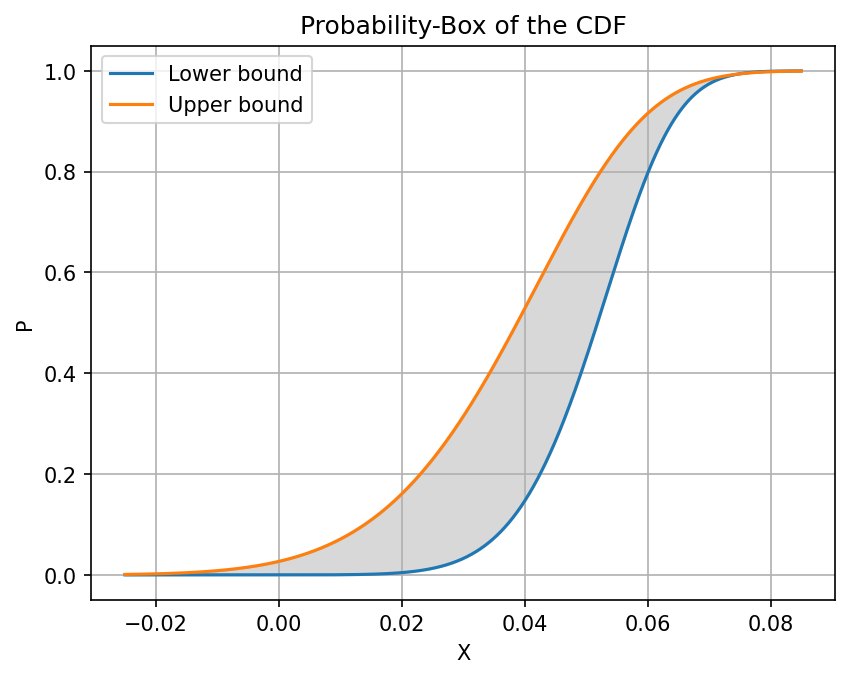

In [54]:
otaf.plotting.plot_gld_pbox_cdf(gld,
          [0.05388563, 0.01424974, 0.39190849, 0.12699835], 
          [0.04306886, 0.02397462, 0.36453265, 0.13973758],
          np.linspace(-0.025, 0.085, 1000))


In [ ]:
# Basinhopping for the maximization function using COBYQA
x0_maxi = [0.25] * RandDeviationVect.getDimension()  # Initial guess

# Update minimizer_kwargs_maxi to use COBYQA
minimizer_kwargs_maxi = {
    "method": "COBYQA",   # Use COBYQA method
    "args": (model_base,),     # Update args to match COBYQA requirements
    "constraints": nonLinearConstraint,
    "bounds": Bounds(lb=0.0,ub=1.0, keep_feasible=True),
    "options": {
        "f_target": -0.1, 
        "maxiter": 1000,
        "maxfev": 4000,
        "feasibility_tol": 1e-9, # tol on constraint violation
        "initial_tr_radius": np.sqrt(2*32),
        "final_tr_radius": 1e-4,
        "disp": True
    }
}

# Running basinhopping with COBYQA as the local optimizer
res_maxi = basinhopping(
    optimization_function_maxi, x0_maxi,
    niter=5,
    T=1,
    stepsize=3.0,
    niter_success=19,
    interval=5,
    minimizer_kwargs=minimizer_kwargs_maxi,
    disp=True,
    #take_step=step_taking,
    #accept_test=accept_test,
    #callback=callback
)

print("Maximization Result with COBYQA:")
print(res_maxi)

In [ ]:
res_maxi.x.round(3)

In [ ]:
N = ot.Normal()
func = ot.SymbolicFunction(["x"], ["abs(x)"])